# 코로나 19팀, 자기소개

안녕하세요. 코로나 19팀 리더 aksfchkschaskdvhadks 입니다.

저는 해당 분야를 공부한 지 한달 정도 밖에 되지 않았습니다.

아는 분의 소개를 받아서, 팀원을 구하게 되었고, 해당 팀원 분들과 대회에 참여를 하게 되었습니다.

초보자인 만큼, 노트북 정리 및 분석 능력 및 결과 도출 등에 관련된 것들이 많이 부족합니다. 

양해 부탁드립니다.

제가 사용한 환경은 Mac Pro (15-inch, 2018)과 colab을 병행해서 사용했습니다. 따라서 데이터 경로는 colab과 로컬 환경 둘다 표기를 하겠습니다.

그리고 저는 다음과 같은 디렉터리 구조를 가지고 해당 대회에 참여 했습니다.

```
.
├── input
│   └── dankook : 대회 데이터 셋
├── notebook : 주피터 노트북
└── output
    ├── feature : 대회 데이터 셋을 통해 만든 feature
    ├── oof_pred : 모델의 oof 예측값
    ├── sub : 모델의 test에 대한 예측
    └── test_pred : 모델의 test_pred에 대한 예측값
```

# 노트북 설정 및 라이브러리 임포트 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [124]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgbm
import xgboost as xgb

from hyperopt import hp 
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval
from hyperopt.pyll.base import scope

In [20]:
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
sns.set(font_scale=2.5)

warnings.filterwarnings('ignore')

# Dataset 확인 작업

저는 Dataset을 어떻게 사용해야 할지 감이 잡히지 않았습니다.

대회 데이터에서 변수에 대한 설명에 대한 변수에 대한 링크를 주셨지만, 해당 링크에 있는 내용과 현재 대회 데이터로서 제공된 변수들은 다른 내용이었습니다.

따라서 저는 해당 데이터들이 무엇을 의미하는지 먼저 알아봤습니다.

여기서 다루는 문제에서 사용되고는 feature는 다음과 같았습니다.

- u, g, r, i, z

- dered_u, dered_g, dered_r, dered_i, dered_z

- airmass_u, airmass_g, airmass_r, airmass_i, airmass_z

- redshift, nObserve, nDetect

따라서 인터넷 검색을 통해서 해당 feature 들이 무엇을 의미하는지 먼저 검색을 해봤습니다. 틀린 내용도 있을 수도 있지만, 저는 해당 feature들을 아래와 같이 정의 했습니다.

Note) 변수에 대한 자세한 설명은 해당 [링크][1]을 참조하시면 됩니다 

[1]: http://sdss.china-vo.org/skyserver/en/help/docs/QS_UserGuide.aspx

|변수(feature variable)|정의|설명|타입|
|:--:|:--:|:--:|:--:|
|u|자외선|continuous|float|
|g|가시광선(초록)|continuous|float|
|r|가시광선(빨강)|continuous|float|
|i|근 적외선|continuous|float|
|z|적외선|continuous|float|
|redshift|적색편이|continuous|float|
|dered_u|천체의 광도(자외선에 해당하는)|continuous|float|
|dered_g|천체의 광도(가시광선 초록에 해당하는)|continuous|float|
|dered_r|천체의 광도(가시광선 빨강에 해당하는)|continuous|float|
|dered_i|천체의 광도(근 적외선에 해당하는)|continuous|float|
|dered_z|천체의 광도(적외선에 해당하는)|continuous|float|
|nObserve|관측된수|discrete|int|
|nDetect|탐지된수|discrete|int|
|airmass_u|u-band 관측시 공기질량|continuous|float|
|airmass_g|g-band 관측시 공기질량|continuous|float|
|airmass_r|r-band 관측시 공기질량|continuous|float|
|airmass_i|i-band 관측시 공기질량|continuous|float|
|airmass_z|z-band 관측시 공기질량|continuous|float|

In [7]:
# EDA를 할 때 제가 사용한 데이터 경로는 다음과 같습니다.
# 전체적인 데이터 경로는 EDA 끝낸 후에 표시하겠습니다.

df_train = pd.read_csv('../input/dankook/train.csv', index_col=0)
df_test = pd.read_csv('../input/dankook/test.csv', index_col=0)

u        g        r        i        z    redshift  dered_u  dered_g  \
id                                                                              
0   23.2640  20.3368  19.0095  17.6724  16.9396 -8.1086e-05  23.1243  20.2578   
1   15.0521  14.0620  13.4524  13.2684  13.1689  4.5061e-03  14.9664  14.0045   
2   16.7864  15.8254  15.5363  15.3935  15.3500  4.7198e-04  16.6076  15.6866   
3   25.6606  21.1887  20.2212  19.8949  19.6346  5.8143e-06  25.3536  20.9947   
4   24.4534  20.6992  19.0424  18.3242  17.9826 -3.3247e-05  23.7714  20.4338   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0   18.9551  17.6321  16.9089        18       18     1.1898     1.1907   
1   13.4114  13.2363  13.1347         1        1     1.2533     1.2578   
2   15.4400  15.3217  15.2961         2        2     1.0225     1.0241   
3   20.0873  19.7947  19.5552         4        3     1.2054     1.2061   
4   18.8630  18.1903  17.8759        13       12     1.1939     1.1943   

    airmass_r  airmass_i  airmass_z  class  
id                                          
0      1.1890     1.1894     1.1902      0  
1      1.2488     1.2510     1.2555      1  
2      1.0210     1.0217     1.0233      0  
3      1.2049     1.2051     1.2057      0  
4      1.1937     1.1938     1.1941      0

In [27]:
df_train.describe()

u            g            r            i            z  \
count  320000.0000  320000.0000  320000.0000  320000.0000  320000.0000   
mean       19.8524      18.3768      17.7358      17.1742      16.8752   
std         1.9455      31.1108       1.4662      52.5615      57.1463   
min       -17.6875  -17555.3656       7.7314  -23955.8178  -23955.8178   
25%        18.7242      17.4749      16.8772      16.5239      16.2889   
50%        19.4194      18.1405      17.5258      17.1497      16.9176   
75%        20.4321      19.0732      18.4281      18.0074      17.7289   
max        58.6233      46.3383      72.0097      50.1641      52.6127   

         redshift      dered_u      dered_g      dered_r      dered_i  \
count  3.2000e+05  320000.0000  320000.0000  320000.0000  320000.0000   
mean   5.8308e-02      19.6289      18.2271      17.6154      17.1523   
std    5.7546e-01       1.9236      17.7866       1.4730      25.0758   
min   -1.6605e+02     -42.8375   -9999.0000     -16.3802   -9999.0000   
25%    3.5580e-05      18.5636      17.3484      16.7871      16.4530   
50%    4.7129e-02      19.2646      18.0224      17.4434      17.0874   
75%    9.4597e-02      20.1976      18.8884      18.2911      17.9070   
max    6.2323e+01      30.7779      30.6132      31.9572      32.0162   

           dered_z     nObserve      nDetect    airmass_u    airmass_g  \
count  320000.0000  320000.0000  320000.0000  320000.0000  320000.0000   
mean       16.8693       6.3327       6.1388       1.1758       1.1765   
std        35.4365       8.8811       8.5516       0.1163       0.1181   
min     -9999.0000       1.0000       1.0000       1.0001       1.0000   
25%        16.2341       1.0000       1.0000       1.0882       1.0884   
50%        16.8694       2.0000       2.0000       1.1793       1.1792   
75%        17.6557       5.0000       5.0000       1.2275       1.2260   
max        30.7813      44.0000      42.0000       2.0508       2.0803   

         airmass_r    airmass_i    airmass_z        class  
count  320000.0000  320000.0000  320000.0000  320000.0000  
mean        1.1751       1.1754       1.1761       1.1163  
std         0.1147       0.1155       0.1172       0.9235  
min         1.0002       1.0001       1.0000       0.0000  
25%         1.0878       1.0880       1.0883       0.0000  
50%         1.1794       1.1794       1.1793       1.0000  
75%         1.2292       1.2286       1.2268       2.0000  
max         2.0221       2.0363       2.0654       2.0000

In [28]:
df_test.describe()

u           g           r           i           z    redshift  \
count  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  8.0000e+04   
mean      19.8598     18.4371     17.7397     17.3065     17.1490  6.0083e-02   
std        1.9543      1.7030      1.4786      1.3207     24.6431  3.4684e-01   
min       -0.3385    -51.1753     -5.4387      5.3267    -39.5272 -3.0149e+01   
25%       18.7273     17.4780     16.8820     16.5255     16.2882  3.3645e-05   
50%       19.4261     18.1451     17.5299     17.1560     16.9212  4.7115e-02   
75%       20.4344     19.0793     18.4345     18.0080     17.7333  9.4769e-02   
max       56.8471     94.3591     46.6913     33.0259   6976.3922  4.6390e+01   

          dered_u     dered_g     dered_r     dered_i     dered_z    nObserve  \
count  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000   
mean      19.6350     18.2638     17.6193     17.2178     16.8702      6.3499   
std        1.9210      1.6657      1.4760      1.3324     35.4367      8.8728   
min      -30.6337    -18.6560     -8.7560     -3.6973  -9999.0000      1.0000   
25%       18.5709     17.3522     16.7906     16.4562     16.2310      1.0000   
50%       19.2674     18.0247     17.4487     17.0912     16.8733      2.0000   
75%       20.1999     18.8948     18.2952     17.9109     17.6578      5.0000   
max       30.8899     30.9529     31.6536     30.9478     28.6441     44.0000   

          nDetect   airmass_u   airmass_g   airmass_r   airmass_i   airmass_z  
count  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  
mean       6.1578      1.1760      1.1767      1.1753      1.1756      1.1763  
std        8.5509      0.1164      0.1182      0.1148      0.1156      0.1173  
min        1.0000      1.0001      1.0001      1.0002      1.0002      1.0001  
25%        1.0000      1.0881      1.0883      1.0877      1.0879      1.0882  
50%        2.0000      1.1794      1.1793      1.1794      1.1794      1.1793  
75%        5.0000      1.2278      1.2262      1.2294      1.2289      1.2269  
max       42.0000      2.0502      2.0797      2.0216      2.0358      2.0648

위를 통해서 알 수 있는 점은 다음과 같다.

훈련 데이터셋은 어떤 특정 feature에서 이상치가 존재한다. 테스트 데이터셋은 그러한 이상치가 없다.

## Target label 분포도 확인

저는 초반에 어떠한 방식으로 데이터를 분석해야 하는지 몰랐습니다. 이유한님의 캐글 커리큘럼 따라하기를 통해서 1주차~4주차 내용을 공부 했고, 따로 강의를 들으면서, 그것을 통해서 EDA를 진행했습니다. 

거기서 먼저 Target label을 확인을 했기에 저도 먼저 Target label을 확인했습니다. binary classification 문제의 경우에서 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있다고 되어 있었습니다.

그래서 multi classification 문제의 경우에서도 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있다고 생각 됬기에 Target label 분포를 먼저 확인 했습니다.

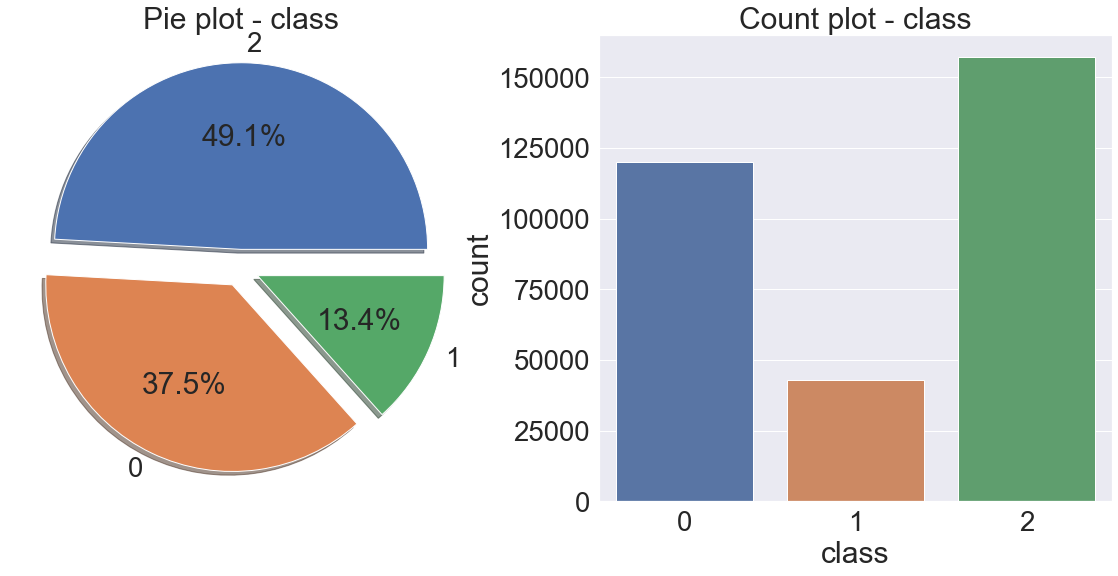

In [9]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['class'].value_counts().plot.pie(explode=[0.1, 0.1, 0.1], autopct='%1.1f%%', ax=ax[0],shadow=True)
ax[0].set_title('Pie plot - class')
ax[0].set_ylabel('')

sns.countplot('class', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - class')

plt.show()

Target Label의 분포도에서 볼 수 있듯이, 2가 가장 많았고, 그다음으로 0이 가장 많았고, 그 다음으로 1이 가장 많다는 것을 알 수 있습니다.

## 연관 feature 들 간의 연관성 찾기

320,000개의 데이터셋을 시각화 하는 데는 시간이 걸려서, 10,000개의 샘플을 추출해서 시각화를 진행했습니다

In [11]:
train_sample = df_train.sample(n=10000,random_state=2020)

### u, g, r, i, z 간의 연관성 찾기

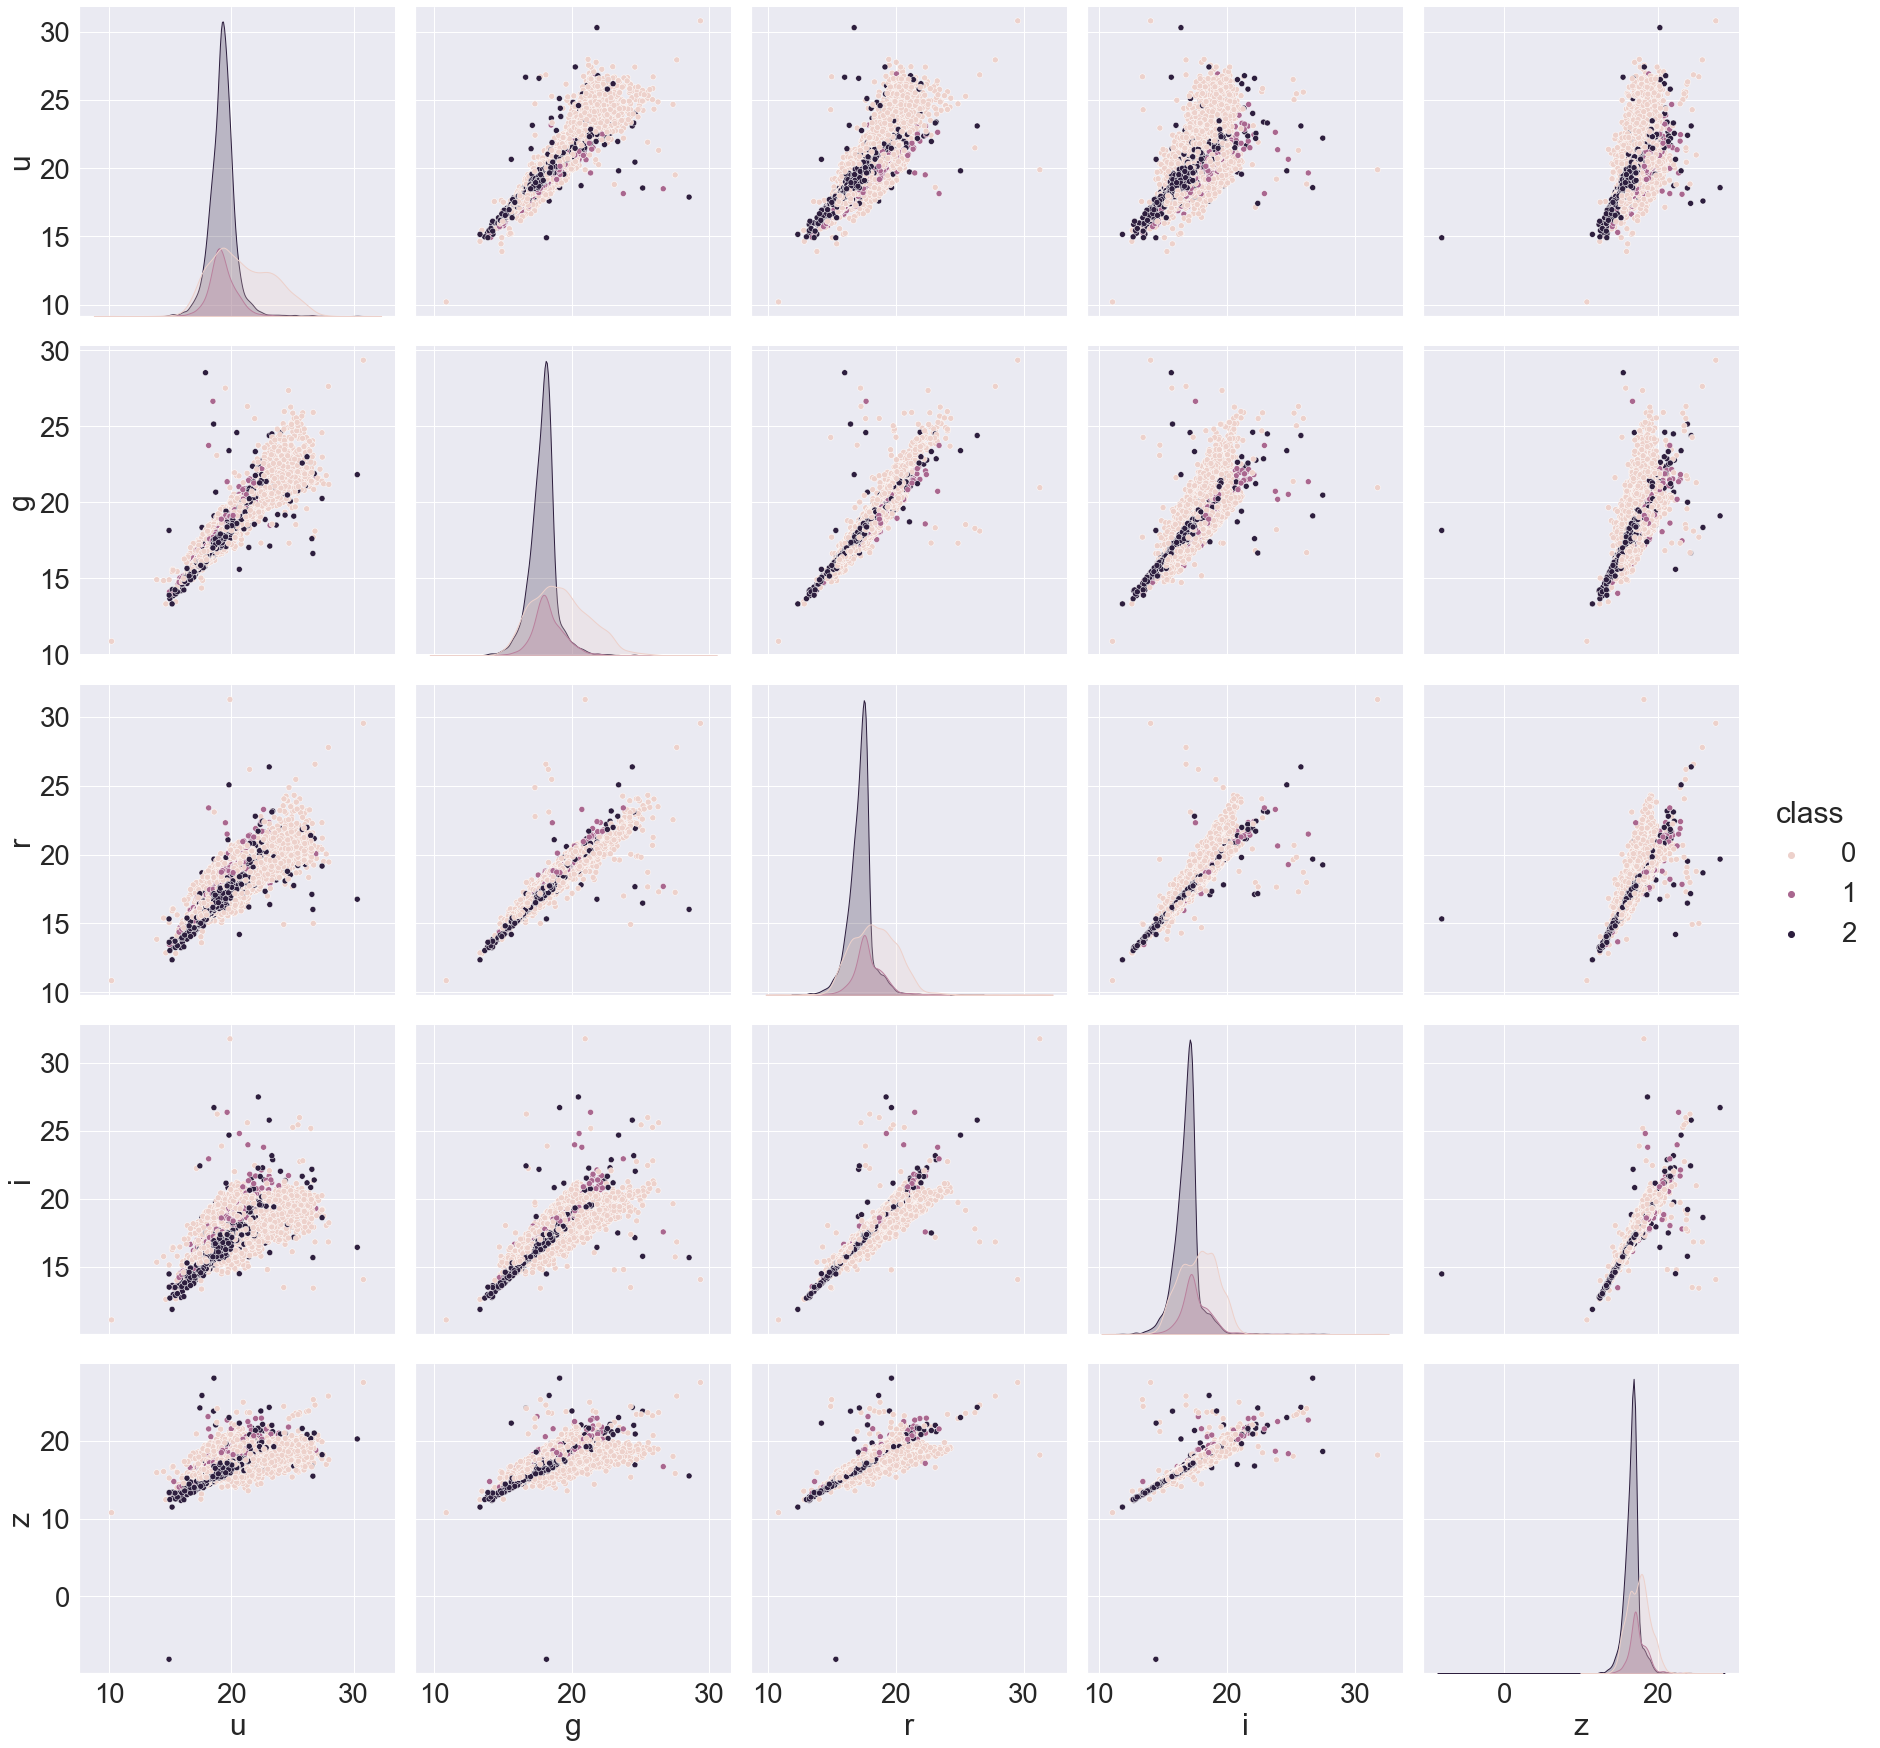

In [12]:
sns.pairplot(data=train_sample, vars=['u', 'g', 'r', 'i', 'z'], hue='class', size=5)

시각화를 통해서 u, g, r, i, z가 서로가 우상향 하는 특징을 가지고 있다는 것을 알게 되었습니다

그리고 서로에 대한 커널 밀도 추정을 보면, 클래스 2는 가장 분류하기가 쉽고, 클래스 1과 클래스 0은 분류하기가 어렵다는 것을 알 수 있었습니다.

그나마 그중 클래스 0이 좀더 분류하기 쉬워보였습니다

### dered_X 간의 연관성 찾기

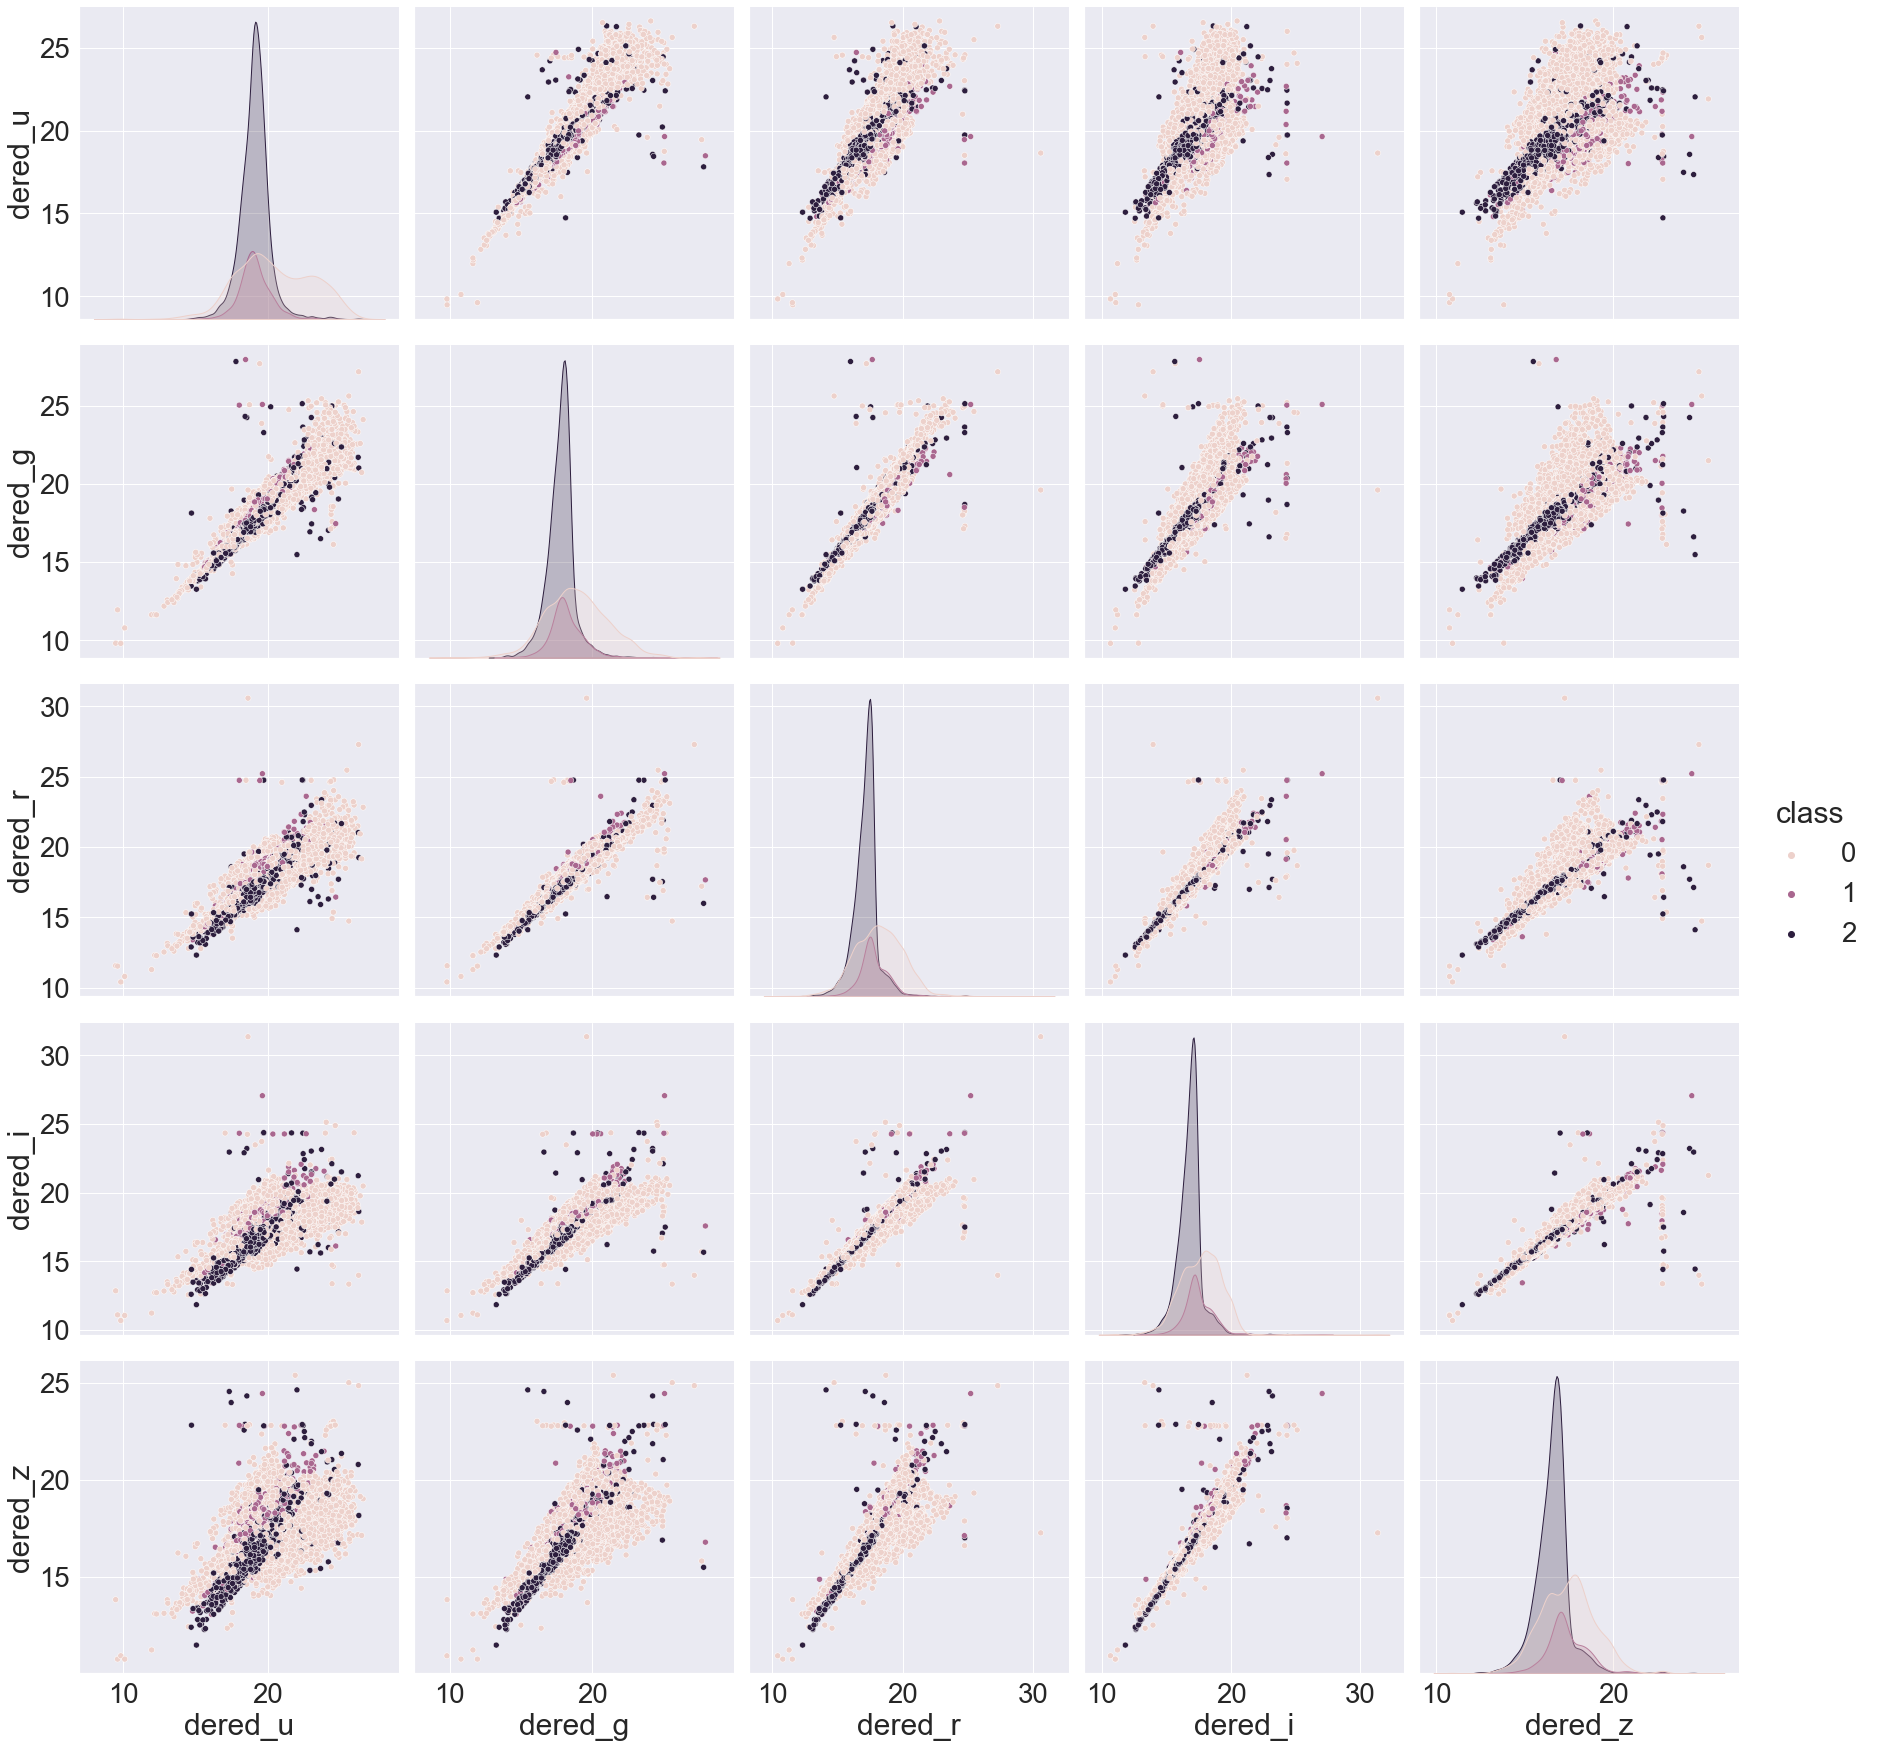

In [22]:
sns.pairplot(data=train_sample, vars=['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z'], hue='class', size=5)

시각화를 통해서 dered_u, dered_g, dered_r, dered_i, dered_z가 서로 우상향 한다는 특징을 알게 되었습니다

그리고 서로에 대한 커널 밀도 추정을 보면, 클래스 2는 가장 분류하기가 쉽고, 클래스 1과 클래스 0은 분류하기가 어렵다는 것을 알 수 있었습니다.

그나마 그중 클래스 0이 좀더 분류하기 쉬워보였습니다

### airmass_X 간의 연관성 찾기

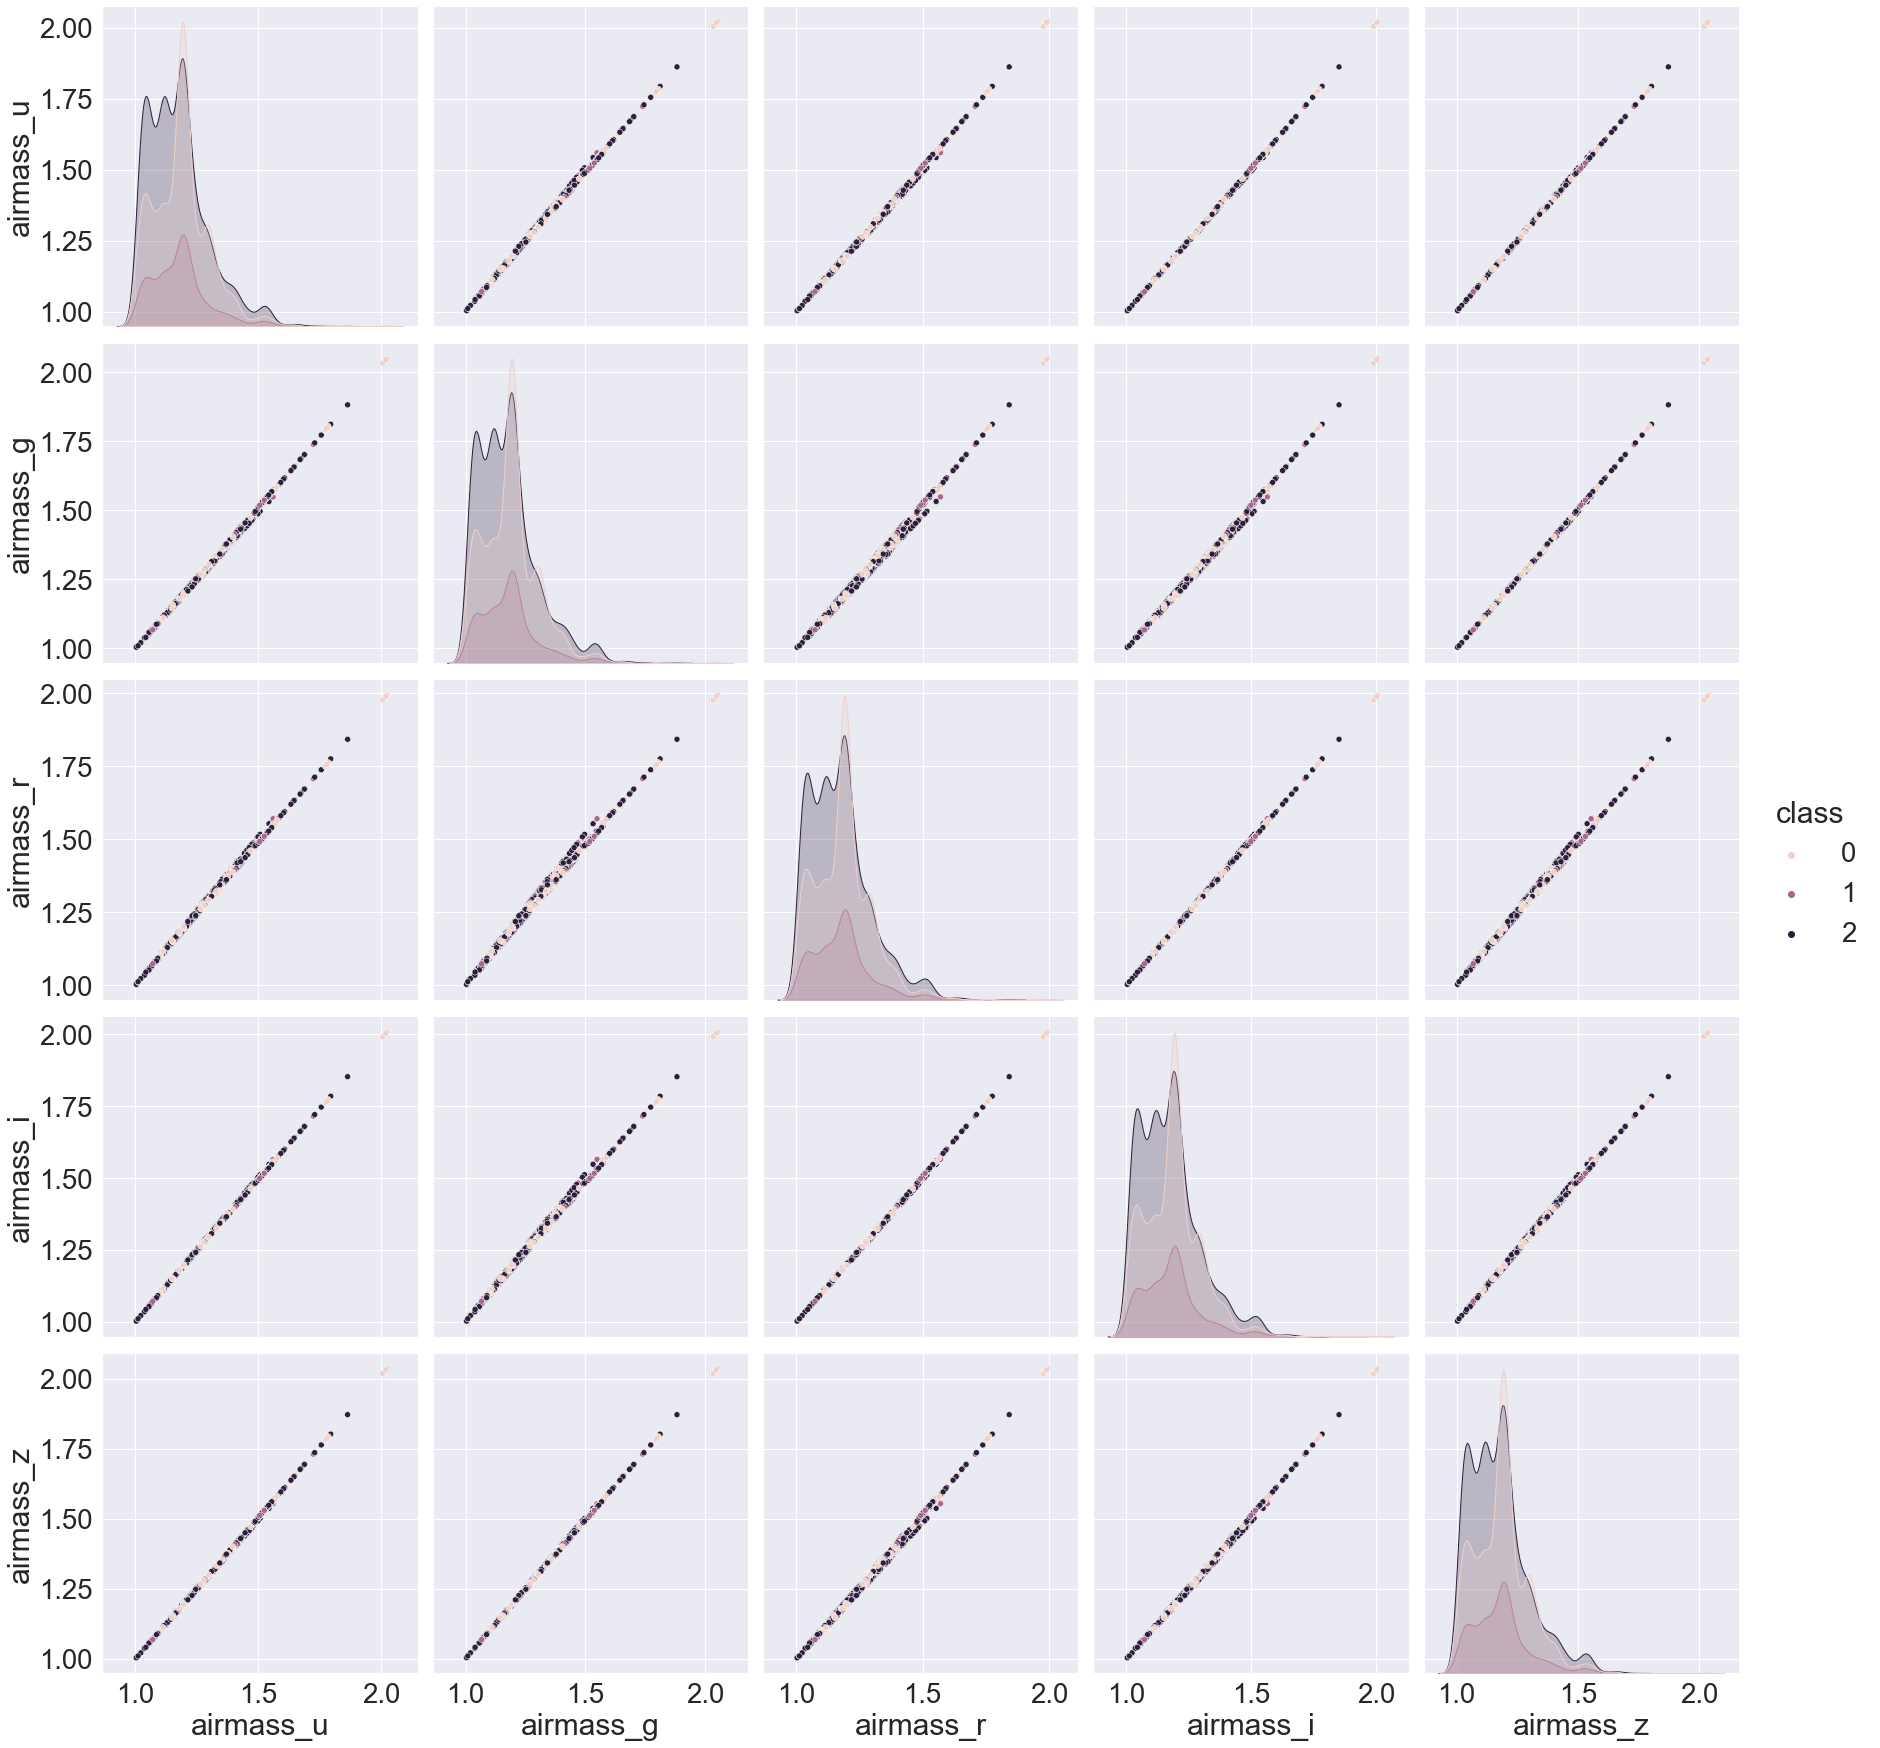

In [23]:
sns.pairplot(data=train_sample, vars=['airmass_u', 'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z'], hue='class', size=5)

시각화를 통해서 airmass_u, airmass_g, airmass_r, airmass_i, airmass_z 가 서로 우상향 한다는 특징을 가지고 있다는 것을 알게 되었습니다.

그리고 서로에 대한 커널 밀도 추정을 보면, 앞서 봤던 것들에 비해서는 클래스 2, 클래스 1, 클래스 0을 분류하기가 쉽다는 것을 알 수 있었습니다.

### X, dered_X, airmass_X 간의 연관성 찾기 

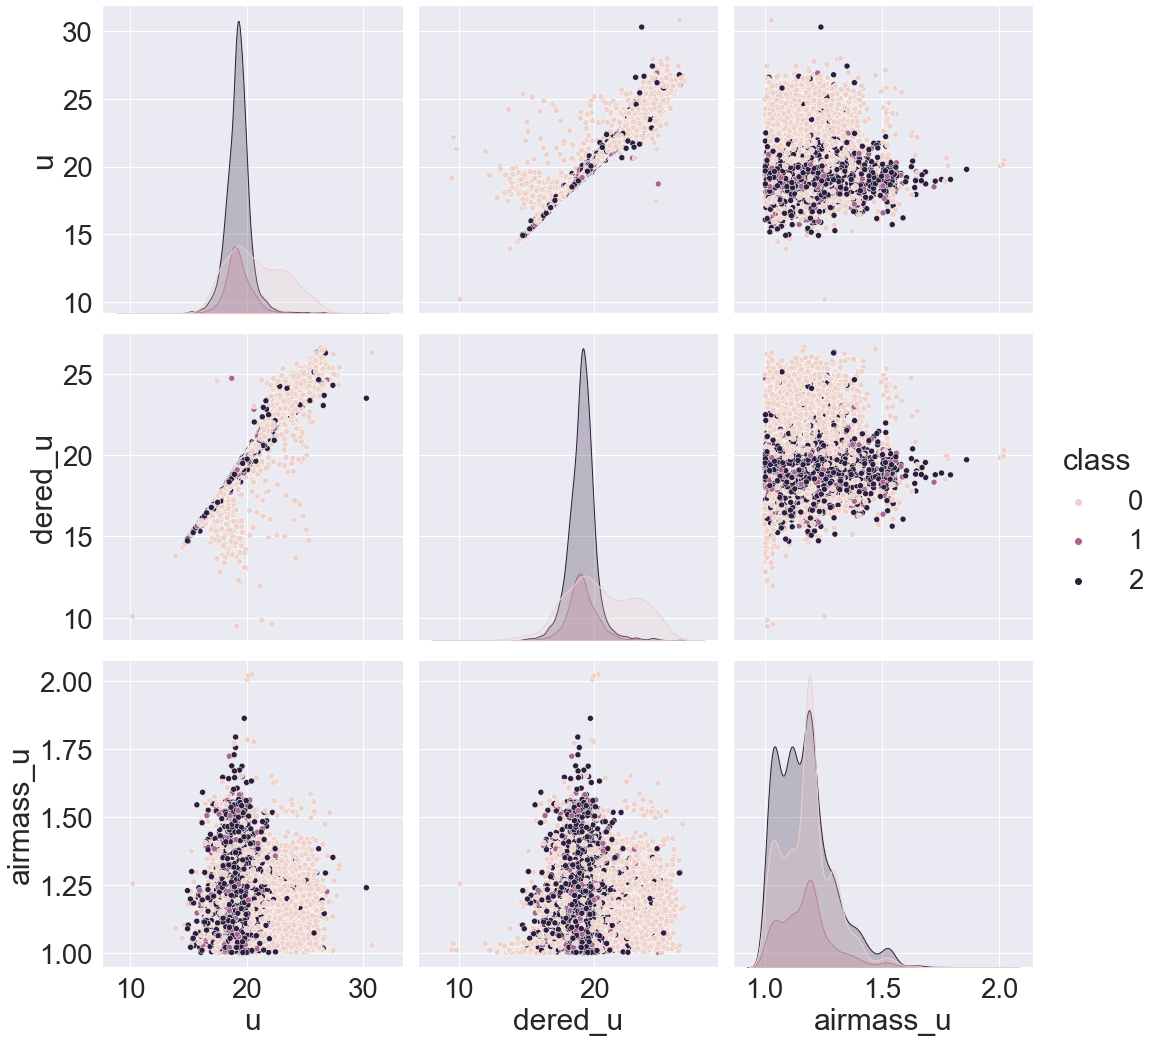

In [15]:
sns.pairplot(data=train_sample, vars=['u', 'dered_u', 'airmass_u'], hue='class', size=5)

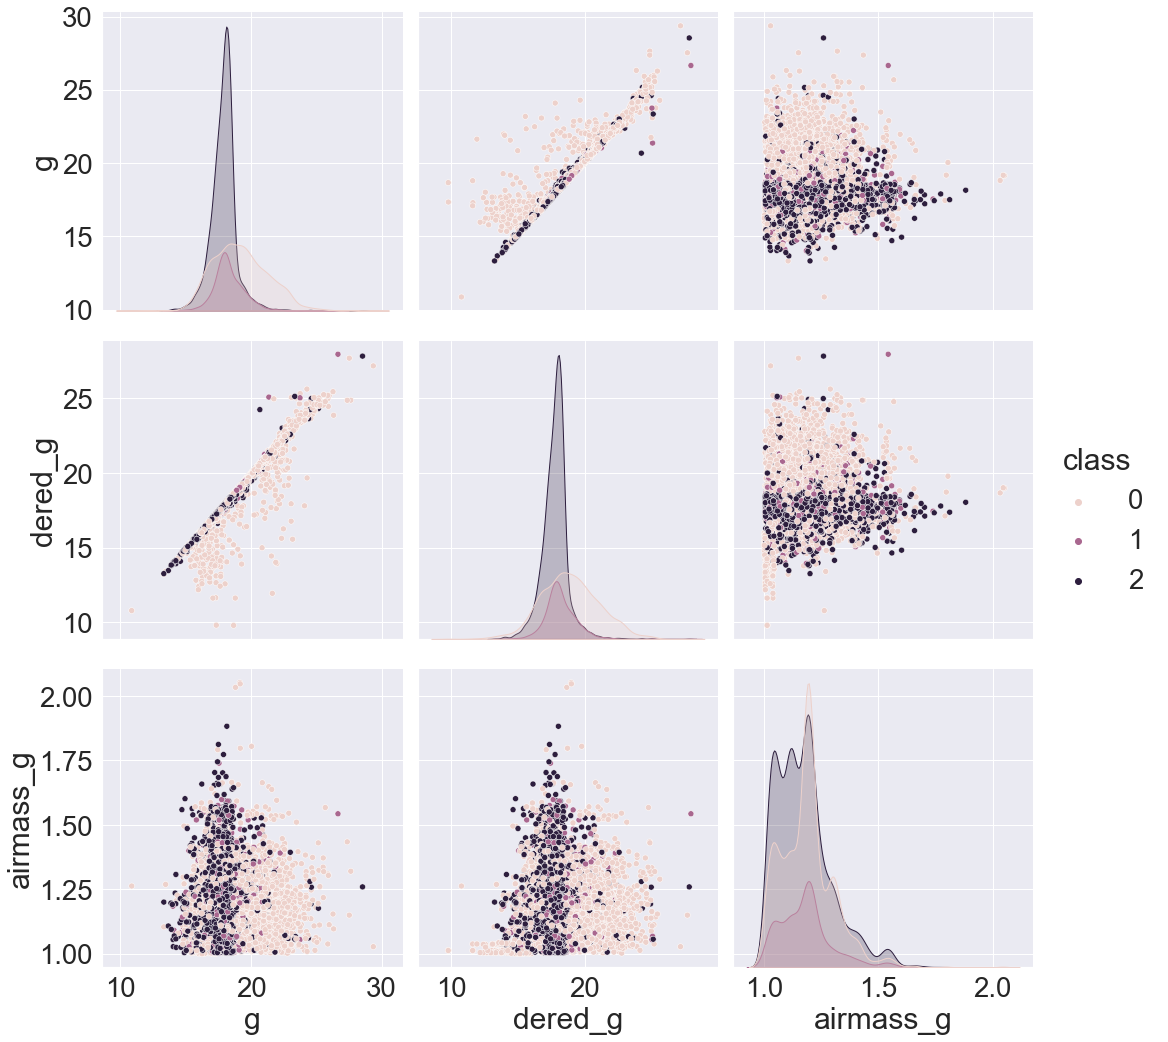

In [16]:
sns.pairplot(data=train_sample, vars=['g', 'dered_g', 'airmass_g'], hue='class', size=5)

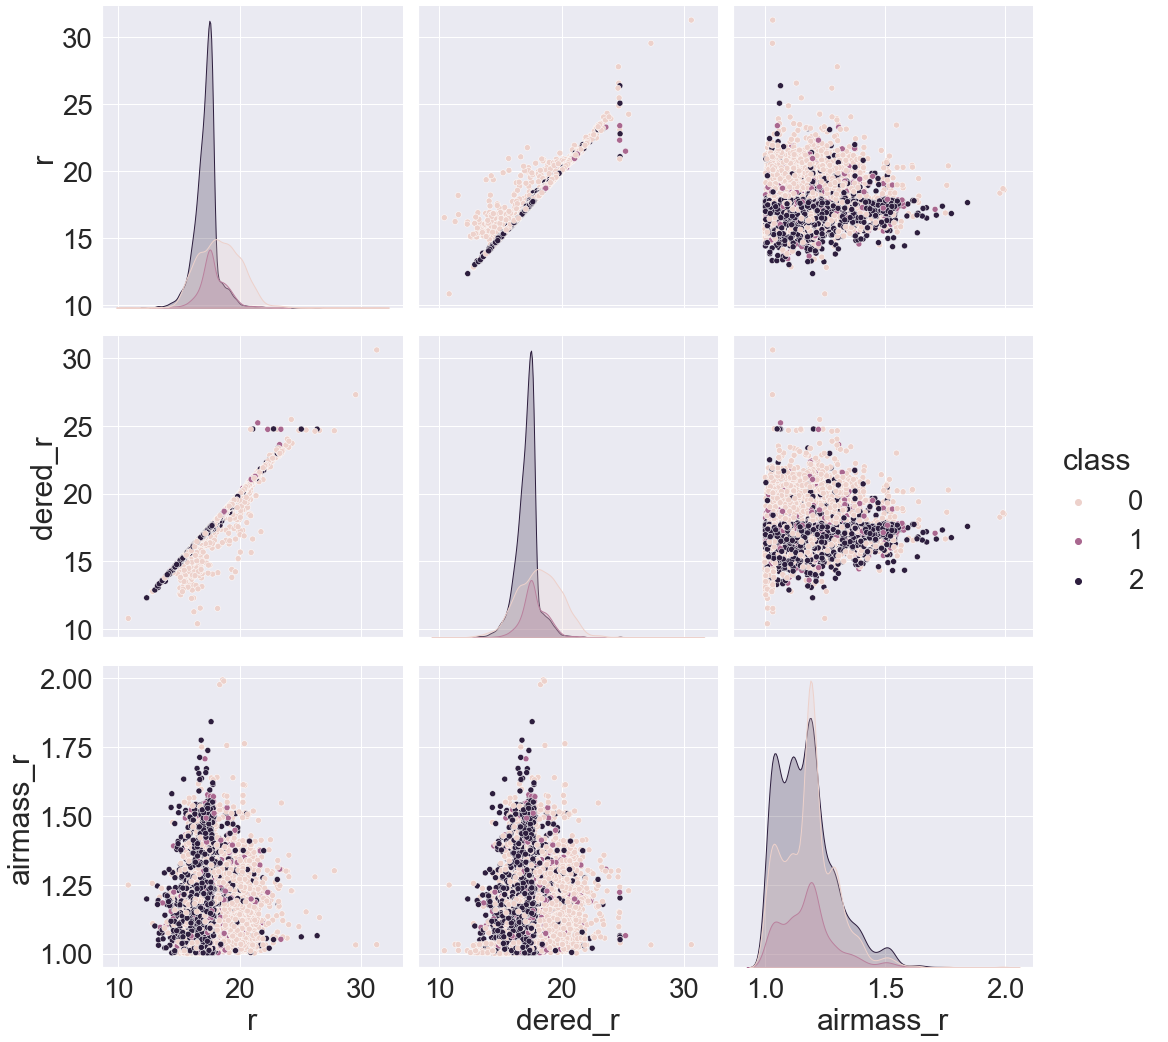

In [17]:
sns.pairplot(data=train_sample, vars=['r', 'dered_r', 'airmass_r'], hue='class', size=5)

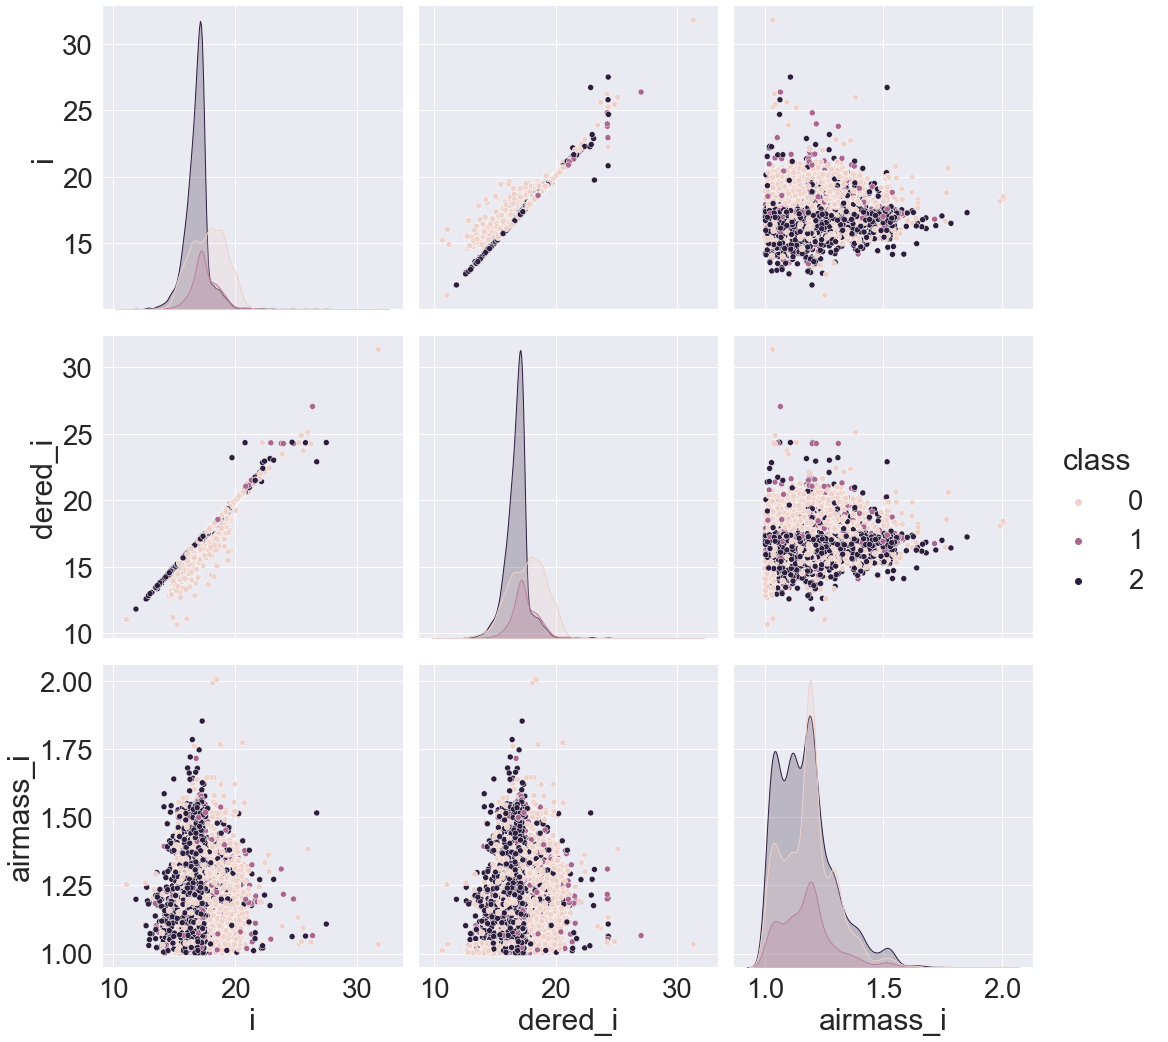

In [18]:
sns.pairplot(data=train_sample, vars=['i', 'dered_i', 'airmass_i'], hue='class', size=5)

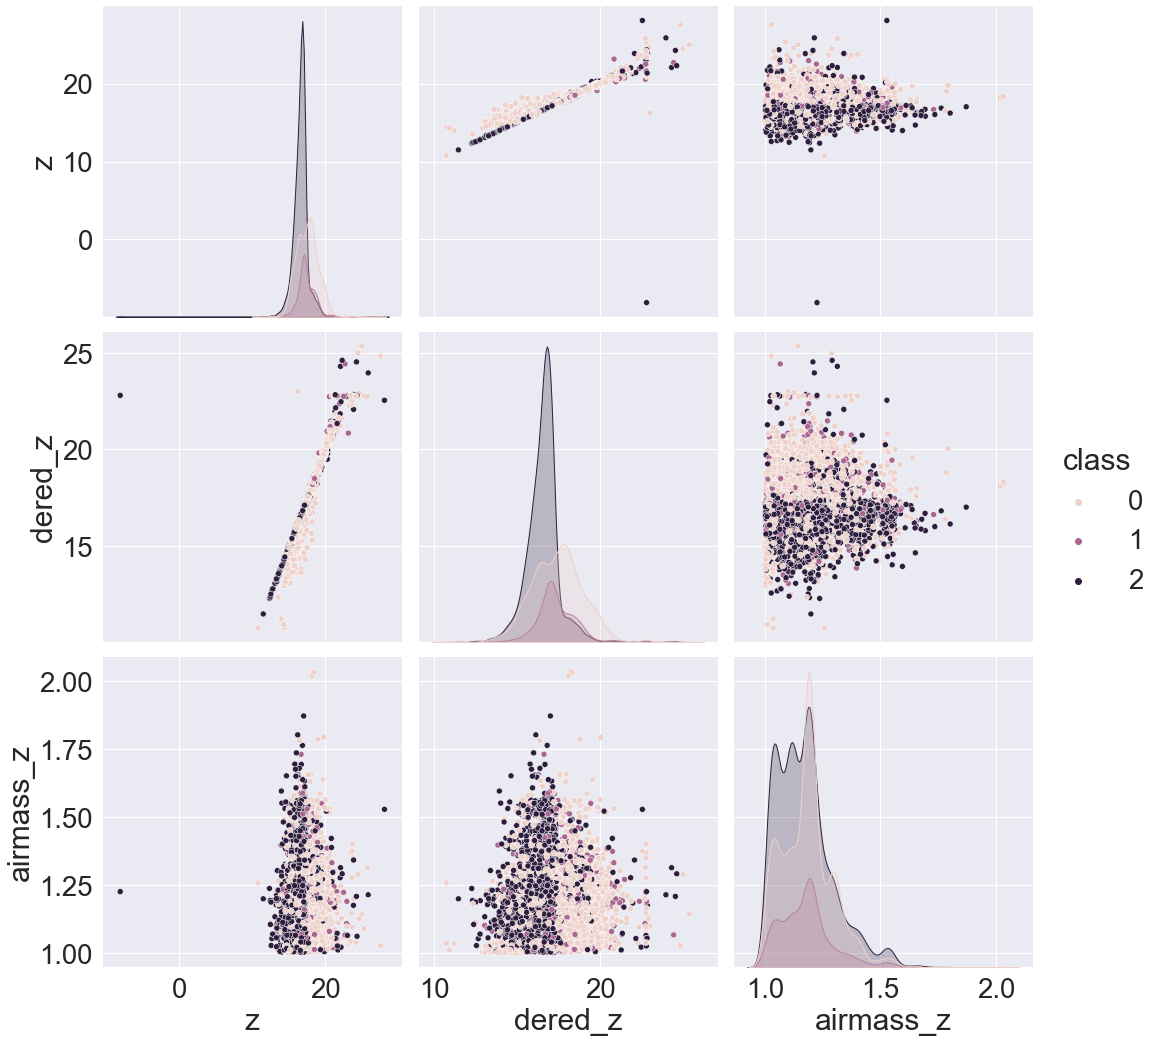

In [21]:
sns.pairplot(data=train_sample, vars=['z', 'dered_z', 'airmass_z'], hue='class', size=5)

서로가 다 비슷한 양상을 띄고 있습니다.

dered_X 와 X 는 우상향을 하는 듯한 모습을 보였고, airmass_X 와 X 그리고 airmass_X 와 dered_X는 군집을 이루는 듯한 모습을 보여줬습니다.

### redshift, nObserve, nDetect 간의 관계

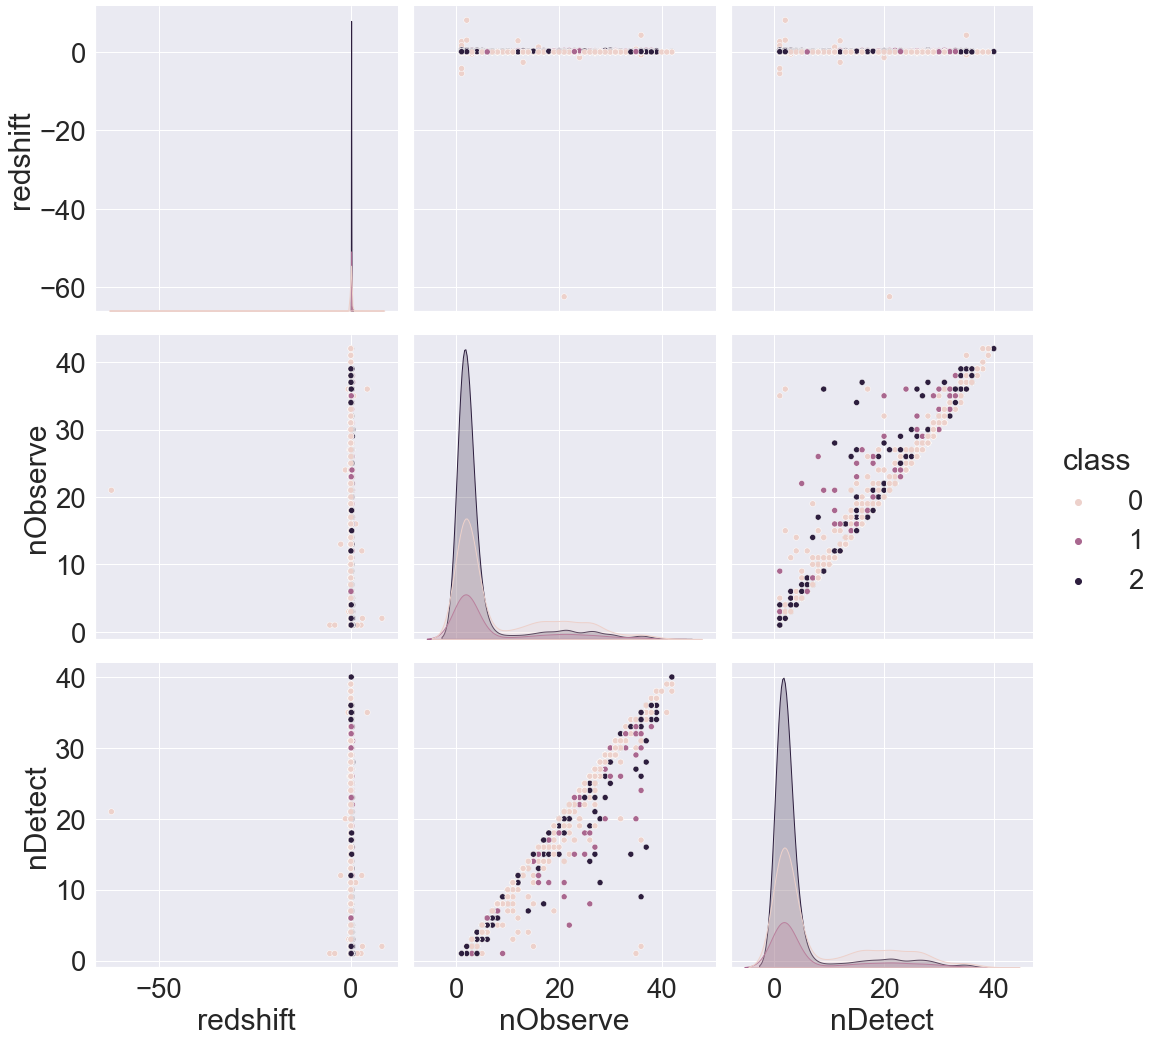

In [24]:
sns.pairplot(data=train_sample, vars=['redshift', 'nObserve', 'nDetect'], hue='class', size=5)

nObserve 와 nDetect는 멱함수의 분포를 가지고 있다는 것을 알 수 있었습니다.

nDetect 와 nObserve는 서로에 대해서 우상향 하는 듯한 모습을 보여줬습니다

redshift 와 나머지와긔 관계는 일직선 형태의 모습을 보여 주고 있는데, redshift가 어느 한 범위에 촘촘하게 모여 있어서 이러한 모습을 보여준 것이 아닌가 생각을 했습니다

## 모든 feature 분포 보기

In [25]:
df_train.groupby('class').mean()

u        g        r        i        z  redshift  dered_u  \
class                                                                   
0      20.8648  19.2129  18.3938  17.8377  17.5528   -0.0024  20.5223   
1      19.2710  17.8776  17.8412  17.1333  17.0058    0.1055  19.1071   
2      19.2380  17.8746  17.2048  16.6790  16.3225    0.0918  19.0890   

       dered_g  dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  \
class                                                                     
0      18.9474  18.2100  17.7011  17.4511    8.5553   8.3138     1.1864   
1      17.9267  17.7526  17.2447  17.1343    7.0451   6.7588     1.1776   
2      17.7590  17.1243  16.7084  16.3531    4.4425   4.3101     1.1671   

       airmass_g  airmass_r  airmass_i  airmass_z  
class                                              
0         1.1873     1.1856     1.1860     1.1868  
1         1.1784     1.1770     1.1773     1.1780  
2         1.1678     1.1666     1.1669     1.1674

<AxesSubplot:>

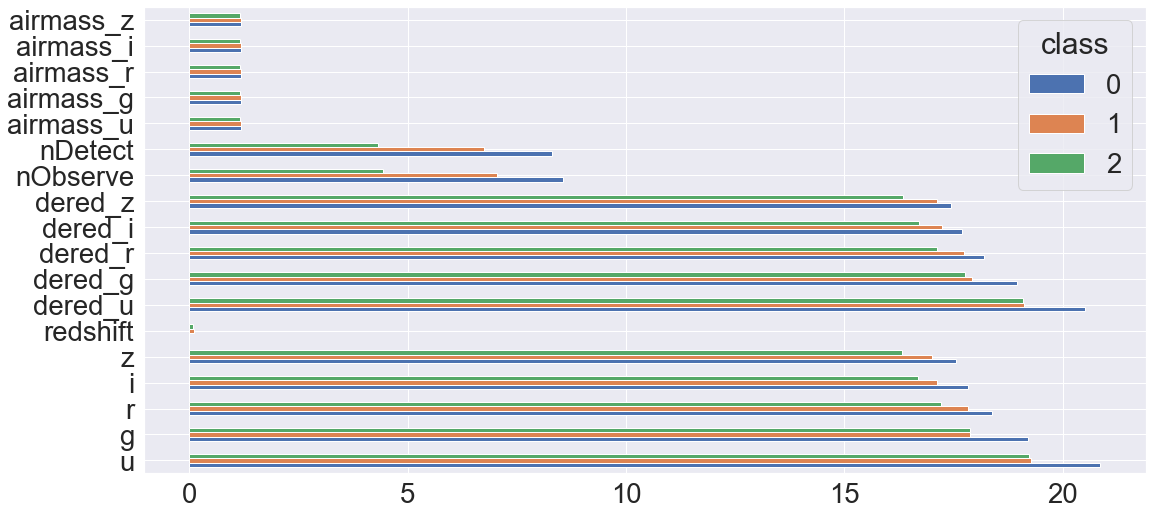

In [26]:
df_train.groupby('class').mean().T.plot(kind='barh')

앞서 했던 시각화와 이것을 통해서 알 수 있었던 점은 다음과 같았습니다.

u, g, r, i, z는 서로가 비슷한 특징을 가지고 있다.

dered_u, dered_g, dered_r, dered_i, dered_z는 서로 비슷한 특징을 가지고 있다.

airmass_u, airmass_g, airmass_r, airmass_i, airamss_z는 서로 비슷한 특징을 가지고 있다.

nObserve 와 nDetect는 멱함수의 분포를 가지고 있다.

redshift는 어느 한 범위에 값이 집중되어 분포되어 있다.

# Feature enginnering

이러한 방식으로 EDA를 했지만, 초보자한테는 해당 데이터셋을 가지고 새로운 feature을 만드는 것이 어려웠습니다.

그래서 인터넷을 통해서 정보를 찾았고, 데이콘에서 해당 대회와 비슷한 도메인을 가진 [대회][1]가 열렸다는 것을 알게 되었습니다.

그 대회에 참가한 사람의 코드 공유 내용을 보고, 직접 필사 해보고, 거기서 적용한 feature enginnering 기법을 해당 대회에 적용시켜서, 새로운 featrue를 생성했습니다. 제가 참고한 코드는 [1등][2], [2등][3] 분의 노트북이었습니다.

[1]: https://dacon.io/competitions/official/235573/overview/
[2]: https://dacon.io/competitions/official/235573/codeshare/721?page=1&dtype=recent&ptype=pub
[3]: https://dacon.io/competitions/official/235573/codeshare/693?page=1&dtype=recent&ptype=pub

## 대회 데이터 로드

먼저 대회 데이터 로드를 위한 경로 및 새롭게 만든 feature을 만들 경로를 지정합니다

In [30]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'

In [31]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')

# train_file = data_dir / 'train.csv'
# test_file = data_dir / 'test.csv'

In [37]:
feature_name = 'feature'

# 2등분 코드 참고해서 만든 feature
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# 1등분 코드 참고해서 만든 feature
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# 대회 데이터 그대로 사용
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# 2등분 코드 참고해서 만든 feature에 polynomial 기법 적용
polynomial_feature_Ver1_file = feature_dir / f'polynomial_{feature_name}_Ver1.csv'
# 1등분 코드 참고해서 만든 feature에 polynomial 기법 적용
polynomial_feature_Ver2_file = feature_dir / f'polynomial_{feature_name}_Ver2.csv'
# 대회 데이터에 polynomial 기법 적용
polynomial_feature_Ver3_file = feature_dir / f'polynomial_{feature_name}_Ver3.csv'

# 대회 데이터, 훈련 데이터에 대한 타겟 레이블
feature_target_file = feature_dir / f'{feature_name}_target.csv'

In [38]:
target_column = 'class'

In [39]:
df_train = pd.read_csv(train_file, index_col=0)
df_test = pd.read_csv(test_file, index_col=0)

## 이상치 제거

대회 데이터에 이상치가 있다는 것을 발견 했지만, 어떻게 제거할지 고민을 했다. 처음에는 메뉴얼하게 제거를 했었지만, 다른 분의 코드를 참고해서 테스트 데이터셋의 MinMax 범위 넘는 행들을 훈련 데이터셋에서 제거를 했다.

In [40]:
# test의 MinMax 범위 넘는 행은 train에서 제거
train_shape = df_train.shape[0]

for col in df_train.columns[:18]:
    df_train = df_train.loc[np.logical_and(df_train[col]>=df_test[col].min(),
                            df_train[col]<=df_test[col].max())]

print('제거된 행 개수 :', train_shape - df_train.shape[0])

제거된 행 개수 : 77


In [41]:
df_train.describe()

u            g            r            i            z  \
count  319923.0000  319923.0000  319923.0000  319923.0000  319923.0000   
mean       19.8525      18.4318      17.7352      17.3037      17.0603   
std         1.9392       1.6598       1.4586       1.3141       1.3310   
min         2.2651     -12.4441       7.7314       7.7115      -9.2548   
25%        18.7244      17.4750      16.8773      16.5240      16.2890   
50%        19.4195      18.1405      17.5259      17.1498      16.9177   
75%        20.4320      19.0728      18.4279      18.0074      17.7288   
max        49.1436      46.3383      45.1299      32.8634      52.6127   

         redshift      dered_u      dered_g      dered_r      dered_i  \
count  3.1992e+05  319923.0000  319923.0000  319923.0000  319923.0000   
mean   6.0481e-02      19.6298      18.2591      17.6158      17.2151   
std    2.9110e-01       1.9114       1.6594       1.4672       1.3250   
min   -2.5915e+01     -30.6337     -18.6560      -8.7560      -3.6973   
25%    3.5724e-05      18.5639      17.3486      16.7874      16.4532   
50%    4.7153e-02      19.2647      18.0225      17.4434      17.0874   
75%    9.4606e-02      20.1976      18.8883      18.2908      17.9070   
max    4.4620e+01      30.7779      30.6132      31.2940      30.5509   

           dered_z     nObserve      nDetect    airmass_u    airmass_g  \
count  319923.0000  319923.0000  319923.0000  319923.0000  319923.0000   
mean       16.9944       6.3334       6.1396       1.1758       1.1765   
std         1.3232       8.8817       8.5522       0.1163       0.1181   
min         0.2159       1.0000       1.0000       1.0001       1.0001   
25%        16.2343       1.0000       1.0000       1.0883       1.0885   
50%        16.8694       2.0000       2.0000       1.1794       1.1792   
75%        17.6555       5.0000       5.0000       1.2275       1.2260   
max        28.5710      44.0000      42.0000       2.0491       2.0786   

         airmass_r    airmass_i    airmass_z        class  
count  319923.0000  319923.0000  319923.0000  319923.0000  
mean        1.1751       1.1754       1.1761       1.1165  
std         0.1147       0.1155       0.1171       0.9234  
min         1.0002       1.0002       1.0002       0.0000  
25%         1.0878       1.0881       1.0883       0.0000  
50%         1.1794       1.1794       1.1793       1.0000  
75%         1.2292       1.2286       1.2268       2.0000  
max         2.0205       2.0347       2.0637       2.0000

In [42]:
df_test.describe()

u           g           r           i           z    redshift  \
count  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  8.0000e+04   
mean      19.8598     18.4371     17.7397     17.3065     17.1490  6.0083e-02   
std        1.9543      1.7030      1.4786      1.3207     24.6431  3.4684e-01   
min       -0.3385    -51.1753     -5.4387      5.3267    -39.5272 -3.0149e+01   
25%       18.7273     17.4780     16.8820     16.5255     16.2882  3.3645e-05   
50%       19.4261     18.1451     17.5299     17.1560     16.9212  4.7115e-02   
75%       20.4344     19.0793     18.4345     18.0080     17.7333  9.4769e-02   
max       56.8471     94.3591     46.6913     33.0259   6976.3922  4.6390e+01   

          dered_u     dered_g     dered_r     dered_i     dered_z    nObserve  \
count  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000   
mean      19.6350     18.2638     17.6193     17.2178     16.8702      6.3499   
std        1.9210      1.6657      1.4760      1.3324     35.4367      8.8728   
min      -30.6337    -18.6560     -8.7560     -3.6973  -9999.0000      1.0000   
25%       18.5709     17.3522     16.7906     16.4562     16.2310      1.0000   
50%       19.2674     18.0247     17.4487     17.0912     16.8733      2.0000   
75%       20.1999     18.8948     18.2952     17.9109     17.6578      5.0000   
max       30.8899     30.9529     31.6536     30.9478     28.6441     44.0000   

          nDetect   airmass_u   airmass_g   airmass_r   airmass_i   airmass_z  
count  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  80000.0000  
mean       6.1578      1.1760      1.1767      1.1753      1.1756      1.1763  
std        8.5509      0.1164      0.1182      0.1148      0.1156      0.1173  
min        1.0000      1.0001      1.0001      1.0002      1.0002      1.0001  
25%        1.0000      1.0881      1.0883      1.0877      1.0879      1.0882  
50%        2.0000      1.1794      1.1793      1.1794      1.1794      1.1793  
75%        5.0000      1.2278      1.2262      1.2294      1.2289      1.2269  
max       42.0000      2.0502      2.0797      2.0216      2.0358      2.0648

## 실제 타겟 값 생성

나중에 stacking을 사용할 때, 모델을 학습 시키기 위해서 실제 타겟 값을 가지고 있는 파일을 따로 생성을 해준다.

In [43]:
y = df_train.loc[:, target_column]
y.to_csv(feature_target_file)

## 변수 생성

총 6가지를 변수를 만들 예정입니다.

- feature_Ver1 은 2등분 코드를 참고해서 만든 변수.

- feature_Ver2 은 1등분 코드를 참고해서 만든 변수

- feature_Ver3 은 원본 대회 데이터 변수

- polynomial_feature_Ver1 은 2등분 코드를 참고해서 만든 변수에 polynomial 기법을 적용한 변수

- polynomial_feature_Ver2 은 1등분 코드를 참고해서 만든 변수에 polynomial 기법을 적용한 변수

- polynomial_feature_Ver3 은 원본 대회 데이터 변수에 polynomial 기법을 적용한 변수

### feature_Ver1 변수 생성

In [44]:
df_train2 = df_train.copy()
df_test2 = df_test.copy()

In [45]:
# 새로운 feature에 만들때 사용할 필드를 선택
wave_columns = df_train.columns.drop(['nObserve','nDetect',target_column,'redshift'])

In [46]:
# 선택한 필드들을 가지고 앞뒤 간의 차를 이용해서 새로운 변수 생성
for j in range(14):
    name = 'diff_' + str(wave_columns[j+1]) + '_' + str(wave_columns[j])
    df_train2[name] = df_train2[wave_columns[j+1]] - df_train2[wave_columns[j]]
    df_test2[name] = df_test2[wave_columns[j+1]] - df_test2[wave_columns[j]]
    print(wave_columns[j+1], ' - ', wave_columns[j], j)

g  -  u 0
r  -  g 1
i  -  r 2
z  -  i 3
dered_u  -  z 4
dered_g  -  dered_u 5
dered_r  -  dered_g 6
dered_i  -  dered_r 7
dered_z  -  dered_i 8
airmass_u  -  dered_z 9
airmass_g  -  airmass_u 10
airmass_r  -  airmass_g 11
airmass_i  -  airmass_r 12
airmass_z  -  airmass_i 13


In [47]:
# 선택한 필드들을 가지고 15포인트 랭킹 변수 생성

mag_rank_tr = df_train2[wave_columns].rank(axis=1)
mag_rank_tt = df_test2[wave_columns].rank(axis=1)

rank_col = []
for col in df_train2[wave_columns].columns:
    col = col + '_rank'
    rank_col.append(col)
mag_rank_tr.columns = rank_col
mag_rank_tt.columns = rank_col

df_train2 = pd.concat([df_train2, mag_rank_tr], axis=1)
df_test2 = pd.concat([df_test2,mag_rank_tt], axis=1)

In [48]:
# 선택한 필드들을 가지고
# 측정방법별 파장 차이 비교 변수 생성

diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(2):
        diff_col.append(col + '_' + str(i))

mag_wave_diff_tr = pd.DataFrame(np.zeros((df_train2.shape[0], 10)), index=df_train2.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((df_test2.shape[0],10)), index=df_test2.index)

for i in range(0,10,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:, j+i] = df_train2[wave_columns[j]] - df_train2[wave_columns[5+j+i]]
        mag_wave_diff_tt.loc[:, j+i] = df_test2[wave_columns[j]] - df_test2[wave_columns[5+j+i]]
        print(wave_columns[j], ' - ', wave_columns[5+j+i],i+j)

u  -  dered_u 0
g  -  dered_g 1
r  -  dered_r 2
i  -  dered_i 3
z  -  dered_z 4
u  -  airmass_u 5
g  -  airmass_g 6
r  -  airmass_r 7
i  -  airmass_i 8
z  -  airmass_z 9


In [49]:
# 새롭게 만든 변수들을 대회 데이터에 추가함.
mag_wave_diff_tr.columns = diff_col
mag_wave_diff_tt.columns = diff_col

df_train2 = pd.concat([df_train2, mag_wave_diff_tr], axis=1)
df_test2 = pd.concat([df_test2, mag_wave_diff_tt], axis=1)

In [50]:
# 멱함수 분포를 정규 분포를 만들기 위해서, np.log1p를 사용
# 그리고 nObserve 와 nDetect 차를 새로운 변수로 생성
df_train2['nObserve'] = df_train2['nObserve'].apply(np.log1p)
df_test2['nObserve'] = df_test2['nObserve'].apply(np.log1p)

df_train2['d_obs_det'] = df_train2['nObserve'] - df_train2['nDetect']
df_test2['d_obs_det'] = df_test2['nObserve'] - df_test2['nDetect']

In [51]:
# permutation importance를 사용해서, 사용할 필드들을 선택했음.
drop_columns = ['d_obs_det','g_0','diff_airmass_z_airmass_i','u','airmass_g','airmass_z','nDetect','dered_i_rank','diff_airmass_r_airmass_g','dered_r_rank','dered_g_rank','g_rank','airmass_i_rank','airmass_r_rank','airmass_g_rank','airmass_z_rank','dered_u_rank','r_rank','diff_airmass_u_dered_z','u_rank','z_rank','dered_z_rank','airmass_u_rank','diff_airmass_i_airmass_r','i_rank','airmass_r','z']

In [52]:
# 필요없는 필드들 제거
df_train2 = df_train2.drop(drop_columns, axis=1).copy()
df_test2 = df_test2.drop(drop_columns, axis=1).copy()

In [53]:
# 하나의 파일로 관리하기 위해서, 훈련 데이터 셋과 테스트 데이터 셋을 합침
# 그리고 훈련 데이터 셋과 데스터 데이터 셋을 구분하기 위해서
# 테스트 데이터 셋 target column에 -1값을 채움.
dataset = pd.concat([df_train2,df_test2], axis=0)
dataset.fillna(-1, inplace=True)

In [54]:
# feature_Ver1 변수 생성 완료
feature = pd.DataFrame(dataset)
feature.to_csv(feature_Ver1_file, float_format='%.18f')

### feature_Ver2 변수 생성

In [55]:
df_train2 = df_train.copy()
df_test2 = df_test.copy()

In [56]:
# 파장별 측정 방법별로 쉽게 변수를 생성하기 위해서
# u, g, r, i, z를 ,urgiz_X류 묶어버림.
for i in ['u','g','r','i','z']:
    df_train2[f'ugriz_{i}'] = df_train2[i]
    df_test2[f'ugriz_{i}'] = df_test2[i]
df_train2.drop(columns=['u','g','r','i','z'], axis=1, inplace=True)
df_test2.drop(columns=['u','g','r','i','z'], axis=1, inplace=True)

In [58]:
# ugriz_X, dered_X, airmass_X 별 column을 구함
ugriz_col = [c for c in df_train2.columns if c.find('ugriz') != -1]
dered_col = [c for c in df_train2.columns if c.find('dered') != -1]
airmass_col = [c for c in df_train2.columns if c.find('airmass') != -1]

In [59]:
# zip 함수를 이용하여 각 Row별, Magnitude별, max, min, max-min, std, sum을 구함.
for prefix , g in zip(['ugriz','dered','airmass'], [ugriz_col, dered_col, airmass_col]):
    df_train2[f'{prefix}_max'] =df_train2[g].max(axis=1)
    df_test2[f'{prefix}_max'] = df_test2[g].max(axis=1)
    
    df_train2[f'{prefix}_min'] = df_train2[g].min(axis=1)
    df_test2[f'{prefix}_min'] = df_test2[g].min(axis=1)
    
    df_train2[f'{prefix}_diff'] = df_train2[f'{prefix}_max'] - df_train2[f'{prefix}_min']
    df_test2[f'{prefix}_diff'] = df_test2[f'{prefix}_max'] - df_test2[f'{prefix}_min']
    
    df_train2[f'{prefix}_std'] = df_train2[g].std(axis=1)
    df_test2[f'{prefix}_std'] = df_test2[g].std(axis=1)
    
    df_train2[f'{prefix}_sum'] = df_train2[g].sum(axis=1)
    df_test2[f'{prefix}_sum'] = df_test2[g].sum(axis=1)

In [60]:
# diff feature 추가 예: z - i
# itertools combinations을 활용하여 전체 magnitude에서 diff를 구함
# 총 105가지 조합이 나옴. 여기서 안 좋은 것은 permutation importance를 활용하여 제거할 예정
diff_feature = []
for c1, c2 in itertools.combinations(ugriz_col[::-1]+dered_col[::-1]
                                     +airmass_col[::-1],2):
    new_c = f'{c1}_{c2}_diff'
    df_train2[new_c] = df_train2[c1]-df_train2[c2]
    df_test2[new_c] = df_test2[c1]-df_test2[c2]
    diff_feature.append(new_c)
    

In [61]:
# 각 maginitude 별 max-max, min-min, sum-sum 을 구함

for c in itertools.combinations(['ugriz','dered','airmass'],2):
    df_train2[f'{c[0]}_{c[1]}_max_diff'] = df_train2[f'{c[0]}_max'] - df_train2[f'{c[1]}_max']
    df_test2[f'{c[0]}_{c[1]}_max_diff'] = df_test2[f'{c[0]}_max'] - df_test2[f'{c[1]}_max']
    
    df_train2[f'{c[0]}_{c[1]}_min_diff'] = df_train2[f'{c[0]}_min'] - df_train2[f'{c[1]}_min']
    df_test2[f'{c[0]}_{c[1]}_min_diff'] = df_test2[f'{c[0]}_min'] - df_test2[f'{c[1]}_min']
    
    df_train2[f'{c[0]}_{c[1]}_sum_diff'] = df_train2[f'{c[0]}_sum'] - df_train2[f'{c[1]}_sum']
    df_test2[f'{c[0]}_{c[1]}_sum_diff'] = df_test2[f'{c[0]}_sum'] - df_test2[f'{c[1]}_sum']

In [62]:
# 아래와 같은 공식들을 구현함
# http://classic.sdss.org/dr4/algorithms/sdssUBVRITransform.html 

def make_2flux_feature(train, test, c1, c2, func, mag_list=None):
    
    for c in mag_list:
        x=train[f'{c}_{c1}'].values
        y=train[f'{c}_{c2}'].values
        train[f'{c}_{func.__name__}'] = func(x,y)
        
        x=test[f'{c}_{c1}'].values
        y=test[f'{c}_{c2}'].values
        test[f'{c}_{func.__name__}'] = func(x,y)
        
def UB_jester(x1,x2):
    return 0.75*(x1-x2)-0.81

make_2flux_feature(df_train2,df_test2, 'u','g',UB_jester,['ugriz'])

def BV_jester(x1,x2):
    return 0.62*(x1-x2)+0.15

make_2flux_feature(df_train2,df_test2, 'g','r',BV_jester,['ugriz'])

def VR_jester(x1,x2):
    return 0.38*(x1-x2)+0.27

make_2flux_feature(df_train2, df_test2, 'r','i',VR_jester,['ugriz'])

def RcIc_jester(x1,x2):
    return 0.72*(x1-x2)+0.27

make_2flux_feature(df_train2, df_test2, 'r','i', RcIc_jester, ['ugriz'])

def B_jester(x1,x2):
    return x2+0.17*(x1-x2)+0.11

make_2flux_feature(df_train2,df_test2, 'u','g', B_jester, ['ugriz'])

def V_jester(x1,x2):
    return x1-0.52*(x1-x2)-0.03

make_2flux_feature(df_train2,df_test2, 'g','r',V_jester, ['ugriz'])

In [63]:
# https://www.sdss.org/dr16/algorithms/segue_target_selection/#Legacy
# 아래 나열된 모든 ugriz 등급은 달리 명시되지 않는 한 dereddened PSF mag입니다.

# ugriz_X 버전을 사용해서 생성함. 

# 훈련 데이터셋과 테스트 데이터셋을 합치고, 그 둘을 구분하기 위해서 target_column에 결측치값에 -1을 채움.
dataset = pd.concat([df_train2,df_test2], axis=0)
dataset.fillna(-1, inplace=True)

dataset['ugriz_icolor'] = dataset['ugriz_u']*(-0.436) + dataset['ugriz_g']*(1.129) + dataset['ugriz_r']*(-0.119) + dataset['ugriz_i']*(-0.574) + 0.1984

dataset['ugriz_ucolor'] = dataset['ugriz_u']*(-0.249) + dataset['ugriz_g']*(0.794) + dataset['ugriz_r']*(-0.555) + 0.234

dataset['ugriz_p1'] = (dataset['ugriz_u']-dataset['ugriz_g'])*(0.91) + (dataset['ugriz_g']-dataset['ugriz_r'])*(0.415)- 1.280

dataset['ugriz_r_std_div'] = dataset['ugriz_r']/dataset['ugriz_r'].std()

In [65]:
# https://www.sdss.org/dr16/algorithms/legacy_target_selection/
# 멸망과 관련 있는 거라고 했다.

# dered_X 가 어떤 곳에서는 멸망과 관련 있는 데이터였다.
# ugriz_X를 붉어짐에 대한 걸로 사용하다면, 여기서는 dered_X를 멸망과 관련 있는 것과 사용하면 될것 같다

dataset['dered_orthogonal'] = (dataset['dered_r']-dataset['dered_i'])-(dataset['dered_g']-dataset['dered_r'])/4-0.18

dataset['dered_parallel'] = 0.7*(dataset['dered_g']-dataset['dered_r']) + 1.2*((dataset['dered_r']-dataset['dered_i'])-0.18)

In [66]:
# https://www.sdss.org/dr12/algorithms/magnitudes/
# 문서에는 psfMag에 대한 데이터인데, 그것을 나는 ugriz로 사용하고 있으니까 urgiz로 사용한다

color_list = ['u', 'g', 'r', 'i', 'z']
b_list = [1.4*10e-10, 0.9*10e-10, 1.2*10e-10, 1.8*10e-10, 7.4*10e-10]
f0_list = [24.63, 25.11, 24.80, 24.36, 22.83]
for c, b, f0 in zip(color_list, b_list, f0_list):
    dataset[f'ugriz_{c}_asinh'] = -2.5*np.log(10)*(np.arcsinh((dataset[f'ugriz_{c}']/f0)/(2*b))+np.log(b))

In [67]:
# permutation importance를 사용해서, 사용할 feature를 선택함
selected_columns = ['redshift', 'dered_g', 'dered_r', 'dered_i', 'airmass_g', 'ugriz_r', 'ugriz_i', 'airmass_diff', 'ugriz_z_ugriz_g_diff', 'ugriz_z_ugriz_u_diff', 'ugriz_z_dered_z_diff', 'ugriz_z_dered_g_diff', 'ugriz_i_ugriz_r_diff', 'ugriz_i_dered_g_diff', 'ugriz_r_ugriz_g_diff', 'ugriz_r_ugriz_u_diff', 'ugriz_r_dered_z_diff', 'ugriz_r_dered_r_diff', 'ugriz_r_dered_g_diff', 'ugriz_r_dered_u_diff', 'ugriz_g_ugriz_u_diff', 'ugriz_g_dered_g_diff', 'ugriz_g_dered_u_diff', 'ugriz_u_dered_r_diff', 'ugriz_u_dered_g_diff', 'dered_z_dered_i_diff', 'dered_z_airmass_g_diff', 'dered_r_dered_g_diff', 'dered_r_dered_u_diff', 'dered_g_dered_u_diff', 'dered_g_airmass_i_diff', 'dered_g_airmass_g_diff', 'dered_u_airmass_i_diff', 'airmass_z_airmass_g_diff', 'ugriz_dered_min_diff', 'dered_airmass_sum_diff', 'ugriz_icolor', 'ugriz_ucolor', 'ugriz_p1', 'dered_orthogonal', 'dered_parallel',target_column]

In [68]:
# 사용할 feature들로 이루어진 전체 데이터셋을 만듬
dataset = dataset[selected_columns].copy()

In [69]:
# feature_Ver2 변수 생성 완료 
feature = pd.DataFrame(dataset)
feature.to_csv(feature_Ver2_file, float_format='%.18f')

### feature_Ver3 변수 생성

In [71]:
# 훈련 데이터셋과 테스트 데이터셋을 하나로 합치고
# 그 둘을 구분하기 위해서 target_column의 결측치에 -1을 집어넣음.
df_train2 = df_train.copy()
df_test2= df_test.copy()
dataset = pd.concat([df_train2, df_test2],axis=0)
dataset.fillna(-1, inplace=True)

In [73]:
# feature_Ver3 변수 생성 완료
dataset.to_csv(feature_Ver3_file, float_format='%.18f')

### polynomial_feature_Ver1 변수 생성

노트북을 정리하던 도중, 한가지 실수사항을 발견했다.
하지만 해당 feature enginnering를 통해서 대회 성적을 냈기 때문에 수정은 하지 않겠다

polynomial 기법을 적용할 때, target_column을 제거를 했어야 했는데, 제대로 제거되지 않고 그대로 polynomial 기법이 적용이 된 것 같다.

In [86]:
# 앞서 만든 feature_Ver1 데이터셋 가져오기
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 32)


g        r        i    redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   20.3368  19.0095  17.6724 -8.1086e-05  23.1243  20.2578  18.9551  17.6321   
1   14.0620  13.4524  13.2684  4.5061e-03  14.9664  14.0045  13.4114  13.2363   
2   15.8254  15.5363  15.3935  4.7198e-04  16.6076  15.6866  15.4400  15.3217   
3   21.1887  20.2212  19.8949  5.8143e-06  25.3536  20.9947  20.0873  19.7947   
4   20.6992  19.0424  18.3242 -3.3247e-05  23.7714  20.4338  18.8630  18.1903   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   16.9089    2.9444     1.1898     1.1894    0.0   -2.9272   -1.3273   
1   13.1347    0.6931     1.2533     1.2510    1.0   -0.9902   -0.6096   
2   15.2961    1.0986     1.0225     1.0217    0.0   -0.9610   -0.2891   
3   19.5552    1.6094     1.2054     1.2051    0.0   -4.4719   -0.9676   
4   17.8759    2.6391     1.1939     1.1938    0.0   -3.7543   -1.6568   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -1.3371   -0.7328          6.1847               -2.8665   
1    -0.1840   -0.0995          1.7975               -0.9619   
2    -0.1428   -0.0435          1.2576               -0.9211   
3    -0.3262   -0.2603          5.7190               -4.3590   
4    -0.7182   -0.3415          5.7888               -3.3376   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.3027               -1.3230               -0.7232   
1                -0.5931               -0.1751               -0.1016   
2                -0.2466               -0.1183               -0.0257   
3                -0.9074               -0.2926               -0.2395   
4                -1.5709               -0.6727               -0.3144   

    diff_airmass_g_airmass_u     u_0     u_1     g_1     r_0      r_1  \
id                                                                      
0                     0.0009  0.1397  0.0790  0.0403  0.0307  22.0742   
1                     0.0046  0.0857  0.0574  0.0322  0.0343  13.7989   
2                     0.0016  0.1787  0.1388  0.0718  0.0540  15.7639   
3                     0.0007  0.3070  0.1941  0.1003  0.0795  24.4552   
4                     0.0003  0.6820  0.2653  0.1339  0.1067  23.2595   

        i_0      i_1      z_0      z_1  
id                                      
0   19.1461  17.8205  16.4831  15.7494  
1   12.8041  12.2037  12.0175  11.9134  
2   14.8013  14.5153  14.3718  14.3267  
3   19.9827  19.0163  18.6898  18.4289  
4   19.5049  17.8486  17.1303  16.7885

In [87]:
# 스케일링을 한 후에, polynomial 기법을 적용함
scaler = StandardScaler()
poly = PolynomialFeatures(2)
X = poly.fit_transform(scaler.fit_transform(dataset.drop(target_column, axis=1)))
feature_names = poly.get_feature_names(dataset.columns)
feature_names

['1',
 'g',
 'r',
 'i',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nObserve',
 'airmass_u',
 'airmass_i',
 'class',
 'diff_g_u',
 'diff_r_g',
 'diff_i_r',
 'diff_z_i',
 'diff_dered_u_z',
 'diff_dered_g_dered_u',
 'diff_dered_r_dered_g',
 'diff_dered_i_dered_r',
 'diff_dered_z_dered_i',
 'diff_airmass_g_airmass_u',
 'u_0',
 'u_1',
 'g_1',
 'r_0',
 'r_1',
 'i_0',
 'i_1',
 'z_0',
 'g^2',
 'g r',
 'g i',
 'g redshift',
 'g dered_u',
 'g dered_g',
 'g dered_r',
 'g dered_i',
 'g dered_z',
 'g nObserve',
 'g airmass_u',
 'g airmass_i',
 'g class',
 'g diff_g_u',
 'g diff_r_g',
 'g diff_i_r',
 'g diff_z_i',
 'g diff_dered_u_z',
 'g diff_dered_g_dered_u',
 'g diff_dered_r_dered_g',
 'g diff_dered_i_dered_r',
 'g diff_dered_z_dered_i',
 'g diff_airmass_g_airmass_u',
 'g u_0',
 'g u_1',
 'g g_1',
 'g r_0',
 'g r_1',
 'g i_0',
 'g i_1',
 'g z_0',
 'r^2',
 'r i',
 'r redshift',
 'r dered_u',
 'r dered_g',
 'r dered_r',
 'r dered_i',
 'r dered_z',
 'r nObserve',
 'r 

In [88]:
# polynomial_feature_ver1 변수 생성 완료
dataset_poly = pd.DataFrame(data=X, columns=feature_names, index=dataset.index)
dataset_poly[target_column] = dataset[target_column]
dataset_poly.to_csv(polynomial_feature_Ver1_file, float_format='%.18f')
dataset_poly.shape,dataset_poly.head()

((399923, 528),
       1       g       r       i  redshift  dered_u  dered_g  dered_r  dered_i  \
 id                                                                              
 0   1.0  1.1411  0.8707  0.2799   -0.1996   1.8259   1.2030   0.9113   0.3140   
 1   1.0 -2.6196 -2.9288 -3.0680   -0.1844  -2.4379  -2.5626  -2.8626  -3.0000   
 2   1.0 -1.5627 -1.5040 -1.4525   -0.1977  -1.5801  -1.5497  -1.4816  -1.4278   
 3   1.0  1.6517  1.6991  1.9694   -0.1993   2.9911   1.6467   1.6820   1.9443   
 4   1.0  1.3583  0.8931  0.7753   -0.1994   2.1641   1.3090   0.8486   0.7348   
 
     dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
 id                                                                       
 0   -0.0038    1.6086     0.1199     0.1201    0.0   -1.0412   -1.6279   
 1   -0.2413   -0.8762     0.6658     0.6538    1.0    0.1440    0.4457   
 2   -0.1053   -0.4287    -1.3182    -1.3312    0.0    0.6731    0.5198   
 3    0.1627    0.1351     0.2544

### polynomial_feature_Ver2 변수 생성

In [80]:
# 앞서 만든 feature_Ver2 데이터셋 가져오기
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 42)


redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                       
0  -8.1086e-05  20.2578  18.9551  17.6321     1.1907  19.0095  17.6724   
1   4.5061e-03  14.0045  13.4114  13.2363     1.2578  13.4524  13.2684   
2   4.7198e-04  15.6866  15.4400  15.3217     1.0241  15.5363  15.3935   
3   5.8143e-06  20.9947  20.0873  19.7947     1.2061  20.2212  19.8949   
4  -3.3247e-05  20.4338  18.8630  18.1903     1.1943  19.0424  18.3242   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0         0.0017               -3.3972               -6.3243   
1         0.0091               -0.8930               -1.8832   
2         0.0031               -0.4754               -1.4364   
3         0.0012               -1.5541               -6.0260   
4         0.0005               -2.7165               -6.4708   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0                 0.0307               -3.3182               -1.3371   
1                 0.0343               -0.8356               -0.1840   
2                 0.0540               -0.3366               -0.1428   
3                 0.0795               -1.3600               -0.3262   
4                 0.1067               -2.4512               -0.7182   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -2.5854               -1.3273               -4.2545   
1                -0.7361               -0.6096               -1.5997   
2                -0.2931               -0.2891               -1.2501   
3                -1.0997               -0.9676               -5.4395   
4                -2.1097               -1.6568               -5.4111   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 2.1006                0.0544               -1.2483   
1                 0.3177                0.0410               -0.5521   
2                 0.2402                0.0963               -0.1503   
3                 0.6660                0.1339               -0.7735   
4                 1.1664                0.1794               -1.3915   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -4.1148               -2.9272                0.0790   
1                -1.5140               -0.9902                0.0574   
2                -1.0713               -0.9610                0.1388   
3                -5.1325               -4.4719                0.1941   
4                -4.7290               -3.7543                0.2653   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -2.7875                4.3088                3.0062   
1                -0.9045                1.6408                1.0476   
2                -0.7822                1.3463                1.0998   
3                -4.1649                5.5734                4.6660   
4                -3.0722                5.5904                4.0196   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.7232                 15.7183               -1.3027   
1                -0.1016                 11.8768               -0.5931   
2                -0.0257                 14.2720               -0.2466   
3                -0.2395                 18.3491               -0.9074   
4                -0.3144                 16.6816               -1.570

In [81]:
# 스케일링을 한 후에, polynomial 기법을 적용함
scaler = StandardScaler()
poly = PolynomialFeatures(2)
X = poly.fit_transform(scaler.fit_transform(dataset.drop(target_column, axis=1)))
feature_names = poly.get_feature_names(dataset.columns)
feature_names

['1',
 'redshift',
 'dered_g',
 'dered_r',
 'dered_i',
 'airmass_g',
 'ugriz_r',
 'ugriz_i',
 'airmass_diff',
 'ugriz_z_ugriz_g_diff',
 'ugriz_z_ugriz_u_diff',
 'ugriz_z_dered_z_diff',
 'ugriz_z_dered_g_diff',
 'ugriz_i_ugriz_r_diff',
 'ugriz_i_dered_g_diff',
 'ugriz_r_ugriz_g_diff',
 'ugriz_r_ugriz_u_diff',
 'ugriz_r_dered_z_diff',
 'ugriz_r_dered_r_diff',
 'ugriz_r_dered_g_diff',
 'ugriz_r_dered_u_diff',
 'ugriz_g_ugriz_u_diff',
 'ugriz_g_dered_g_diff',
 'ugriz_g_dered_u_diff',
 'ugriz_u_dered_r_diff',
 'ugriz_u_dered_g_diff',
 'dered_z_dered_i_diff',
 'dered_z_airmass_g_diff',
 'dered_r_dered_g_diff',
 'dered_r_dered_u_diff',
 'dered_g_dered_u_diff',
 'dered_g_airmass_i_diff',
 'dered_g_airmass_g_diff',
 'dered_u_airmass_i_diff',
 'airmass_z_airmass_g_diff',
 'ugriz_dered_min_diff',
 'dered_airmass_sum_diff',
 'ugriz_icolor',
 'ugriz_ucolor',
 'ugriz_p1',
 'dered_orthogonal',
 'dered_parallel',
 'redshift^2',
 'redshift dered_g',
 'redshift dered_r',
 'redshift dered_i',
 'redshift 

In [82]:
# polynomial_feature_ver2 변수 생성 완료
dataset_poly = pd.DataFrame(data=X, columns=feature_names, index=dataset.index)
dataset_poly[target_column] = dataset[target_column]
dataset_poly.to_csv(polynomial_feature_Ver2_file, float_format='%.18f')
dataset_poly.shape,dataset_poly.head()

((399923, 904),
       1  redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
 id                                                                          
 0   1.0   -0.1996   1.2030   0.9113   0.3140     0.1194   0.8707   0.2799   
 1   1.0   -0.1844  -2.5626  -2.8626  -3.0000     0.6881  -2.9288  -3.0680   
 2   1.0   -0.1977  -1.5497  -1.4816  -1.4278    -1.2913  -1.5040  -1.4525   
 3   1.0   -0.1993   1.6467   1.6820   1.9443     0.2496   1.6991   1.9694   
 4   1.0   -0.1994   1.3090   0.8486   0.7348     0.1499   0.8931   0.7753   
 
     airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
 id                                                             
 0        -0.8583               -0.1845               -0.3189   
 1         0.4031                0.0417                0.0802   
 2        -0.6153                0.0794                0.1204   
 3        -0.9470               -0.0180               -0.2921   
 4        -1.0560               -0.1230       

### polynomial_feature_Ver3 변수 생성

In [83]:
# 앞서 만든 feature_Ver3 데이터셋 가져오기
df_train2 = df_train.copy()
df_test2 = df_test.copy()
dataset = pd.concat([df_train2,df_test2], axis=0)
dataset.fillna(-1, inplace=True)

In [84]:
# 스케일링을 한 후에, polynomial 기법을 적용함
scaler = StandardScaler()
poly = PolynomialFeatures(2)
X = poly.fit_transform(scaler.fit_transform(dataset.drop(target_column, axis=1)))
feature_names = poly.get_feature_names(dataset.columns)
feature_names

['1',
 'u',
 'g',
 'r',
 'i',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'nObserve',
 'nDetect',
 'airmass_u',
 'airmass_g',
 'airmass_r',
 'airmass_i',
 'airmass_z',
 'u^2',
 'u g',
 'u r',
 'u i',
 'u z',
 'u redshift',
 'u dered_u',
 'u dered_g',
 'u dered_r',
 'u dered_i',
 'u dered_z',
 'u nObserve',
 'u nDetect',
 'u airmass_u',
 'u airmass_g',
 'u airmass_r',
 'u airmass_i',
 'u airmass_z',
 'g^2',
 'g r',
 'g i',
 'g z',
 'g redshift',
 'g dered_u',
 'g dered_g',
 'g dered_r',
 'g dered_i',
 'g dered_z',
 'g nObserve',
 'g nDetect',
 'g airmass_u',
 'g airmass_g',
 'g airmass_r',
 'g airmass_i',
 'g airmass_z',
 'r^2',
 'r i',
 'r z',
 'r redshift',
 'r dered_u',
 'r dered_g',
 'r dered_r',
 'r dered_i',
 'r dered_z',
 'r nObserve',
 'r nDetect',
 'r airmass_u',
 'r airmass_g',
 'r airmass_r',
 'r airmass_i',
 'r airmass_z',
 'i^2',
 'i z',
 'i redshift',
 'i dered_u',
 'i dered_g',
 'i dered_r',
 'i dered_i',
 'i dered_z',
 'i nObserve',
 '

In [85]:
# polynomial_feature_ver3 변수 생성 완료
dataset_poly = pd.DataFrame(data=X, columns=feature_names, index=dataset.index)
dataset_poly[target_column] = dataset[target_column]
dataset_poly.to_csv(polynomial_feature_Ver3_file, float_format='%.18f')
dataset_poly.shape, dataset_poly.head()

((399923, 191),
       1       u       g       r       i       z  redshift  dered_u  dered_g  \
 id                                                                            
 0   1.0  1.7557  1.1411  0.8707  0.2799 -0.0125   -0.1996   1.8259   1.2030   
 1   1.0 -2.4723 -2.6196 -2.9288 -3.0680 -0.3526   -0.1844  -2.4379  -2.5626   
 2   1.0 -1.5794 -1.5627 -1.5040 -1.4525 -0.1559   -0.1977  -1.5801  -1.5497   
 3   1.0  2.9897  1.6517  1.6991  1.9694  0.2306   -0.1993   2.9911   1.6467   
 4   1.0  2.3681  1.3583  0.8931  0.7753  0.0816   -0.1994   2.1641   1.3090   
 
     dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
 id                                                                       
 0    0.9113   0.3140  -0.0038    1.3135   1.3864     0.1199     0.1194   
 1   -2.8626  -3.0000  -0.2413   -0.6010  -0.6014     0.6658     0.6881   
 2   -1.4816  -1.4278  -0.1053   -0.4884  -0.4845    -1.3182    -1.2913   
 3    1.6820   1.9443   0.1627   -0.2631  -0.36

# 모델 학습

sklearn에서 제공되는 모델, Xgboost가 제공하는 모델, Light gbm이 제공하는 모델을 사용해서 베이스 모델을 만들었다.

기본적으로 베이스 모델은 하이퍼파라미터 튜닝을 하지 않고, 기본적인 값들로 설정을 했다.

그러한 베이스 모델을 가지고, feature set에 대한 oof에 대한 예측값, test에 대한 예측값을 만들었다.

그리고 여기서 나온 결과물들을 stacking에 사용했다.

사용한 베이스 모델은 다음과 같다.

- sklearn의 random forest

- sklearn의 logistic regression

- sklearn의 gradient boosting classifier

- sklearn의 extra trees classifier

- sklearn의 ada boost classifier

- xgboost classifier

- light gbm classifier

## random forest 모델 학습

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [91]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [92]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [94]:
algorithm_name = 'rfcv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
rf_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
rf_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
rf_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
rf_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
rf_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
rf_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
rf_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
rf_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
rf_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [95]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### feature_Ver1 데이터 로드

In [96]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 32)


g        r        i    redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   20.3368  19.0095  17.6724 -8.1086e-05  23.1243  20.2578  18.9551  17.6321   
1   14.0620  13.4524  13.2684  4.5061e-03  14.9664  14.0045  13.4114  13.2363   
2   15.8254  15.5363  15.3935  4.7198e-04  16.6076  15.6866  15.4400  15.3217   
3   21.1887  20.2212  19.8949  5.8143e-06  25.3536  20.9947  20.0873  19.7947   
4   20.6992  19.0424  18.3242 -3.3247e-05  23.7714  20.4338  18.8630  18.1903   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   16.9089    2.9444     1.1898     1.1894    0.0   -2.9272   -1.3273   
1   13.1347    0.6931     1.2533     1.2510    1.0   -0.9902   -0.6096   
2   15.2961    1.0986     1.0225     1.0217    0.0   -0.9610   -0.2891   
3   19.5552    1.6094     1.2054     1.2051    0.0   -4.4719   -0.9676   
4   17.8759    2.6391     1.1939     1.1938    0.0   -3.7543   -1.6568   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -1.3371   -0.7328          6.1847               -2.8665   
1    -0.1840   -0.0995          1.7975               -0.9619   
2    -0.1428   -0.0435          1.2576               -0.9211   
3    -0.3262   -0.2603          5.7190               -4.3590   
4    -0.7182   -0.3415          5.7888               -3.3376   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.3027               -1.3230               -0.7232   
1                -0.5931               -0.1751               -0.1016   
2                -0.2466               -0.1183               -0.0257   
3                -0.9074               -0.2926               -0.2395   
4                -1.5709               -0.6727               -0.3144   

    diff_airmass_g_airmass_u     u_0     u_1     g_1     r_0      r_1  \
id                                                                      
0                     0.0009  0.1397  0.0790  0.0403  0.0307  22.0742   
1                     0.0046  0.0857  0.0574  0.0322  0.0343  13.7989   
2                     0.0016  0.1787  0.1388  0.0718  0.0540  15.7639   
3                     0.0007  0.3070  0.1941  0.1003  0.0795  24.4552   
4                     0.0003  0.6820  0.2653  0.1339  0.1067  23.2595   

        i_0      i_1      z_0      z_1  
id                                      
0   19.1461  17.8205  16.4831  15.7494  
1   12.8041  12.2037  12.0175  11.9134  
2   14.8013  14.5153  14.3718  14.3267  
3   19.9827  19.0163  18.6898  18.4289  
4   19.5049  17.8486  17.1303  16.7885

In [97]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

(319923, 31) (319923,) (80000, 31)


##### feature_Ver2 데이터 로드

In [98]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 42)


redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                       
0  -8.1086e-05  20.2578  18.9551  17.6321     1.1907  19.0095  17.6724   
1   4.5061e-03  14.0045  13.4114  13.2363     1.2578  13.4524  13.2684   
2   4.7198e-04  15.6866  15.4400  15.3217     1.0241  15.5363  15.3935   
3   5.8143e-06  20.9947  20.0873  19.7947     1.2061  20.2212  19.8949   
4  -3.3247e-05  20.4338  18.8630  18.1903     1.1943  19.0424  18.3242   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0         0.0017               -3.3972               -6.3243   
1         0.0091               -0.8930               -1.8832   
2         0.0031               -0.4754               -1.4364   
3         0.0012               -1.5541               -6.0260   
4         0.0005               -2.7165               -6.4708   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0                 0.0307               -3.3182               -1.3371   
1                 0.0343               -0.8356               -0.1840   
2                 0.0540               -0.3366               -0.1428   
3                 0.0795               -1.3600               -0.3262   
4                 0.1067               -2.4512               -0.7182   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -2.5854               -1.3273               -4.2545   
1                -0.7361               -0.6096               -1.5997   
2                -0.2931               -0.2891               -1.2501   
3                -1.0997               -0.9676               -5.4395   
4                -2.1097               -1.6568               -5.4111   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 2.1006                0.0544               -1.2483   
1                 0.3177                0.0410               -0.5521   
2                 0.2402                0.0963               -0.1503   
3                 0.6660                0.1339               -0.7735   
4                 1.1664                0.1794               -1.3915   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -4.1148               -2.9272                0.0790   
1                -1.5140               -0.9902                0.0574   
2                -1.0713               -0.9610                0.1388   
3                -5.1325               -4.4719                0.1941   
4                -4.7290               -3.7543                0.2653   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -2.7875                4.3088                3.0062   
1                -0.9045                1.6408                1.0476   
2                -0.7822                1.3463                1.0998   
3                -4.1649                5.5734                4.6660   
4                -3.0722                5.5904                4.0196   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.7232                 15.7183               -1.3027   
1                -0.1016                 11.8768               -0.5931   
2                -0.0257                 14.2720               -0.2466   
3                -0.2395                 18.3491               -0.9074   
4                -0.3144                 16.6816               -1.570

In [99]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

(319923, 41) (319923,) (80000, 41)


##### feature_Ver3 데이터 로드

In [100]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 19)


u        g        r        i        z    redshift  dered_u  dered_g  \
id                                                                              
0   23.2640  20.3368  19.0095  17.6724  16.9396 -8.1086e-05  23.1243  20.2578   
1   15.0521  14.0620  13.4524  13.2684  13.1689  4.5061e-03  14.9664  14.0045   
2   16.7864  15.8254  15.5363  15.3935  15.3500  4.7198e-04  16.6076  15.6866   
3   25.6606  21.1887  20.2212  19.8949  19.6346  5.8143e-06  25.3536  20.9947   
4   24.4534  20.6992  19.0424  18.3242  17.9826 -3.3247e-05  23.7714  20.4338   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0   18.9551  17.6321  16.9089        18       18     1.1898     1.1907   
1   13.4114  13.2363  13.1347         1        1     1.2533     1.2578   
2   15.4400  15.3217  15.2961         2        2     1.0225     1.0241   
3   20.0873  19.7947  19.5552         4        3     1.2054     1.2061   
4   18.8630  18.1903  17.8759        13       12     1.1939     1.1943   

    airmass_r  airmass_i  airmass_z  class  
id                                          
0      1.1890     1.1894     1.1902    0.0  
1      1.2488     1.2510     1.2555    1.0  
2      1.0210     1.0217     1.0233    0.0  
3      1.2049     1.2051     1.2057    0.0  
4      1.1937     1.1938     1.1941    0.0

In [101]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

(319923, 18) (319923,) (80000, 18)


#### 모델 학습

In [103]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': SEED 
}

In [104]:
rf_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
rf_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
rf_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
rf_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
rf_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
rf_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        rf_clf = RandomForestClassifier(**rf_params)
        rf_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==31:
            rf_test_pred_ver1 += rf_clf.predict_proba(test) / (n_splits*4)
            rf_oof_pred_ver1[val_idx] += rf_clf.predict_proba(X_val) / 4
        elif X.shape[1]==41:
            rf_test_pred_ver2 += rf_clf.predict_proba(test) / (n_splits*4)
            rf_oof_pred_ver2[val_idx] += rf_clf.predict_proba(X_val) / 4
        else:
            rf_test_pred_ver3 += rf_clf.predict_proba(test) / (n_splits*4)
            rf_oof_pred_ver3[val_idx] += rf_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('rf ver1 logloss= ',log_loss(y,rf_oof_pred_ver1))
print('rf ver2 logloss= ',log_loss(y,rf_oof_pred_ver2))
print('rf ver3 logloss= ',log_loss(y,rf_oof_pred_ver3))

Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
rf ver1 logloss=  0.1756738235711507
rf ver2 logloss=  0.18006602170060826
rf ver3 logloss=  0.18894892573729055


#### 제출 파일 및 기타 파일 생성

In [105]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(rf_test_pred_ver1, axis=1)
sub.to_csv(rf_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(rf_test_pred_ver2, axis=1)
sub.to_csv(rf_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(rf_test_pred_ver3, axis=1)
sub.to_csv(rf_submission_ver3_file)

In [106]:
# rf_oof_pred 파일 생성

# feature_Ver1
np.savetxt(rf_oof_pred_ver1_file, rf_oof_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(rf_oof_pred_ver2_file, rf_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(rf_oof_pred_ver3_file, rf_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [107]:
# rf_test_pred 파일 생성

# feature_Ver1
np.savetxt(rf_test_pred_ver1_file, rf_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(rf_test_pred_ver2_file, rf_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(rf_test_pred_ver3_file, rf_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [108]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [109]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [111]:
algorithm_name = 'rfcv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
rf_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
rf_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
rf_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
rf_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
rf_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
rf_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
rf_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
rf_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
rf_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [112]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_ver1 데이터 로드

In [113]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 528)


1       g       r       i  redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   1.0  1.1411  0.8707  0.2799   -0.1996   1.8259   1.2030   0.9113   0.3140   
1   1.0 -2.6196 -2.9288 -3.0680   -0.1844  -2.4379  -2.5626  -2.8626  -3.0000   
2   1.0 -1.5627 -1.5040 -1.4525   -0.1977  -1.5801  -1.5497  -1.4816  -1.4278   
3   1.0  1.6517  1.6991  1.9694   -0.1993   2.9911   1.6467   1.6820   1.9443   
4   1.0  1.3583  0.8931  0.7753   -0.1994   2.1641   1.3090   0.8486   0.7348   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   -0.0038    1.6086     0.1199     0.1201    0.0   -1.0412   -1.6279   
1   -0.2413   -0.8762     0.6658     0.6538    1.0    0.1440    0.4457   
2   -0.1053   -0.4287    -1.3182    -1.3312    0.0    0.6731    0.5198   
3    0.1627    0.1351     0.2544     0.2566    0.0   -0.4472    0.1899   
4    0.0570    1.2716     0.1559     0.1588    0.0   -1.5853   -0.5150   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -0.0460    0.3265         -2.0530               -1.2178   
1     0.0115   -0.0679          0.5612                0.0932   
2     0.0166   -0.1164          0.6173                0.7335   
3    -0.0031    0.2846         -4.1016               -0.4874   
4    -0.0105    0.2909         -2.6996               -1.7133   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.7230               -0.0301                0.0339   
1                 0.4218                0.0091                0.8647   
2                 0.5280                0.0139                0.1901   
3                 0.2023                0.0004               -0.0246   
4                -0.5079               -0.0043               -0.0971   

    diff_airmass_g_airmass_u     u_0     u_1         g_1     r_0     r_1  \
id                                                                         
0                    -0.1271 -0.1876 -0.1880 -2.8983e-03  1.7535  1.1358   
1                    -0.2093 -0.2307 -0.2196 -2.7644e-03 -2.5193 -2.6757   
2                    -0.0676 -0.0679 -0.0656 -2.0309e-03 -1.5047 -1.4754   
3                     0.1278  0.0425  0.0452 -1.0804e-03  2.9829  1.6385   
4                     0.6992  0.1850  0.1757 -6.4924e-05  2.3655  1.3514   

       i_0     i_1     z_0     g^2     g r     g i  g redshift  g dered_u  \
id                                                                          
0   0.8638  0.2702 -0.0138  1.3020  0.9935  0.3194     -0.2277     2.0834   
1  -2.9882 -3.1356 -0.3598  6.8623  7.6724  8.0370      0.4831     6.3862   
2  -1.4029 -1.3400 -0.1421  2.4420  2.3504  2.2699      0.3090     2.4692   
3   1.6839  1.9532  0.2280  2.7280  2.8063  3.2528     -0.3291     4.9402   
4   0.8831  0.7638  0.0800  1.8449  1.2131  1.0531     -0.2708     2.9394   

    g dered_g  g dered_r  g dered_i  g dered_z  g nObserve  g airmass_u  \
id                                                                        
0      1.3727     1.0398     0.3583    -0.0044      1.8356       0.1369   
1      6.7129     7.4989     7.8588     0.6321      2.2953      -1.7441   
2      2.4217     2.3153     2.2312     0.1645      0.6699       2.0599   
3      2.7198     2.7781     3.2114     0.2687      0.2232       0.4201   
4      1.7780     1.1526     0.9981     0.0775      1.7271       0.2117   

    g airmass_i  g class  g diff_g_u  g diff_r_g  g diff_i_r  g diff_z_i  \
id                                                                         
0        0.1371  -2.1198     -1.1880     -1.8575     -0.0524      0.3725   
1       -1.7128  -1.3923     -0.3772     -1.1676     -0.0301      0.1778   
2        2.0802  -0.8869     -1.0519     -0.8123     -0.0259  

In [114]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

(319923, 527) (319923,) (80000, 527)


##### polynomial_feature_Ver2 데이터 로드

In [115]:
dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 904)


1  redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                          
0   1.0   -0.1996   1.2030   0.9113   0.3140     0.1194   0.8707   0.2799   
1   1.0   -0.1844  -2.5626  -2.8626  -3.0000     0.6881  -2.9288  -3.0680   
2   1.0   -0.1977  -1.5497  -1.4816  -1.4278    -1.2913  -1.5040  -1.4525   
3   1.0   -0.1993   1.6467   1.6820   1.9443     0.2496   1.6991   1.9694   
4   1.0   -0.1994   1.3090   0.8486   0.7348     0.1499   0.8931   0.7753   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0        -0.8583               -0.1845               -0.3189   
1         0.4031                0.0417                0.0802   
2        -0.6153                0.0794                0.1204   
3        -0.9470               -0.0180               -0.2921   
4        -1.0560               -0.1230               -0.3320   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0            -2.8983e-03               -0.1929               -1.6279   
1            -2.7644e-03                0.0313                0.4457   
2            -2.0309e-03                0.0763                0.5198   
3            -1.0804e-03               -0.0161                0.1899   
4            -6.4924e-05               -0.1146               -0.5150   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -1.7477               -1.0412               -1.9084   
1                 0.2356                0.1440                0.4628   
2                 0.7108                0.6731                0.7751   
3                -0.1544               -0.4472               -2.9669   
4                -1.2376               -1.5853               -2.9415   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 0.0842               -0.1925               -1.1033   
1                -0.0283               -0.2318               -0.0429   
2                -0.0332               -0.0689                0.5692   
3                -0.0063                0.0421               -0.3801   
4                 0.0252                0.1762               -1.3214   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -1.9781               -1.8577               -0.1876   
1                 0.3392                0.5315               -0.2307   
2                 0.7337                0.5675               -0.0679   
3                -2.8849               -3.7631                0.0425   
4                -2.5254               -2.8779                0.1850   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -1.7700                1.7208                1.4778   
1                 0.3268               -0.4957               -0.5716   
2                 0.4629               -0.7403               -0.5170   
3                -3.3038                2.7714                3.2147   
4                -2.0870                2.7856                2.5383   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.0301                 -0.0047               -1.2178   
1                 0.0091                 -0.2464                0.0932   
2                 0.0139                 -0.0957                0.7335   
3                 0.0004                  0.1608               -0.4874   
4                -0.0043                  0.0559

In [116]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

(319923, 903) (319923,) (80000, 903)


##### polynomial_feature_Ver3 데이터 로드

In [117]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 191)


1       u       g       r       i       z  redshift  dered_u  dered_g  \
id                                                                            
0   1.0  1.7557  1.1411  0.8707  0.2799 -0.0125   -0.1996   1.8259   1.2030   
1   1.0 -2.4723 -2.6196 -2.9288 -3.0680 -0.3526   -0.1844  -2.4379  -2.5626   
2   1.0 -1.5794 -1.5627 -1.5040 -1.4525 -0.1559   -0.1977  -1.5801  -1.5497   
3   1.0  2.9897  1.6517  1.6991  1.9694  0.2306   -0.1993   2.9911   1.6467   
4   1.0  2.3681  1.3583  0.8931  0.7753  0.0816   -0.1994   2.1641   1.3090   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0    0.9113   0.3140  -0.0038    1.3135   1.3864     0.1199     0.1194   
1   -2.8626  -3.0000  -0.2413   -0.6010  -0.6014     0.6658     0.6881   
2   -1.4816  -1.4278  -0.1053   -0.4884  -0.4845    -1.3182    -1.2913   
3    1.6820   1.9443   0.1627   -0.2631  -0.3675     0.2544     0.2496   
4    0.8486   0.7348   0.0570    0.7504   0.6849     0.1559     0.1499   

    airmass_r  airmass_i  airmass_z     u^2     u g     u r     u i     u z  \
id                                                                            
0      0.1203     0.1201     0.1197  3.0825  2.0034  1.5286  0.4914 -0.0219   
1      0.6413     0.6538     0.6772  6.1122  6.4764  7.2410  7.5851  0.8718   
2     -1.3439    -1.3312    -1.3049  2.4945  2.4681  2.3755  2.2941  0.2462   
3      0.2588     0.2566     0.2520  8.9383  4.9380  5.0798  5.8880  0.6895   
4      0.1617     0.1588     0.1529  5.6081  3.2166  2.1150  1.8360  0.1932   

    u redshift  u dered_u  u dered_g  u dered_r  u dered_i  u dered_z  \
id                                                                      
0      -0.3504     3.2057     2.1121     1.6000     0.5513    -0.0067   
1       0.4560     6.0271     6.3355     7.0772     7.4169     0.5965   
2       0.3123     2.4955     2.4475     2.3400     2.2550     0.1663   
3      -0.5958     8.9423     4.9232     5.0287     5.8130     0.4864   
4      -0.4722     5.1249     3.0999     2.0095     1.7401     0.1350   

    u nObserve  u nDetect  u airmass_u  u airmass_g  u airmass_r  u airmass_i  \
id                                                                              
0       2.3060     2.4342       0.2106       0.2096       0.2112       0.2109   
1       1.4858     1.4869      -1.6461      -1.7013      -1.5855      -1.6165   
2       0.7713     0.7652       2.0819       2.0395       2.1226       2.1025   
3      -0.7867    -1.0989       0.7605       0.7463       0.7738       0.7672   
4       1.7770     1.6218       0.3692       0.3551       0.3830       0.3762   

    u airmass_z     g^2     g r     g i     g z  g redshift  g dered_u  \
id                                                                       
0        0.2102  1.3020  0.9935  0.3194 -0.0143     -0.2277     2.0834   
1       -1.6744  6.8623  7.6724  8.0370  0.9237      0.4831     6.3862   
2        2.0609  2.4420  2.3504  2.2699  0.2436      0.3090     2.4692   
3        0.7535  2.7280  2.8063  3.2528  0.3809     -0.3291     4.9402   
4        0.3622  1.8449  1.2131  1.0531  0.1108     -0.2708     2.9394   

    g dered_g  g dered_r  g dered_i  g dered_z  g nObserve  g nDetect  \
id                                                                      
0      1.3727     1.0398     0.3583    -0.0044      1.4987     1.5820   
1      6.7129     7.4989     7.8588     0.6321      1.5744     1.5755   
2      2.4217     2.3153     2.2312     0.1645      0.7632     0.7571   
3      2.7198     2.7781     3.2114     0.2687     -0.4346    -0.6071   
4      1.7780     1.1526     0.9981     0.0775      1.0192     0.9302   

    g airmass_u  ...  dered_r airmass_g  dered_r airmass_r  dered_r airmass_i  \
id               ...                                                            
0        0.1369  ...             0.1088             0.1096             0.1095   
1       -1.7441  ...     

In [118]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

(319923, 190) (319923,) (80000, 190)


#### 모델 학습

In [119]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': SEED 
}

In [120]:
rf_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
rf_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
rf_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
rf_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
rf_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
rf_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        rf_clf = RandomForestClassifier(**rf_params)
        rf_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==527:
            rf_test_pred_ver1 += rf_clf.predict_proba(test) / (n_splits*4)
            rf_oof_pred_ver1[val_idx] += rf_clf.predict_proba(X_val) / 4
        elif X.shape[1]==903:
            rf_test_pred_ver2 += rf_clf.predict_proba(test) / (n_splits*4)
            rf_oof_pred_ver2[val_idx] += rf_clf.predict_proba(X_val) / 4
        else:
            rf_test_pred_ver3 += rf_clf.predict_proba(test) / (n_splits*4)
            rf_oof_pred_ver3[val_idx] += rf_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('rf ver1 logloss= ',log_loss(y,rf_oof_pred_ver1))
print('rf ver2 logloss= ',log_loss(y,rf_oof_pred_ver2))
print('rf ver3 logloss= ',log_loss(y,rf_oof_pred_ver3))

Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
rf ver1 logloss=  0.17847534038478804
rf ver2 logloss=  0.1823842130603906
rf ver3 logloss=  0.19191401752032536


#### 제출 파일 및 기타 파일 생성

In [121]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(rf_test_pred_ver1, axis=1)
sub.to_csv(rf_submission_ver1_file)

# polynomial_feature_Ver2
sub[target_column] = np.argmax(rf_test_pred_ver2, axis=1)
sub.to_csv(rf_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(rf_test_pred_ver3, axis=1)
sub.to_csv(rf_submission_ver3_file)

In [122]:
# rf_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(rf_oof_pred_ver1_file, rf_oof_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(rf_oof_pred_ver2_file, rf_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(rf_oof_pred_ver3_file, rf_oof_pred_ver3,fmt='%.18f', delimiter=',')

## logistic regression 모델 학습

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [125]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [126]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [127]:
algorithm_name = 'lrcv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
lr_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
lr_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
lr_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
lr_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
lr_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
lr_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
lr_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
lr_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
lr_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [128]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### feature_Ver1 데이터 로드

In [129]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 32)


g        r        i    redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   20.3368  19.0095  17.6724 -8.1086e-05  23.1243  20.2578  18.9551  17.6321   
1   14.0620  13.4524  13.2684  4.5061e-03  14.9664  14.0045  13.4114  13.2363   
2   15.8254  15.5363  15.3935  4.7198e-04  16.6076  15.6866  15.4400  15.3217   
3   21.1887  20.2212  19.8949  5.8143e-06  25.3536  20.9947  20.0873  19.7947   
4   20.6992  19.0424  18.3242 -3.3247e-05  23.7714  20.4338  18.8630  18.1903   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   16.9089    2.9444     1.1898     1.1894    0.0   -2.9272   -1.3273   
1   13.1347    0.6931     1.2533     1.2510    1.0   -0.9902   -0.6096   
2   15.2961    1.0986     1.0225     1.0217    0.0   -0.9610   -0.2891   
3   19.5552    1.6094     1.2054     1.2051    0.0   -4.4719   -0.9676   
4   17.8759    2.6391     1.1939     1.1938    0.0   -3.7543   -1.6568   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -1.3371   -0.7328          6.1847               -2.8665   
1    -0.1840   -0.0995          1.7975               -0.9619   
2    -0.1428   -0.0435          1.2576               -0.9211   
3    -0.3262   -0.2603          5.7190               -4.3590   
4    -0.7182   -0.3415          5.7888               -3.3376   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.3027               -1.3230               -0.7232   
1                -0.5931               -0.1751               -0.1016   
2                -0.2466               -0.1183               -0.0257   
3                -0.9074               -0.2926               -0.2395   
4                -1.5709               -0.6727               -0.3144   

    diff_airmass_g_airmass_u     u_0     u_1     g_1     r_0      r_1  \
id                                                                      
0                     0.0009  0.1397  0.0790  0.0403  0.0307  22.0742   
1                     0.0046  0.0857  0.0574  0.0322  0.0343  13.7989   
2                     0.0016  0.1787  0.1388  0.0718  0.0540  15.7639   
3                     0.0007  0.3070  0.1941  0.1003  0.0795  24.4552   
4                     0.0003  0.6820  0.2653  0.1339  0.1067  23.2595   

        i_0      i_1      z_0      z_1  
id                                      
0   19.1461  17.8205  16.4831  15.7494  
1   12.8041  12.2037  12.0175  11.9134  
2   14.8013  14.5153  14.3718  14.3267  
3   19.9827  19.0163  18.6898  18.4289  
4   19.5049  17.8486  17.1303  16.7885

In [130]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

(319923, 31) (319923,) (80000, 31)


##### feature_Ver2 데이터 로드

In [131]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 42)


redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                       
0  -8.1086e-05  20.2578  18.9551  17.6321     1.1907  19.0095  17.6724   
1   4.5061e-03  14.0045  13.4114  13.2363     1.2578  13.4524  13.2684   
2   4.7198e-04  15.6866  15.4400  15.3217     1.0241  15.5363  15.3935   
3   5.8143e-06  20.9947  20.0873  19.7947     1.2061  20.2212  19.8949   
4  -3.3247e-05  20.4338  18.8630  18.1903     1.1943  19.0424  18.3242   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0         0.0017               -3.3972               -6.3243   
1         0.0091               -0.8930               -1.8832   
2         0.0031               -0.4754               -1.4364   
3         0.0012               -1.5541               -6.0260   
4         0.0005               -2.7165               -6.4708   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0                 0.0307               -3.3182               -1.3371   
1                 0.0343               -0.8356               -0.1840   
2                 0.0540               -0.3366               -0.1428   
3                 0.0795               -1.3600               -0.3262   
4                 0.1067               -2.4512               -0.7182   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -2.5854               -1.3273               -4.2545   
1                -0.7361               -0.6096               -1.5997   
2                -0.2931               -0.2891               -1.2501   
3                -1.0997               -0.9676               -5.4395   
4                -2.1097               -1.6568               -5.4111   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 2.1006                0.0544               -1.2483   
1                 0.3177                0.0410               -0.5521   
2                 0.2402                0.0963               -0.1503   
3                 0.6660                0.1339               -0.7735   
4                 1.1664                0.1794               -1.3915   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -4.1148               -2.9272                0.0790   
1                -1.5140               -0.9902                0.0574   
2                -1.0713               -0.9610                0.1388   
3                -5.1325               -4.4719                0.1941   
4                -4.7290               -3.7543                0.2653   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -2.7875                4.3088                3.0062   
1                -0.9045                1.6408                1.0476   
2                -0.7822                1.3463                1.0998   
3                -4.1649                5.5734                4.6660   
4                -3.0722                5.5904                4.0196   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.7232                 15.7183               -1.3027   
1                -0.1016                 11.8768               -0.5931   
2                -0.0257                 14.2720               -0.2466   
3                -0.2395                 18.3491               -0.9074   
4                -0.3144                 16.6816               -1.570

In [132]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

(319923, 41) (319923,) (80000, 41)


##### feature_Ver3 데이터 로드

In [133]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 19)


u        g        r        i        z    redshift  dered_u  dered_g  \
id                                                                              
0   23.2640  20.3368  19.0095  17.6724  16.9396 -8.1086e-05  23.1243  20.2578   
1   15.0521  14.0620  13.4524  13.2684  13.1689  4.5061e-03  14.9664  14.0045   
2   16.7864  15.8254  15.5363  15.3935  15.3500  4.7198e-04  16.6076  15.6866   
3   25.6606  21.1887  20.2212  19.8949  19.6346  5.8143e-06  25.3536  20.9947   
4   24.4534  20.6992  19.0424  18.3242  17.9826 -3.3247e-05  23.7714  20.4338   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0   18.9551  17.6321  16.9089        18       18     1.1898     1.1907   
1   13.4114  13.2363  13.1347         1        1     1.2533     1.2578   
2   15.4400  15.3217  15.2961         2        2     1.0225     1.0241   
3   20.0873  19.7947  19.5552         4        3     1.2054     1.2061   
4   18.8630  18.1903  17.8759        13       12     1.1939     1.1943   

    airmass_r  airmass_i  airmass_z  class  
id                                          
0      1.1890     1.1894     1.1902    0.0  
1      1.2488     1.2510     1.2555    1.0  
2      1.0210     1.0217     1.0233    0.0  
3      1.2049     1.2051     1.2057    0.0  
4      1.1937     1.1938     1.1941    0.0

In [134]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

(319923, 18) (319923,) (80000, 18)


#### 모델 학습

In [135]:
# Logistic Regression parameters
lr_params = {
    'multi_class': 'multinomial',
    'penalty': 'elasticnet',
    'l1_ratio': 0.5,
    'solver': 'saga',
    'class_weight': 'balanced',
    'verbose': 0,
    'n_jobs': -1,
    'random_state': SEED
}

In [136]:
lr_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
lr_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
lr_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
lr_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
lr_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
lr_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X,Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        lr_clf = LogisticRegression(**lr_params)
        lr_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==31:
            lr_test_pred_ver1 += lr_clf.predict_proba(test) / (n_splits*4)
            lr_oof_pred_ver1[val_idx] += lr_clf.predict_proba(X_val) / 4
        elif X.shape[1]==41:
            lr_test_pred_ver2 += lr_clf.predict_proba(test) / (n_splits*4)
            lr_oof_pred_ver2[val_idx] += lr_clf.predict_proba(X_val) / 4
        else:
            lr_test_pred_ver3 += lr_clf.predict_proba(test) / (n_splits*4)
            lr_oof_pred_ver3[val_idx] += lr_clf.predict_proba(X_val) / 4


    print("*"*100)
    print("Traning has finished")
print('lr ver1 logloss= ',log_loss(y,lr_oof_pred_ver1))
print('lr ver2 logloss= ',log_loss(y,lr_oof_pred_ver2))
print('lr ver3 logloss= ',log_loss(y,lr_oof_pred_ver3))

Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
lr ver1 logloss=  0.6148127494526914
lr ver2 logloss=  0.6652432275536636
lr ver3 logloss=  0.5866611347086554


#### 제출 파일 및 기타 파일 생성

In [137]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(lr_test_pred_ver1, axis=1)
sub.to_csv(lr_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(lr_test_pred_ver2, axis=1)
sub.to_csv(lr_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(lr_test_pred_ver3, axis=1)
sub.to_csv(lr_submission_ver3_file)

In [138]:
# lr_oof_pred 파일 생성

# feature_Ver1
np.savetxt(lr_oof_pred_ver1_file, lr_oof_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(lr_oof_pred_ver2_file, lr_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(lr_oof_pred_ver3_file, lr_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [139]:
# lr_test_pred 파일 생성

# feature_Ver1
np.savetxt(lr_test_pred_ver1_file, lr_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(lr_test_pred_ver2_file, lr_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(lr_test_pred_ver3_file, lr_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [140]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [141]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [142]:
algorithm_name = 'lrcv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
lr_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
lr_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_filedㅔ 대한 oof_pred 생성
lr_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
lr_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
lr_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
lr_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
lr_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
lr_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
lr_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [143]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_Ver1 데이터 로드

In [144]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 528)


1       g       r       i  redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   1.0  1.1411  0.8707  0.2799   -0.1996   1.8259   1.2030   0.9113   0.3140   
1   1.0 -2.6196 -2.9288 -3.0680   -0.1844  -2.4379  -2.5626  -2.8626  -3.0000   
2   1.0 -1.5627 -1.5040 -1.4525   -0.1977  -1.5801  -1.5497  -1.4816  -1.4278   
3   1.0  1.6517  1.6991  1.9694   -0.1993   2.9911   1.6467   1.6820   1.9443   
4   1.0  1.3583  0.8931  0.7753   -0.1994   2.1641   1.3090   0.8486   0.7348   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   -0.0038    1.6086     0.1199     0.1201    0.0   -1.0412   -1.6279   
1   -0.2413   -0.8762     0.6658     0.6538    1.0    0.1440    0.4457   
2   -0.1053   -0.4287    -1.3182    -1.3312    0.0    0.6731    0.5198   
3    0.1627    0.1351     0.2544     0.2566    0.0   -0.4472    0.1899   
4    0.0570    1.2716     0.1559     0.1588    0.0   -1.5853   -0.5150   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -0.0460    0.3265         -2.0530               -1.2178   
1     0.0115   -0.0679          0.5612                0.0932   
2     0.0166   -0.1164          0.6173                0.7335   
3    -0.0031    0.2846         -4.1016               -0.4874   
4    -0.0105    0.2909         -2.6996               -1.7133   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.7230               -0.0301                0.0339   
1                 0.4218                0.0091                0.8647   
2                 0.5280                0.0139                0.1901   
3                 0.2023                0.0004               -0.0246   
4                -0.5079               -0.0043               -0.0971   

    diff_airmass_g_airmass_u     u_0     u_1         g_1     r_0     r_1  \
id                                                                         
0                    -0.1271 -0.1876 -0.1880 -2.8983e-03  1.7535  1.1358   
1                    -0.2093 -0.2307 -0.2196 -2.7644e-03 -2.5193 -2.6757   
2                    -0.0676 -0.0679 -0.0656 -2.0309e-03 -1.5047 -1.4754   
3                     0.1278  0.0425  0.0452 -1.0804e-03  2.9829  1.6385   
4                     0.6992  0.1850  0.1757 -6.4924e-05  2.3655  1.3514   

       i_0     i_1     z_0     g^2     g r     g i  g redshift  g dered_u  \
id                                                                          
0   0.8638  0.2702 -0.0138  1.3020  0.9935  0.3194     -0.2277     2.0834   
1  -2.9882 -3.1356 -0.3598  6.8623  7.6724  8.0370      0.4831     6.3862   
2  -1.4029 -1.3400 -0.1421  2.4420  2.3504  2.2699      0.3090     2.4692   
3   1.6839  1.9532  0.2280  2.7280  2.8063  3.2528     -0.3291     4.9402   
4   0.8831  0.7638  0.0800  1.8449  1.2131  1.0531     -0.2708     2.9394   

    g dered_g  g dered_r  g dered_i  g dered_z  g nObserve  g airmass_u  \
id                                                                        
0      1.3727     1.0398     0.3583    -0.0044      1.8356       0.1369   
1      6.7129     7.4989     7.8588     0.6321      2.2953      -1.7441   
2      2.4217     2.3153     2.2312     0.1645      0.6699       2.0599   
3      2.7198     2.7781     3.2114     0.2687      0.2232       0.4201   
4      1.7780     1.1526     0.9981     0.0775      1.7271       0.2117   

    g airmass_i  g class  g diff_g_u  g diff_r_g  g diff_i_r  g diff_z_i  \
id                                                                         
0        0.1371  -2.1198     -1.1880     -1.8575     -0.0524      0.3725   
1       -1.7128  -1.3923     -0.3772     -1.1676     -0.0301      0.1778   
2        2.0802  -0.8869     -1.0519     -0.8123     -0.0259  

In [145]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

(319923, 527) (319923,) (80000, 527)


##### polynomial_feature_Ver2 데이터 로드

In [146]:
dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 904)


1  redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                          
0   1.0   -0.1996   1.2030   0.9113   0.3140     0.1194   0.8707   0.2799   
1   1.0   -0.1844  -2.5626  -2.8626  -3.0000     0.6881  -2.9288  -3.0680   
2   1.0   -0.1977  -1.5497  -1.4816  -1.4278    -1.2913  -1.5040  -1.4525   
3   1.0   -0.1993   1.6467   1.6820   1.9443     0.2496   1.6991   1.9694   
4   1.0   -0.1994   1.3090   0.8486   0.7348     0.1499   0.8931   0.7753   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0        -0.8583               -0.1845               -0.3189   
1         0.4031                0.0417                0.0802   
2        -0.6153                0.0794                0.1204   
3        -0.9470               -0.0180               -0.2921   
4        -1.0560               -0.1230               -0.3320   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0            -2.8983e-03               -0.1929               -1.6279   
1            -2.7644e-03                0.0313                0.4457   
2            -2.0309e-03                0.0763                0.5198   
3            -1.0804e-03               -0.0161                0.1899   
4            -6.4924e-05               -0.1146               -0.5150   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -1.7477               -1.0412               -1.9084   
1                 0.2356                0.1440                0.4628   
2                 0.7108                0.6731                0.7751   
3                -0.1544               -0.4472               -2.9669   
4                -1.2376               -1.5853               -2.9415   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 0.0842               -0.1925               -1.1033   
1                -0.0283               -0.2318               -0.0429   
2                -0.0332               -0.0689                0.5692   
3                -0.0063                0.0421               -0.3801   
4                 0.0252                0.1762               -1.3214   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -1.9781               -1.8577               -0.1876   
1                 0.3392                0.5315               -0.2307   
2                 0.7337                0.5675               -0.0679   
3                -2.8849               -3.7631                0.0425   
4                -2.5254               -2.8779                0.1850   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -1.7700                1.7208                1.4778   
1                 0.3268               -0.4957               -0.5716   
2                 0.4629               -0.7403               -0.5170   
3                -3.3038                2.7714                3.2147   
4                -2.0870                2.7856                2.5383   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.0301                 -0.0047               -1.2178   
1                 0.0091                 -0.2464                0.0932   
2                 0.0139                 -0.0957                0.7335   
3                 0.0004                  0.1608               -0.4874   
4                -0.0043                  0.0559

In [147]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

(319923, 903) (319923,) (80000, 903)


##### polynomial_feature_Ver3 데이터 로드

In [148]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 191)


1       u       g       r       i       z  redshift  dered_u  dered_g  \
id                                                                            
0   1.0  1.7557  1.1411  0.8707  0.2799 -0.0125   -0.1996   1.8259   1.2030   
1   1.0 -2.4723 -2.6196 -2.9288 -3.0680 -0.3526   -0.1844  -2.4379  -2.5626   
2   1.0 -1.5794 -1.5627 -1.5040 -1.4525 -0.1559   -0.1977  -1.5801  -1.5497   
3   1.0  2.9897  1.6517  1.6991  1.9694  0.2306   -0.1993   2.9911   1.6467   
4   1.0  2.3681  1.3583  0.8931  0.7753  0.0816   -0.1994   2.1641   1.3090   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0    0.9113   0.3140  -0.0038    1.3135   1.3864     0.1199     0.1194   
1   -2.8626  -3.0000  -0.2413   -0.6010  -0.6014     0.6658     0.6881   
2   -1.4816  -1.4278  -0.1053   -0.4884  -0.4845    -1.3182    -1.2913   
3    1.6820   1.9443   0.1627   -0.2631  -0.3675     0.2544     0.2496   
4    0.8486   0.7348   0.0570    0.7504   0.6849     0.1559     0.1499   

    airmass_r  airmass_i  airmass_z     u^2     u g     u r     u i     u z  \
id                                                                            
0      0.1203     0.1201     0.1197  3.0825  2.0034  1.5286  0.4914 -0.0219   
1      0.6413     0.6538     0.6772  6.1122  6.4764  7.2410  7.5851  0.8718   
2     -1.3439    -1.3312    -1.3049  2.4945  2.4681  2.3755  2.2941  0.2462   
3      0.2588     0.2566     0.2520  8.9383  4.9380  5.0798  5.8880  0.6895   
4      0.1617     0.1588     0.1529  5.6081  3.2166  2.1150  1.8360  0.1932   

    u redshift  u dered_u  u dered_g  u dered_r  u dered_i  u dered_z  \
id                                                                      
0      -0.3504     3.2057     2.1121     1.6000     0.5513    -0.0067   
1       0.4560     6.0271     6.3355     7.0772     7.4169     0.5965   
2       0.3123     2.4955     2.4475     2.3400     2.2550     0.1663   
3      -0.5958     8.9423     4.9232     5.0287     5.8130     0.4864   
4      -0.4722     5.1249     3.0999     2.0095     1.7401     0.1350   

    u nObserve  u nDetect  u airmass_u  u airmass_g  u airmass_r  u airmass_i  \
id                                                                              
0       2.3060     2.4342       0.2106       0.2096       0.2112       0.2109   
1       1.4858     1.4869      -1.6461      -1.7013      -1.5855      -1.6165   
2       0.7713     0.7652       2.0819       2.0395       2.1226       2.1025   
3      -0.7867    -1.0989       0.7605       0.7463       0.7738       0.7672   
4       1.7770     1.6218       0.3692       0.3551       0.3830       0.3762   

    u airmass_z     g^2     g r     g i     g z  g redshift  g dered_u  \
id                                                                       
0        0.2102  1.3020  0.9935  0.3194 -0.0143     -0.2277     2.0834   
1       -1.6744  6.8623  7.6724  8.0370  0.9237      0.4831     6.3862   
2        2.0609  2.4420  2.3504  2.2699  0.2436      0.3090     2.4692   
3        0.7535  2.7280  2.8063  3.2528  0.3809     -0.3291     4.9402   
4        0.3622  1.8449  1.2131  1.0531  0.1108     -0.2708     2.9394   

    g dered_g  g dered_r  g dered_i  g dered_z  g nObserve  g nDetect  \
id                                                                      
0      1.3727     1.0398     0.3583    -0.0044      1.4987     1.5820   
1      6.7129     7.4989     7.8588     0.6321      1.5744     1.5755   
2      2.4217     2.3153     2.2312     0.1645      0.7632     0.7571   
3      2.7198     2.7781     3.2114     0.2687     -0.4346    -0.6071   
4      1.7780     1.1526     0.9981     0.0775      1.0192     0.9302   

    g airmass_u  ...  dered_r airmass_g  dered_r airmass_r  dered_r airmass_i  \
id               ...                                                            
0        0.1369  ...             0.1088             0.1096             0.1095   
1       -1.7441  ...     

In [149]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

(319923, 190) (319923,) (80000, 190)


#### 모델 학습

In [150]:
# Logistic Regression parameters
lr_params = {
    'multi_class': 'multinomial',
    'penalty': 'elasticnet',
    'l1_ratio': 0.5,
    'solver': 'saga',
    'class_weight': 'balanced',
    'verbose': 0,
    'n_jobs': -1,
    'random_state': SEED
}

In [151]:
lr_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
lr_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
lr_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
lr_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
lr_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
lr_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        lr_clf = LogisticRegression(**lr_params)
        lr_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==527:
            lr_test_pred_ver1 += lr_clf.predict_proba(test) / (n_splits*4)
            lr_oof_pred_ver1[val_idx] += lr_clf.predict_proba(X_val) / 4
        elif X.shape[1]==903:
            lr_test_pred_ver2 += lr_clf.predict_proba(test) / (n_splits*4)
            lr_oof_pred_ver2[val_idx] += lr_clf.predict_proba(X_val) / 4
        else:
            lr_test_pred_ver3 += lr_clf.predict_proba(test) / (n_splits*4)
            lr_oof_pred_ver3[val_idx] += lr_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('lr ver1 logloss= ',log_loss(y,lr_oof_pred_ver1))
print('lr ver2 logloss= ',log_loss(y,lr_oof_pred_ver2))
print('lr ver3 logloss= ',log_loss(y,lr_oof_pred_ver3))

Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
lr ver1 logloss=  0.944305214741653
lr ver2 logloss=  0.9330250097505429
lr ver3 logloss=  0.9986705805766924


#### 제출 파일 및 기타 파일 생성

In [152]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(lr_test_pred_ver1, axis=1)
sub.to_csv(lr_submission_ver1_file)

# polynomial_feature_Ver2
sub[target_column] = np.argmax(lr_test_pred_ver2, axis=1)
sub.to_csv(lr_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(lr_test_pred_ver3, axis=1)
sub.to_csv(lr_submission_ver3_file)

In [153]:
# lr_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(lr_oof_pred_ver1_file, lr_oof_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(lr_oof_pred_ver2_file, lr_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(lr_oof_pred_ver3_file, lr_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [154]:
# lr_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(lr_test_pred_ver1_file, lr_test_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(lr_test_pred_ver2_file, lr_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(lr_test_pred_ver3_file, lr_test_pred_ver3,fmt='%.18f', delimiter=',')

## gradient boosting classifier 모델 학습

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [155]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [156]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [157]:
algorithm_name = 'gbcv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
gb_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
gb_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_filedㅔ 대한 oof_pred 생성
gb_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
gb_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
gb_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
gb_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
gb_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
gb_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_filedㅔ 대한 제출용 파일
gb_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [158]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### feature_Ver1 데이터 로드

In [159]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 32)


g        r        i    redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   20.3368  19.0095  17.6724 -8.1086e-05  23.1243  20.2578  18.9551  17.6321   
1   14.0620  13.4524  13.2684  4.5061e-03  14.9664  14.0045  13.4114  13.2363   
2   15.8254  15.5363  15.3935  4.7198e-04  16.6076  15.6866  15.4400  15.3217   
3   21.1887  20.2212  19.8949  5.8143e-06  25.3536  20.9947  20.0873  19.7947   
4   20.6992  19.0424  18.3242 -3.3247e-05  23.7714  20.4338  18.8630  18.1903   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   16.9089    2.9444     1.1898     1.1894    0.0   -2.9272   -1.3273   
1   13.1347    0.6931     1.2533     1.2510    1.0   -0.9902   -0.6096   
2   15.2961    1.0986     1.0225     1.0217    0.0   -0.9610   -0.2891   
3   19.5552    1.6094     1.2054     1.2051    0.0   -4.4719   -0.9676   
4   17.8759    2.6391     1.1939     1.1938    0.0   -3.7543   -1.6568   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -1.3371   -0.7328          6.1847               -2.8665   
1    -0.1840   -0.0995          1.7975               -0.9619   
2    -0.1428   -0.0435          1.2576               -0.9211   
3    -0.3262   -0.2603          5.7190               -4.3590   
4    -0.7182   -0.3415          5.7888               -3.3376   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.3027               -1.3230               -0.7232   
1                -0.5931               -0.1751               -0.1016   
2                -0.2466               -0.1183               -0.0257   
3                -0.9074               -0.2926               -0.2395   
4                -1.5709               -0.6727               -0.3144   

    diff_airmass_g_airmass_u     u_0     u_1     g_1     r_0      r_1  \
id                                                                      
0                     0.0009  0.1397  0.0790  0.0403  0.0307  22.0742   
1                     0.0046  0.0857  0.0574  0.0322  0.0343  13.7989   
2                     0.0016  0.1787  0.1388  0.0718  0.0540  15.7639   
3                     0.0007  0.3070  0.1941  0.1003  0.0795  24.4552   
4                     0.0003  0.6820  0.2653  0.1339  0.1067  23.2595   

        i_0      i_1      z_0      z_1  
id                                      
0   19.1461  17.8205  16.4831  15.7494  
1   12.8041  12.2037  12.0175  11.9134  
2   14.8013  14.5153  14.3718  14.3267  
3   19.9827  19.0163  18.6898  18.4289  
4   19.5049  17.8486  17.1303  16.7885

In [160]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

(319923, 31) (319923,) (80000, 31)


##### feature_Ver2 데이터 로드

In [161]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 42)


redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                       
0  -8.1086e-05  20.2578  18.9551  17.6321     1.1907  19.0095  17.6724   
1   4.5061e-03  14.0045  13.4114  13.2363     1.2578  13.4524  13.2684   
2   4.7198e-04  15.6866  15.4400  15.3217     1.0241  15.5363  15.3935   
3   5.8143e-06  20.9947  20.0873  19.7947     1.2061  20.2212  19.8949   
4  -3.3247e-05  20.4338  18.8630  18.1903     1.1943  19.0424  18.3242   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0         0.0017               -3.3972               -6.3243   
1         0.0091               -0.8930               -1.8832   
2         0.0031               -0.4754               -1.4364   
3         0.0012               -1.5541               -6.0260   
4         0.0005               -2.7165               -6.4708   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0                 0.0307               -3.3182               -1.3371   
1                 0.0343               -0.8356               -0.1840   
2                 0.0540               -0.3366               -0.1428   
3                 0.0795               -1.3600               -0.3262   
4                 0.1067               -2.4512               -0.7182   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -2.5854               -1.3273               -4.2545   
1                -0.7361               -0.6096               -1.5997   
2                -0.2931               -0.2891               -1.2501   
3                -1.0997               -0.9676               -5.4395   
4                -2.1097               -1.6568               -5.4111   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 2.1006                0.0544               -1.2483   
1                 0.3177                0.0410               -0.5521   
2                 0.2402                0.0963               -0.1503   
3                 0.6660                0.1339               -0.7735   
4                 1.1664                0.1794               -1.3915   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -4.1148               -2.9272                0.0790   
1                -1.5140               -0.9902                0.0574   
2                -1.0713               -0.9610                0.1388   
3                -5.1325               -4.4719                0.1941   
4                -4.7290               -3.7543                0.2653   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -2.7875                4.3088                3.0062   
1                -0.9045                1.6408                1.0476   
2                -0.7822                1.3463                1.0998   
3                -4.1649                5.5734                4.6660   
4                -3.0722                5.5904                4.0196   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.7232                 15.7183               -1.3027   
1                -0.1016                 11.8768               -0.5931   
2                -0.0257                 14.2720               -0.2466   
3                -0.2395                 18.3491               -0.9074   
4                -0.3144                 16.6816               -1.570

In [162]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

(319923, 41) (319923,) (80000, 41)


##### feature_Ver3 데이터 로드

In [163]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 19)


u        g        r        i        z    redshift  dered_u  dered_g  \
id                                                                              
0   23.2640  20.3368  19.0095  17.6724  16.9396 -8.1086e-05  23.1243  20.2578   
1   15.0521  14.0620  13.4524  13.2684  13.1689  4.5061e-03  14.9664  14.0045   
2   16.7864  15.8254  15.5363  15.3935  15.3500  4.7198e-04  16.6076  15.6866   
3   25.6606  21.1887  20.2212  19.8949  19.6346  5.8143e-06  25.3536  20.9947   
4   24.4534  20.6992  19.0424  18.3242  17.9826 -3.3247e-05  23.7714  20.4338   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0   18.9551  17.6321  16.9089        18       18     1.1898     1.1907   
1   13.4114  13.2363  13.1347         1        1     1.2533     1.2578   
2   15.4400  15.3217  15.2961         2        2     1.0225     1.0241   
3   20.0873  19.7947  19.5552         4        3     1.2054     1.2061   
4   18.8630  18.1903  17.8759        13       12     1.1939     1.1943   

    airmass_r  airmass_i  airmass_z  class  
id                                          
0      1.1890     1.1894     1.1902    0.0  
1      1.2488     1.2510     1.2555    1.0  
2      1.0210     1.0217     1.0233    0.0  
3      1.2049     1.2051     1.2057    0.0  
4      1.1937     1.1938     1.1941    0.0

In [164]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

(319923, 18) (319923,) (80000, 18)


#### 모델 학습

In [165]:
# Gradient Boosting Classifier parameters
gb_params = {
    'loss': 'deviance',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'criterion': 'friedman_mse',
    'max_depth': 3,
    'random_state': SEED,
    'max_features' : 'sqrt',
    'verbose' : 0,
}

In [166]:
gb_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
gb_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
gb_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
gb_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
gb_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
gb_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        gb_clf = GradientBoostingClassifier(**gb_params)
        gb_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==31:
            gb_test_pred_ver1 += gb_clf.predict_proba(test) / (n_splits*4)
            gb_oof_pred_ver1[val_idx] += gb_clf.predict_proba(X_val) / 4
        elif X.shape[1]==41:
            gb_test_pred_ver2 += gb_clf.predict_proba(test) / (n_splits*4)
            gb_oof_pred_ver2[val_idx] += gb_clf.predict_proba(X_val) / 4
        else:
            gb_test_pred_ver3 += gb_clf.predict_proba(test) / (n_splits*4)
            gb_oof_pred_ver3[val_idx] += gb_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('gb ver1 logloss= ',log_loss(y,gb_oof_pred_ver1))
print('gb ver2 logloss= ',log_loss(y,gb_oof_pred_ver2))
print('gb ver3 logloss= ',log_loss(y,gb_oof_pred_ver3))

Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
gb ver1 logloss=  0.1880989432388684
gb ver2 logloss=  0.18233161283831265
gb ver3 logloss=  0.22436299315805852


#### 제출 파일 및 기타 파일 생성

In [167]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(gb_test_pred_ver1, axis=1)
sub.to_csv(gb_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(gb_test_pred_ver2, axis=1)
sub.to_csv(gb_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(gb_test_pred_ver3, axis=1)
sub.to_csv(gb_submission_ver3_file)

In [168]:
# gb_oof_pred 파일 생성

# feature_Ver1
np.savetxt(gb_oof_pred_ver1_file, gb_oof_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(gb_oof_pred_ver2_file, gb_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(gb_oof_pred_ver3_file, gb_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [169]:
# gb_test_pred 파일 생성

# feature_Ver1
np.savetxt(gb_test_pred_ver1_file, gb_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(gb_test_pred_ver2_file, gb_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(gb_test_pred_ver3_file, gb_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [170]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [171]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [172]:
algorithm_name = 'gbcv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
gb_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
gb_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
gb_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
gb_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
gb_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
gb_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
gb_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
gb_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
gb_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [173]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_Ver1 데이터 로드

In [175]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 528)


1       g       r       i  redshift  dered_u  dered_g  dered_r  dered_i  \
id                                                                              
0   1.0  1.1411  0.8707  0.2799   -0.1996   1.8259   1.2030   0.9113   0.3140   
1   1.0 -2.6196 -2.9288 -3.0680   -0.1844  -2.4379  -2.5626  -2.8626  -3.0000   
2   1.0 -1.5627 -1.5040 -1.4525   -0.1977  -1.5801  -1.5497  -1.4816  -1.4278   
3   1.0  1.6517  1.6991  1.9694   -0.1993   2.9911   1.6467   1.6820   1.9443   
4   1.0  1.3583  0.8931  0.7753   -0.1994   2.1641   1.3090   0.8486   0.7348   

    dered_z  nObserve  airmass_u  airmass_i  class  diff_g_u  diff_r_g  \
id                                                                       
0   -0.0038    1.6086     0.1199     0.1201    0.0   -1.0412   -1.6279   
1   -0.2413   -0.8762     0.6658     0.6538    1.0    0.1440    0.4457   
2   -0.1053   -0.4287    -1.3182    -1.3312    0.0    0.6731    0.5198   
3    0.1627    0.1351     0.2544     0.2566    0.0   -0.4472    0.1899   
4    0.0570    1.2716     0.1559     0.1588    0.0   -1.5853   -0.5150   

    diff_i_r  diff_z_i  diff_dered_u_z  diff_dered_g_dered_u  \
id                                                             
0    -0.0460    0.3265         -2.0530               -1.2178   
1     0.0115   -0.0679          0.5612                0.0932   
2     0.0166   -0.1164          0.6173                0.7335   
3    -0.0031    0.2846         -4.1016               -0.4874   
4    -0.0105    0.2909         -2.6996               -1.7133   

    diff_dered_r_dered_g  diff_dered_i_dered_r  diff_dered_z_dered_i  \
id                                                                     
0                -1.7230               -0.0301                0.0339   
1                 0.4218                0.0091                0.8647   
2                 0.5280                0.0139                0.1901   
3                 0.2023                0.0004               -0.0246   
4                -0.5079               -0.0043               -0.0971   

    diff_airmass_g_airmass_u     u_0     u_1         g_1     r_0     r_1  \
id                                                                         
0                    -0.1271 -0.1876 -0.1880 -2.8983e-03  1.7535  1.1358   
1                    -0.2093 -0.2307 -0.2196 -2.7644e-03 -2.5193 -2.6757   
2                    -0.0676 -0.0679 -0.0656 -2.0309e-03 -1.5047 -1.4754   
3                     0.1278  0.0425  0.0452 -1.0804e-03  2.9829  1.6385   
4                     0.6992  0.1850  0.1757 -6.4924e-05  2.3655  1.3514   

       i_0     i_1     z_0     g^2     g r     g i  g redshift  g dered_u  \
id                                                                          
0   0.8638  0.2702 -0.0138  1.3020  0.9935  0.3194     -0.2277     2.0834   
1  -2.9882 -3.1356 -0.3598  6.8623  7.6724  8.0370      0.4831     6.3862   
2  -1.4029 -1.3400 -0.1421  2.4420  2.3504  2.2699      0.3090     2.4692   
3   1.6839  1.9532  0.2280  2.7280  2.8063  3.2528     -0.3291     4.9402   
4   0.8831  0.7638  0.0800  1.8449  1.2131  1.0531     -0.2708     2.9394   

    g dered_g  g dered_r  g dered_i  g dered_z  g nObserve  g airmass_u  \
id                                                                        
0      1.3727     1.0398     0.3583    -0.0044      1.8356       0.1369   
1      6.7129     7.4989     7.8588     0.6321      2.2953      -1.7441   
2      2.4217     2.3153     2.2312     0.1645      0.6699       2.0599   
3      2.7198     2.7781     3.2114     0.2687      0.2232       0.4201   
4      1.7780     1.1526     0.9981     0.0775      1.7271       0.2117   

    g airmass_i  g class  g diff_g_u  g diff_r_g  g diff_i_r  g diff_z_i  \
id                                                                         
0        0.1371  -2.1198     -1.1880     -1.8575     -0.0524      0.3725   
1       -1.7128  -1.3923     -0.3772     -1.1676     -0.0301      0.1778   
2        2.0802  -0.8869     -1.0519     -0.8123     -0.0259  

In [176]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

(319923, 527) (319923,) (80000, 527)


##### polynomial_feature_Ver2 데이터 로드

In [177]:
dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 904)


1  redshift  dered_g  dered_r  dered_i  airmass_g  ugriz_r  ugriz_i  \
id                                                                          
0   1.0   -0.1996   1.2030   0.9113   0.3140     0.1194   0.8707   0.2799   
1   1.0   -0.1844  -2.5626  -2.8626  -3.0000     0.6881  -2.9288  -3.0680   
2   1.0   -0.1977  -1.5497  -1.4816  -1.4278    -1.2913  -1.5040  -1.4525   
3   1.0   -0.1993   1.6467   1.6820   1.9443     0.2496   1.6991   1.9694   
4   1.0   -0.1994   1.3090   0.8486   0.7348     0.1499   0.8931   0.7753   

    airmass_diff  ugriz_z_ugriz_g_diff  ugriz_z_ugriz_u_diff  \
id                                                             
0        -0.8583               -0.1845               -0.3189   
1         0.4031                0.0417                0.0802   
2        -0.6153                0.0794                0.1204   
3        -0.9470               -0.0180               -0.2921   
4        -1.0560               -0.1230               -0.3320   

    ugriz_z_dered_z_diff  ugriz_z_dered_g_diff  ugriz_i_ugriz_r_diff  \
id                                                                     
0            -2.8983e-03               -0.1929               -1.6279   
1            -2.7644e-03                0.0313                0.4457   
2            -2.0309e-03                0.0763                0.5198   
3            -1.0804e-03               -0.0161                0.1899   
4            -6.4924e-05               -0.1146               -0.5150   

    ugriz_i_dered_g_diff  ugriz_r_ugriz_g_diff  ugriz_r_ugriz_u_diff  \
id                                                                     
0                -1.7477               -1.0412               -1.9084   
1                 0.2356                0.1440                0.4628   
2                 0.7108                0.6731                0.7751   
3                -0.1544               -0.4472               -2.9669   
4                -1.2376               -1.5853               -2.9415   

    ugriz_r_dered_z_diff  ugriz_r_dered_r_diff  ugriz_r_dered_g_diff  \
id                                                                     
0                 0.0842               -0.1925               -1.1033   
1                -0.0283               -0.2318               -0.0429   
2                -0.0332               -0.0689                0.5692   
3                -0.0063                0.0421               -0.3801   
4                 0.0252                0.1762               -1.3214   

    ugriz_r_dered_u_diff  ugriz_g_ugriz_u_diff  ugriz_g_dered_g_diff  \
id                                                                     
0                -1.9781               -1.8577               -0.1876   
1                 0.3392                0.5315               -0.2307   
2                 0.7337                0.5675               -0.0679   
3                -2.8849               -3.7631                0.0425   
4                -2.5254               -2.8779                0.1850   

    ugriz_g_dered_u_diff  ugriz_u_dered_r_diff  ugriz_u_dered_g_diff  \
id                                                                     
0                -1.7700                1.7208                1.4778   
1                 0.3268               -0.4957               -0.5716   
2                 0.4629               -0.7403               -0.5170   
3                -3.3038                2.7714                3.2147   
4                -2.0870                2.7856                2.5383   

    dered_z_dered_i_diff  dered_z_airmass_g_diff  dered_r_dered_g_diff  \
id                                                                       
0                -0.0301                 -0.0047               -1.2178   
1                 0.0091                 -0.2464                0.0932   
2                 0.0139                 -0.0957                0.7335   
3                 0.0004                  0.1608               -0.4874   
4                -0.0043                  0.0559

In [178]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

(319923, 903) (319923,) (80000, 903)


##### polynomial_feature_Ver3 데이터 로드

In [179]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

(399923, 191)


1       u       g       r       i       z  redshift  dered_u  dered_g  \
id                                                                            
0   1.0  1.7557  1.1411  0.8707  0.2799 -0.0125   -0.1996   1.8259   1.2030   
1   1.0 -2.4723 -2.6196 -2.9288 -3.0680 -0.3526   -0.1844  -2.4379  -2.5626   
2   1.0 -1.5794 -1.5627 -1.5040 -1.4525 -0.1559   -0.1977  -1.5801  -1.5497   
3   1.0  2.9897  1.6517  1.6991  1.9694  0.2306   -0.1993   2.9911   1.6467   
4   1.0  2.3681  1.3583  0.8931  0.7753  0.0816   -0.1994   2.1641   1.3090   

    dered_r  dered_i  dered_z  nObserve  nDetect  airmass_u  airmass_g  \
id                                                                       
0    0.9113   0.3140  -0.0038    1.3135   1.3864     0.1199     0.1194   
1   -2.8626  -3.0000  -0.2413   -0.6010  -0.6014     0.6658     0.6881   
2   -1.4816  -1.4278  -0.1053   -0.4884  -0.4845    -1.3182    -1.2913   
3    1.6820   1.9443   0.1627   -0.2631  -0.3675     0.2544     0.2496   
4    0.8486   0.7348   0.0570    0.7504   0.6849     0.1559     0.1499   

    airmass_r  airmass_i  airmass_z     u^2     u g     u r     u i     u z  \
id                                                                            
0      0.1203     0.1201     0.1197  3.0825  2.0034  1.5286  0.4914 -0.0219   
1      0.6413     0.6538     0.6772  6.1122  6.4764  7.2410  7.5851  0.8718   
2     -1.3439    -1.3312    -1.3049  2.4945  2.4681  2.3755  2.2941  0.2462   
3      0.2588     0.2566     0.2520  8.9383  4.9380  5.0798  5.8880  0.6895   
4      0.1617     0.1588     0.1529  5.6081  3.2166  2.1150  1.8360  0.1932   

    u redshift  u dered_u  u dered_g  u dered_r  u dered_i  u dered_z  \
id                                                                      
0      -0.3504     3.2057     2.1121     1.6000     0.5513    -0.0067   
1       0.4560     6.0271     6.3355     7.0772     7.4169     0.5965   
2       0.3123     2.4955     2.4475     2.3400     2.2550     0.1663   
3      -0.5958     8.9423     4.9232     5.0287     5.8130     0.4864   
4      -0.4722     5.1249     3.0999     2.0095     1.7401     0.1350   

    u nObserve  u nDetect  u airmass_u  u airmass_g  u airmass_r  u airmass_i  \
id                                                                              
0       2.3060     2.4342       0.2106       0.2096       0.2112       0.2109   
1       1.4858     1.4869      -1.6461      -1.7013      -1.5855      -1.6165   
2       0.7713     0.7652       2.0819       2.0395       2.1226       2.1025   
3      -0.7867    -1.0989       0.7605       0.7463       0.7738       0.7672   
4       1.7770     1.6218       0.3692       0.3551       0.3830       0.3762   

    u airmass_z     g^2     g r     g i     g z  g redshift  g dered_u  \
id                                                                       
0        0.2102  1.3020  0.9935  0.3194 -0.0143     -0.2277     2.0834   
1       -1.6744  6.8623  7.6724  8.0370  0.9237      0.4831     6.3862   
2        2.0609  2.4420  2.3504  2.2699  0.2436      0.3090     2.4692   
3        0.7535  2.7280  2.8063  3.2528  0.3809     -0.3291     4.9402   
4        0.3622  1.8449  1.2131  1.0531  0.1108     -0.2708     2.9394   

    g dered_g  g dered_r  g dered_i  g dered_z  g nObserve  g nDetect  \
id                                                                      
0      1.3727     1.0398     0.3583    -0.0044      1.4987     1.5820   
1      6.7129     7.4989     7.8588     0.6321      1.5744     1.5755   
2      2.4217     2.3153     2.2312     0.1645      0.7632     0.7571   
3      2.7198     2.7781     3.2114     0.2687     -0.4346    -0.6071   
4      1.7780     1.1526     0.9981     0.0775      1.0192     0.9302   

    g airmass_u  ...  dered_r airmass_g  dered_r airmass_r  dered_r airmass_i  \
id               ...                                                            
0        0.1369  ...             0.1088             0.1096             0.1095   
1       -1.7441  ...     

In [180]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

(319923, 190) (319923,) (80000, 190)


#### 모델 학습

In [181]:
# Gradient Boosting Classifier parameters
gb_params = {
    'loss': 'deviance',
    'learning_rate': 0.1,
    'n_estimators': 100,
    'criterion': 'friedman_mse',
    'max_depth': 3,
    'random_state': SEED,
    'max_features' : 'sqrt',
    'verbose' : 0,
}

In [ ]:
gb_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
gb_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
gb_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
gb_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
gb_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
gb_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        gb_clf = GradientBoostingClassifier(**gb_params)
        gb_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==527:
            gb_test_pred_ver1 += gb_clf.predict_proba(test) / (n_splits*4)
            gb_oof_pred_ver1[val_idx] += gb_clf.predict_proba(X_val) / 4
        elif X.shape[1]==903:
            gb_test_pred_ver2 += gb_clf.predict_proba(test) / (n_splits*4)
            gb_oof_pred_ver2[val_idx] += gb_clf.predict_proba(X_val) / 4
        else:
            gb_test_pred_ver3 += gb_clf.predict_proba(test) / (n_splits*4)
            gb_oof_pred_ver3[val_idx] += gb_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('gb ver1 logloss= ',log_loss(y,gb_oof_pred_ver1))
print('gb ver2 logloss= ',log_loss(y,gb_oof_pred_ver2))
print('gb ver3 logloss= ',log_loss(y,gb_oof_pred_ver3))

Traning model for CV #1
Traning model for CV #2
Traning model for CV #3
Traning model for CV #4
Traning model for CV #5
****************************************************************************************************
Traning has finished
Traning model for CV #1
Traning model for CV #2


#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(gb_test_pred_ver1, axis=1)
sub.to_csv(gb_submission_ver1_file)

# polynomial_feature_Ver2
sub[target_column] = np.argmax(gb_test_pred_ver2, axis=1)
sub.to_csv(gb_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(gb_test_pred_ver3, axis=1)
sub.to_csv(gb_submission_ver3_file)

In [ ]:
# gb_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(gb_oof_pred_ver1_file, gb_oof_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(gb_oof_pred_ver2_file, gb_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(gb_oof_pred_ver3_file, gb_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# gb_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(gb_test_pred_ver1_file, gb_test_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(gb_test_pred_ver2_file, gb_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(gb_test_pred_ver3_file, gb_test_pred_ver3,fmt='%.18f', delimiter=',')

## extra trees classifier 모델 학습

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'etscv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feeature_Ver1_file에 대한 oof_pred 생성
ets_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
ets_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
ets_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
ets_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
ets_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
ets_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
ets_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
ets_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
ets_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

###### feature_Ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# Extra Trees parameters
ets_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': SEED
}

In [ ]:
ets_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
ets_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
ets_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
ets_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
ets_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
ets_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        ets_clf = ExtraTreesClassifier(**ets_params)
        ets_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==31:
            ets_test_pred_ver1 += ets_clf.predict_proba(test) / (n_splits*4)
            ets_oof_pred_ver1[val_idx] += ets_clf.predict_proba(X_val) / 4
        elif X.shape[1]==41:
            ets_test_pred_ver2 += ets_clf.predict_proba(test) / (n_splits*4)
            ets_oof_pred_ver2[val_idx] += ets_clf.predict_proba(X_val) / 4
        else:
            ets_test_pred_ver3 += ets_clf.predict_proba(test) / (n_splits*4)
            ets_oof_pred_ver3[val_idx] += ets_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('ets ver1 logloss= ',log_loss(y,ets_oof_pred_ver1))
print('ets ver2 logloss= ',log_loss(y,ets_oof_pred_ver2))
print('ets ver3 logloss= ',log_loss(y,ets_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(ets_test_pred_ver1, axis=1)
sub.to_csv(ets_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(ets_test_pred_ver2, axis=1)
sub.to_csv(ets_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(ets_test_pred_ver3, axis=1)
sub.to_csv(ets_submission_ver3_file

In [ ]:
# ets_oof_pred 파일 생성

# feature_Ver1
np.savetxt(ets_oof_pred_ver1_file, ets_oof_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(ets_oof_pred_ver2_file, ets_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(ets_oof_pred_ver3_file, ets_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# ets_test_pred 파일 생성

# feature_Ver1
np.savetxt(ets_test_pred_ver1_file, ets_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(ets_test_pred_ver2_file, ets_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(ets_test_pred_ver3_file, ets_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'etscv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
ets_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
ets_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
ets_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
ets_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
ets_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
ets_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
ets_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
ets_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
ets_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### polynomial_feature_ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### polynomial_feature_ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# Extra Trees parameters
ets_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': SEED 
}

In [ ]:
ets_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
ets_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
ets_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
ets_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
ets_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
ets_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        ets_clf = ExtraTreesClassifier(**ets_params)
        ets_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==527:
            ets_test_pred_ver1 += ets_clf.predict_proba(test) / (n_splits*4)
            ets_oof_pred_ver1[val_idx] += ets_clf.predict_proba(X_val) / 4
        elif X.shape[1]==903:
            ets_test_pred_ver2 += ets_clf.predict_proba(test) / (n_splits*4)
            ets_oof_pred_ver2[val_idx] += ets_clf.predict_proba(X_val) / 4
        else:
            ets_test_pred_ver3 += ets_clf.predict_proba(test) / (n_splits*4)
            ets_oof_pred_ver3[val_idx] += ets_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('ets ver1 logloss= ',log_loss(y,ets_oof_pred_ver1))
print('ets ver2 logloss= ',log_loss(y,ets_oof_pred_ver2))
print('ets ver3 logloss= ',log_loss(y,ets_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(ets_test_pred_ver1, axis=1)
sub.to_csv(ets_submission_ver1_file)

# polynomial_feature_Ver2
sub[target_column] = np.argmax(ets_test_pred_ver2, axis=1)
sub.to_csv(ets_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(ets_test_pred_ver3, axis=1)
sub.to_csv(ets_submission_ver3_file)

In [ ]:
# ets_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(ets_oof_pred_ver1_file, ets_oof_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(ets_oof_pred_ver2_file, ets_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(ets_oof_pred_ver3_file, ets_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# ets_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(ets_test_pred_ver1_file, ets_test_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(ets_test_pred_ver2_file, ets_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(ets_test_pred_ver3_file, ets_test_pred_ver3,fmt='%.18f', delimiter=',')

## ada boost classifier 모델 학습

ada boost classifier 같은 경우에는 두가지의 base estimator를 사용했습니다.

첫 번째 base estimator는 디폴트 값으로 설정했고,

두 번째 base estimator는 5.1 섹션에서 random forest 모델을 학습시킬 때 파라미터를 가지고 random forest 분류기를 만들어서 설정했습니다.

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습 - base estimator: 디폴트

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'adacv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
ada_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
ada_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
ada_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
ada_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
ada_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
ada_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
ada_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
ada_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
ada_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### feature_Ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# Ada Boost Classifier parameters
ada_params = {
    'base_estimator': None,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'random_state': SEED 
}

In [ ]:
ada_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
ada_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
ada_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
ada_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
ada_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
ada_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        ada_clf = AdaBoostClassifier(**ada_params)
        ada_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==31:
            ada_test_pred_ver1 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver1[val_idx] += ada_clf.predict_proba(X_val) / 4
        elif X.shape[1]==41:
            ada_test_pred_ver2 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver2[val_idx] += ada_clf.predict_proba(X_val) / 4
        else:
            ada_test_pred_ver3 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver3[val_idx] += ada_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('ada ver1 logloss= ',log_loss(y,ada_oof_pred_ver1))
print('ada ver2 logloss= ',log_loss(y,ada_oof_pred_ver2))
print('ada ver3 logloss= ',log_loss(y,ada_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(ada_test_pred_ver1, axis=1)
sub.to_csv(ada_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(ada_test_pred_ver2, axis=1)
sub.to_csv(ada_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(ada_test_pred_ver3, axis=1)
sub.to_csv(ada_submission_ver3_file)

In [ ]:
# ada_oof_pred 파일 생성

# feature_Ver1
np.savetxt(ada_oof_pred_ver1_file, ada_oof_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(ada_oof_pred_ver2_file, ada_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(ada_oof_pred_ver3_file, ada_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# ada_test_pred 파일 생성

# feature_Ver1
np.savetxt(ada_test_pred_ver1_file, ada_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(ada_test_pred_ver2_file, ada_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(ada_test_pred_ver3_file, ada_test_pred_ver3,fmt='%.18f', delimiter=',')

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습 - base estimator: random forest 분류기

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'adacv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}_2'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
ada_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
ada_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
ada_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
ada_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
ada_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
ada_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
ada_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
ada_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
ada_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### feature_Ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': SEED 
}

rf_clf = RandomForestClassifier(**rf_params)

# Ada Boost Classifier parameters
ada_params = {
    'base_estimator': rf_clf,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'random_state': SEED 
}

In [ ]:
ada_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
ada_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
ada_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
ada_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
ada_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
ada_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        ada_clf = AdaBoostClassifier(**ada_params)
        ada_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==31:
            ada_test_pred_ver1 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver1[val_idx] += ada_clf.predict_proba(X_val) / 4
        elif X.shape[1]==41:
            ada_test_pred_ver2 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver2[val_idx] += ada_clf.predict_proba(X_val) / 4
        else:
            ada_test_pred_ver3 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver3[val_idx] += ada_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('ada ver1 logloss= ',log_loss(y,ada_oof_pred_ver1))
print('ada ver2 logloss= ',log_loss(y,ada_oof_pred_ver2))
print('ada ver3 logloss= ',log_loss(y,ada_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(ada_test_pred_ver1, axis=1)
sub.to_csv(ada_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(ada_test_pred_ver2, axis=1)
sub.to_csv(ada_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(ada_test_pred_ver3, axis=1)
sub.to_csv(ada_submission_ver3_file)

In [ ]:
# ada_oof_pred 파일 생성

# feature_Ver1
np.savetxt(ada_oof_pred_ver1_file, ada_oof_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(ada_oof_pred_ver2_file, ada_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(ada_oof_pred_ver3_file, ada_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# ada_test_pred 파일 생성

# feature_Ver1
np.savetxt(ada_test_pred_ver1_file, ada_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(ada_test_pred_ver2_file, ada_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(ada_test_pred_ver3_file, ada_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습 - base estimator: 디폴트

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'adacv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
ada_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
ada_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
ada_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
ada_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
ada_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
ada_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
ada_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
ada_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
ada_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### polynomial_feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### polynomial_feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# Ada Boost Classifier parameters
ada_params = {
    'base_estimator': None,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'random_state': SEED 
}

In [ ]:
ada_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
ada_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
ada_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
ada_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
ada_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
ada_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        ada_clf = AdaBoostClassifier(**ada_params)
        ada_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==527:
            ada_test_pred_ver1 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver1[val_idx] += ada_clf.predict_proba(X_val) / 4
        elif X.shape[1]==903:
            ada_test_pred_ver2 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver2[val_idx] += ada_clf.predict_proba(X_val) / 4
        else:
            ada_test_pred_ver3 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver3[val_idx] += ada_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('ada ver1 logloss= ',log_loss(y,ada_oof_pred_ver1))
print('ada ver2 logloss= ',log_loss(y,ada_oof_pred_ver2))
print('ada ver3 logloss= ',log_loss(y,ada_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(ada_test_pred_ver1, axis=1)
sub.to_csv(ada_submission_ver1_file)

# polynomial_feature_Ver2
sub[target_column] = np.argmax(ada_test_pred_ver2, axis=1)
sub.to_csv(ada_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(ada_test_pred_ver3, axis=1)
sub.to_csv(ada_submission_ver3_file)

In [ ]:
# ada_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(ada_oof_pred_ver1_file, ada_oof_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(ada_oof_pred_ver2_file, ada_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(ada_oof_pred_ver3_file, ada_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# ada_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(ada_test_pred_ver1_file, ada_test_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(ada_test_pred_ver2_file, ada_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(ada_test_pred_ver3_file, ada_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습 - base estimator: random forest 분류기

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'adacv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}_2'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
ada_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
ada_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
ada_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
ada_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
ada_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
ada_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
ada_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
ada_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
ada_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### polynomial_feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### polynomial_feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features' : 'sqrt',
    'verbose' : 0,
    'random_state': SEED 
}

rf_clf = RandomForestClassifier(**rf_params)

# Ada Boost Classifier parameters
ada_params = {
    'base_estimator': rf_clf,
    'n_estimators': 100,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'random_state': SEED 
}

In [ ]:
ada_oof_pred_ver1 = np.zeros((Ver1_X.shape[0], num_class))
ada_test_pred_ver1 = np.zeros((Ver1_test.shape[0], num_class))
ada_oof_pred_ver2 = np.zeros((Ver2_X.shape[0], num_class))
ada_test_pred_ver2 = np.zeros((Ver2_test.shape[0], num_class))
ada_oof_pred_ver3 = np.zeros((Ver3_X.shape[0], num_class))
ada_test_pred_ver3 = np.zeros((Ver3_test.shape[0], num_class))

y = Ver1_y

for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        print(f'Traning model for CV #{fold+1}')
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        ada_clf = AdaBoostClassifier(**ada_params)
        ada_clf.fit(X_train,y_train)

        # Predict
        if X.shape[1]==527:
            ada_test_pred_ver1 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver1[val_idx] += ada_clf.predict_proba(X_val) / 4
        elif X.shape[1]==903:
            ada_test_pred_ver2 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver2[val_idx] += ada_clf.predict_proba(X_val) / 4
        else:
            ada_test_pred_ver3 += ada_clf.predict_proba(test) / (n_splits*4)
            ada_oof_pred_ver3[val_idx] += ada_clf.predict_proba(X_val) / 4

    print("*"*100)
    print("Traning has finished")
print('ada ver1 logloss= ',log_loss(y,ada_oof_pred_ver1))
print('ada ver2 logloss= ',log_loss(y,ada_oof_pred_ver2))
print('ada ver3 logloss= ',log_loss(y,ada_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(ada_test_pred_ver1, axis=1)
sub.to_csv(ada_submission_ver1_file)

# polynomial_feature_Ver2
sub[target_column] = np.argmax(ada_test_pred_ver2, axis=1)
sub.to_csv(ada_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(ada_test_pred_ver3, axis=1)
sub.to_csv(ada_submission_ver3_file)

In [ ]:
# ada_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(ada_oof_pred_ver1_file, ada_oof_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(ada_oof_pred_ver2_file, ada_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(ada_oof_pred_ver3_file, ada_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# ada_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(ada_test_pred_ver1_file, ada_test_pred_ver1,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver2
np.savetxt(ada_test_pred_ver2_file, ada_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(ada_test_pred_ver3_file, ada_test_pred_ver3,fmt='%.18f', delimiter=',')

## xgboost classifier 모델 학습

컴퓨터 자원이 부족해서, xgboost에 대한 polynomial_feature_Ver2에 대한 예측값을 못만들어 냈다.
해당 노트북에 생성하는 과정을 적기는 하지만, 실제로 생성은 하지 않았기에 주석으로 처리를 할 것이다

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'xgbcv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
xgb_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
xgb_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
xgb_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
xgb_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
xgb_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
xgb_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
xgb_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
xgb_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
xgb_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### featrue_Ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# gpu를 사용할 수 있다면, tree_method 와 predictor의 주석을 풀면 된다.
# 저 같은 경우에는 로컬 환경에서는 사용하지 못하므로 주석으로 처리했다.
# 코렙 환경에서는 gpu를 사용했다.

# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eval_metric': 'mlogloss',
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': 3,
    'random_state': SEED,
#     'tree_method': 'gpu_hist',
#     'predictor': 'gpu_predictor'
}

In [ ]:
mlogloss = []

xgb_oof_pred_ver1 = np.zeros((Ver1_X.shape[0],num_class))
xgb_test_pred_ver1 = np.zeros((Ver1_test.shape[0],num_class))
xgb_oof_pred_ver2 = np.zeros((Ver2_X.shape[0],num_class))
xgb_test_pred_ver2 = np.zeros((Ver2_test.shape[0],num_class))
xgb_oof_pred_ver3 = np.zeros((Ver3_X.shape[0],num_class))
xgb_test_pred_ver3 = np.zeros((Ver3_test.shape[0],num_class))

y = Ver1_y


for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dval, 'val')]
        
        
        xgb_clf = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=5000, evals=watchlist, early_stopping_rounds=50, verbose_eval= 5000)
        mlogloss.append(xgb_clf.best_score)
        
        # Predict 
        dtest = xgb.DMatrix(test)
        if X.shape[1]==31:
            xgb_test_pred_ver1 += xgb_clf.predict(dtest) / (n_splits*4)
            xgb_oof_pred_ver1[val_idx] += xgb_clf.predict(dval) / 4
        elif X.shape[1]==41:
            xgb_test_pred_ver2 += xgb_clf.predict(dtest) / (n_splits*4)
            xgb_oof_pred_ver2[val_idx] += xgb_clf.predict(dval) / 4
        else:
            xgb_test_pred_ver3 += xgb_clf.predict(dtest) / (n_splits*4)
            xgb_oof_pred_ver3[val_idx] += xgb_clf.predict(dval) / 4
        
    print("*"*100)
    print("Traning has finished")
print('xgb ver1 logloss= ',log_loss(y,xgb_oof_pred_ver1))
print('xgb ver2 logloss= ',log_loss(y,xgb_oof_pred_ver2))
print('xgb ver3 logloss= ',log_loos(y,xgb_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(xgb_test_pred_ver1, axis=1)
sub.to_csv(xgb_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(xgb_test_pred_ver2, axis=1)
sub.to_csv(xgb_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(xgb_test_pred_ver3, axis=1)
sub.to_csv(xgb_submission_ver3_file)

In [ ]:
# xgb_oof_pred 파일 생성

# feature_Ver1
np.savetxt(xgb_oof_pred_ver1_file, xgb_oof_pred_ver1,fmt='%.18f',delimiter=',')

# feature_Ver2
np.savetxt(xgb_oof_pred_ver2_file, xgb_oof_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(xgb_oof_pred_ver3_file, xgb_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# xgb_test_pred 파일 생성

# feature_Ver1
np.savetxt(xgb_test_pred_ver1_file, xgb_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(xgb_test_pred_ver2_file, xgb_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(xgb_test_pred_ver3_file, xgb_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습

앞서 언급했듯이 polynomial_feature_Ver2에 대한 예측값은 만들지 않고, 주석으로 처리할 것이다.

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'xgbcv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
xgb_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
xgb_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
xgb_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
xgb_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
xgb_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
xgb_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
xgb_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
xgb_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
xgb_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### polynomial_feature_ver2 데이터 로드

In [ ]:
# dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
# print(dataset.shape)
# dataset.head()

In [ ]:
# # train set
# Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
# Ver2_X.drop(columns=target_column,inplace=True,axis=1)
# Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
# Ver2_y.astype(int)

# # test set
# Ver2_test = dataset.loc[dataset[target_column] == -1, :]
# Ver2_test.drop(columns=target_column, inplace=True,axis=1)

# print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### polynomial_feature_ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# gpu를 사용할 수 있다면, tree_method 와 predictor의 주석을 풀면 된다.
# 저 같은 경우에는 로컬 환경에서는 사용하지 못하므로 주석으로 처리했다.
# 코렙 환경에서는 gpu를 사용했다.

# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eval_metric': 'mlogloss',
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': 3,
    'random_state': SEED,
#     'tree_method': 'gpu_hist',
#     'predictor': 'gpu_predictor'
}

아래의 버전은 polynomial_feature_Ver2의 예측값도 생성할 때, 사용할 코드이다. 하지만 실제로 컴퓨터 자원이 부족해서 생성하지 않았음으로 주석으로 처리하고 실제로 사용한 코드를 바로 아래에 첨부했다.

In [ ]:
# mlogloss = []

# xgb_oof_pred_ver1 = np.zeros((Ver1_X.shape[0],num_class))
# xgb_test_pred_ver1 = np.zeros((Ver1_test.shape[0],num_class))
# xgb_oof_pred_ver2 = np.zeros((Ver2_X.shape[0],num_class))
# xgb_test_pred_ver2 = np.zeros((Ver2_test.shape[0],num_class))
# xgb_oof_pred_ver3 = np.zeros((Ver3_X.shape[0],num_class))
# xgb_test_pred_ver3 = np.zeros((Ver3_test.shape[0],num_class))

# y = Ver1_y

# for X, test in [(Ver1_X, Ver1_test),(Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
#     kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
#     for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
#         X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
        
#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dval = xgb.DMatrix(X_val, label=y_val)
#         watchlist = [(dtrain, 'train'), (dval, 'val')]
        
        
#         xgb_clf = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=5000, evals=watchlist, early_stopping_rounds=50, verbose_eval= 5000)
#         mlogloss.append(xgb_clf.best_score)
        
#         # Predict 
#         dtest = xgb.DMatrix(test)
#         if X.shape[1]==527:
#             xgb_test_pred_ver1 += xgb_clf.predict(dtest) / (n_splits*4)
#             xgb_oof_pred_ver1[val_idx] += xgb_clf.predict(dval) /4
#         elif X.shape[2]==903:
#             xgb_test_pred_ver2 += xgb_clf.predict(dtest) / (n_splits*4)
#             xgb_oof_pred_ver2[val_idx] += xgb_clf.predict(dval) / 4
#         else:
#             xgb_test_pred_ver3 += xgb_clf.predict(dtest) / (n_splits*4)
#             xgb_oof_pred_ver3[val_idx] += xgb_clf.predict(dval) / 4
        
#     print("*"*100)
#     print("Traning has finished")
# print('xgb ver1 logloss= ',log_loss(y,xgb_oof_pred_ver1))
# print('xgb ver2 logloss= ',log_loss(y,xgb_oof_pred_ver2))
# print('xgb ver3 logloss= ',log_loss(y,xgb_oof_pred_ver3))

In [ ]:
mlogloss = []

xgb_oof_pred_ver1 = np.zeros((Ver1_X.shape[0],num_class))
xgb_test_pred_ver1 = np.zeros((Ver1_test.shape[0],num_class))
xgb_oof_pred_ver3 = np.zeros((Ver3_X.shape[0],num_class))
xgb_test_pred_ver3 = np.zeros((Ver3_test.shape[0],num_class))

y = Ver1_y

for X, test in [(Ver1_X, Ver1_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        watchlist = [(dtrain, 'train'), (dval, 'val')]
        
        
        xgb_clf = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=5000, evals=watchlist, early_stopping_rounds=50, verbose_eval= 5000)
        mlogloss.append(xgb_clf.best_score)
        
        # Predict 
        dtest = xgb.DMatrix(test)
        if X.shape[1]==527:
            xgb_test_pred_ver1 += xgb_clf.predict(dtest) / (n_splits*4)
            xgb_oof_pred_ver1[val_idx] += xgb_clf.predict(dval) /4
        else:
            xgb_test_pred_ver3 += xgb_clf.predict(dtest) / (n_splits*4)
            xgb_oof_pred_ver3[val_idx] += xgb_clf.predict(dval) / 4
        
    print("*"*100)
    print("Traning has finished")
print('xgb ver1 logloss= ',log_loss(y,xgb_oof_pred_ver1))
print('xgb ver3 logloss= ',log_loss(y,xgb_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1
sub[target_column] = np.argmax(xgb_test_pred_ver1, axis=1)
sub.to_csv(xgb_submission_ver1_file

# # polynomial_feature_Ver2
# sub[target_column] = np.argmax(xgb_test_pred_ver2, axis=1)
# sub.to_csv(xgb_submission_ver2_file)

# polynomial_feature_Ver3
sub[target_column] = np.argmax(xgb_test_pred_ver3, axis=1)
sub.to_csv(xgb_submission_ver3_file)

In [ ]:
# xgb_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(xgb_oof_pred_ver1_file, xgb_oof_pred_ver1,fmt='%.18f', delimiter=',')

# # polynomial_featrue_Ver2
# np.savetxt(xgb_oof_pred_ver2_file, xgb_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(xgb_oof_pred_ver3_file, xgb_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# xgb_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(xgb_test_pred_ver1_file, xgb_test_pred_ver1,fmt='%.18f', delimiter=',')

# # polynomial_feature_Ver2
# np.savetxt(xgb_test_pred_ver2_file, xgb_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(xgb_test_pred_ver3_file, xgb_test_pred_ver3,fmt='%.18f', delimiter=',')

## light gbm classifier 모델 학습

컴퓨터 자원이 부족해서, lgbm에 대한 polynomial_feature_Ver2에 대한 예측값을 못만들어 냈다. 해당 노트북에 생성하는 과정을 적기는 하지만, 실제로 생성은 하지 않았기에 주석으로 처리를 할 것이다

### feature_Ver1, feature_Ver2, feature_Ver3에 대한 모델 학습

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'lgbmcv'
feature_name = 'feature'
model_name = f'{algorithm_name}_{feature_name}'

# feature_Ver1_file 데이터 로드
feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# feature_Ver2_file 데이터 로드
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# feature_Ver3_file 데이터 로드
feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# feature_Ver1_file에 대한 oof_pred 생성
lgbm_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# feature_Ver2_file에 대한 oof_pred 생성
lgbm_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# feature_Ver3_file에 대한 oof_pred 생성
lgbm_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# feature_Ver1_file에 대한 test_pred 생성
lgbm_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# feature_Ver2_file에 대한 test_pred 생성
lgbm_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# feature_Ver3_file에 대한 test_pred 생성
lgbm_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# feature_Ver1_file에 대한 제출용 파일
lgbm_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# feature_Ver2_file에 대한 제출용 파일
lgbm_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# feature_Ver3_file에 대한 제출용 파일
lgbm_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### feature_Ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### feature_Ver2 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver2_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
Ver2_X.drop(columns=target_column,inplace=True,axis=1)
Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver2_y.astype(int)

# test set
Ver2_test = dataset.loc[dataset[target_column] == -1, :]
Ver2_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### feature_Ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# gpu를 사용할 수 있다면, device_type 와 gpu_use_dp의 주석을 풀면 된다.
# 저 같은 경우에는 로컬 환경에서는 사용하지 못하므로 주석으로 처리했다.
# 코렙 환경에서는 gpu를 사용했다.

# light gbm 
lgbm_params = {
    'num_threads': -1, # aliases: n_jobs
    'num_iterations': 100, # aliases: n_estimators
    'metric': 'multi_logloss',
    'learning_rate': 0.3, # aliases: eta
    'boosting': 'gbdt', # aliases: boosting_type
    'objective': 'multiclass', # aliases: softmax
    'num_class': 3,
    'random_state': SEED,
#     'device_type': 'gpu', # aliases: device
#     'gpu_use_dp': 'true',
    'verbosity': 0, # aliases: verbose
}

In [ ]:
mlogloss = []

lgbm_oof_pred_ver1 = np.zeros((Ver1_X.shape[0],num_class))
lgbm_test_pred_ver1 = np.zeros((Ver1_test.shape[0],num_class))
lgbm_oof_pred_ver2 = np.zeros((Ver2_X.shape[0],num_class))
lgbm_test_pred_ver2 = np.zeros((Ver2_test.shape[0],num_class))
lgbm_oof_pred_ver3 = np.zeros((Ver3_X.shape[0],num_class))
lgbm_test_pred_ver3 = np.zeros((Ver3_test.shape[0],num_class))

y = Ver1_y


for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        dtrain = lgbm.Dataset(X_train, label=y_train)
        dval = lgbm.Dataset(X_val, label=y_val)
        
        lgbm_clf = lgbm.train(params=lgbm_params, train_set=dtrain, num_boost_round=5000,valid_sets=[dtrain,dval], early_stopping_rounds=50, verbose_eval=5000)
        mlogloss.append(lgbm_clf.best_score['valid_1']['multi_logloss'])
        
        # Predict 
        if X.shape[1]==31:
            lgbm_test_pred_ver1 += lgbm_clf.predict(test) / (n_splits*4)
            lgbm_oof_pred_ver1[val_idx] += lgbm_clf.predict(X_val) / 4
        elif X.shape[1]==41:
            lgbm_test_pred_ver2 += lgbm_clf.predict(test) / (n_splits*4)
            lgbm_oof_pred_ver2[val_idx] += lgbm_clf.predict(X_val) / 4
        else:
            lgbm_test_pred_ver3 += lgbm_clf.predict(test) / (n_splits*4)
            lgbm_oof_pred_ver3[val_idx] += lgbm_clf.predict(X_val) / 4

        
    print("*"*100)
    print("Traning has finished")
print('lgbm ver1 logloss= ',log_loss(y,lgbm_oof_pred_ver1))
print('lgbm ver2 logloss= ',log_loss(y,lgbm_oof_pred_ver2))
print('lgbm ver3 logloss= ',log_loss(y,lgbm_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# feature_Ver1 
sub[target_column] = np.argmax(lgbm_test_pred_ver1, axis=1)
sub.to_csv(lgbm_submission_ver1_file)

# feature_Ver2
sub[target_column] = np.argmax(lgbm_test_pred_ver2, axis=1)
sub.to_csv(lgbm_submission_ver2_file)

# feature_Ver3
sub[target_column] = np.argmax(lgbm_test_pred_ver3, axis=1)
sub.to_csv(lgbm_submission_ver3_file)

In [ ]:
# lgbm_oof_pred 파일 생성

# feature_Ver1
np.savetxt(lgbm_oof_pred_ver1_file, lgbm_oof_pred_ver1, fmt='%.18f',delimiter=',')

# feature_Ver2
np.savetxt(lgbm_oof_pred_ver2_file, lgbm_oof_pred_ver2, fmt='%.18f',delimiter=',')

# feature_Ver3
np.savetxt(lgbm_oof_pred_ver3_file, lgbm_oof_pred_ver3, fmt='%.18f',delimiter=',')

In [ ]:
# lgbm_test_pred 파일 생성

# feature_Ver1
np.savetxt(lgbm_test_pred_ver1_file, lgbm_test_pred_ver1,fmt='%.18f', delimiter=',')

# feature_Ver2
np.savetxt(lgbm_test_pred_ver2_file, lgbm_test_pred_ver2,fmt='%.18f', delimiter=',')

# feature_Ver3
np.savetxt(lgbm_test_pred_ver3_file, lgbm_test_pred_ver3,fmt='%.18f', delimiter=',')

### polynomial_feature_Ver1, polynomial_feature_Ver2, polynomial_feature_Ver3에 대한 모델 학습

앞서 언급했듯이 polynomial_feature_Ver2에 대한 예측값은 만들지 않고, 주석으로 처리할 것이다.

#### 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

In [ ]:
algorithm_name = 'lgbmcv'
feature_name = 'polynomial_feature'
model_name = f'{algorithm_name}_{feature_name}'

# polynomial_feature_Ver1_file 데이터 로드
polynomial_feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
# polynomial_feature_Ver2_file 데이터 로드
polynomial_feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
# polynomial_feature_Ver3_file 데이터 로드
polynomial_feature_Ver3_file = feature_dir / f'{feature_name}_Ver3.csv'

# polynomial_feature_Ver1_file에 대한 oof_pred 생성
lgbm_oof_pred_ver1_file = val_dir / f'{model_name}_oof_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 oof_pred 생성
lgbm_oof_pred_ver2_file = val_dir / f'{model_name}_oof_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 oof_pred 생성
lgbm_oof_pred_ver3_file = val_dir / f'{model_name}_oof_pred_ver3.csv'

# polynomial_feature_Ver1_file에 대한 test_pred 생성
lgbm_test_pred_ver1_file = test_dir / f'{model_name}_test_pred_ver1.csv'
# polynomial_feature_Ver2_file에 대한 test_pred 생성
lgbm_test_pred_ver2_file = test_dir / f'{model_name}_test_pred_ver2.csv'
# polynomial_feature_Ver3_file에 대한 test_pred 생성
lgbm_test_pred_ver3_file = test_dir / f'{model_name}_test_pred_ver3.csv'

# 모델에 대한 예측값들은 실제로 사용하지는 않았지만,
# 모델 정확도를 체크를 할 수도 있기 떄문에 제출용 파일을 따로 만들어 놓았다.
# polynomial_feature_Ver1_file에 대한 제출용 파일
lgbm_submission_ver1_file = sub_dir / f'{model_name}_submission_Ver1.csv'
# polynomial_feature_Ver2_file에 대한 제출용 파일
lgbm_submission_ver2_file = sub_dir / f'{model_name}_submission_Ver2.csv'
# polynomial_feature_Ver3_file에 대한 제출용 파일
lgbm_submission_ver3_file = sub_dir / f'{model_name}_submission_Ver3.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

##### polynomial_feature_ver1 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver1_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver1_X = dataset.loc[dataset[target_column] != -1 , :]
Ver1_X.drop(columns=target_column,inplace=True,axis=1)
Ver1_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver1_y.astype(int)

# test set
Ver1_test = dataset.loc[dataset[target_column] == -1, :]
Ver1_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver1_X.shape, Ver1_y.shape, Ver1_test.shape)

##### polynomial_feature_ver2 데이터 로드

In [ ]:
# dataset = pd.read_csv(polynomial_feature_Ver2_file, index_col=0)
# print(dataset.shape)
# dataset.head()

In [ ]:
# # train set
# Ver2_X = dataset.loc[dataset[target_column] != -1 , :]
# Ver2_X.drop(columns=target_column,inplace=True,axis=1)
# Ver2_y = dataset.loc[dataset[target_column] != -1, target_column]
# Ver2_y.astype(int)

# # test set
# Ver2_test = dataset.loc[dataset[target_column] == -1, :]
# Ver2_test.drop(columns=target_column, inplace=True,axis=1)

# print(Ver2_X.shape, Ver2_y.shape, Ver2_test.shape)

##### polynomial_feature_ver3 데이터 로드

In [ ]:
dataset = pd.read_csv(polynomial_feature_Ver3_file, index_col=0)
print(dataset.shape)
dataset.head()

In [ ]:
# train set
Ver3_X = dataset.loc[dataset[target_column] != -1 , :]
Ver3_X.drop(columns=target_column,inplace=True,axis=1)
Ver3_y = dataset.loc[dataset[target_column] != -1, target_column]
Ver3_y.astype(int)

# test set
Ver3_test = dataset.loc[dataset[target_column] == -1, :]
Ver3_test.drop(columns=target_column, inplace=True,axis=1)

print(Ver3_X.shape, Ver3_y.shape, Ver3_test.shape)

#### 모델 학습

In [ ]:
# gpu를 사용할 수 있다면, device_type 와 gpu_use_dp의 주석을 풀면 된다.
# 저 같은 경우에는 로컬 환경에서는 사용하지 못하므로 주석으로 처리했다.
# 코렙 환경에서는 gpu를 사용했다.

# light gbm 
lgbm_params = {
    'num_threads': -1, # aliases: n_jobs
    'num_iterations': 100, # aliases: n_estimators
    'metric': 'multi_logloss',
    'learning_rate': 0.3, # aliases: eta
    'boosting': 'gbdt', # aliases: boosting_type
    'objective': 'multiclass', # aliases: softmax
    'num_class': 3,
    'random_state': SEED,
#     'device_type': 'gpu', # aliases: device
#     'gpu_use_dp': 'true',
    'verbosity': 0, # aliases: verbose
}

아래의 버전은 polynomial_feature_Ver2의 예측값도 생성할 때, 사용할 코드이다. 하지만 실제로 컴퓨터 자원이 부족해서 생성하지 않았음으로 주석으로 처리하고 실제로 사용한 코드를 바로 아래에 첨부했다.

In [ ]:
# mlogloss = []

# lgbm_oof_pred_ver1 = np.zeros((Ver1_X.shape[0],num_class))
# lgbm_test_pred_ver1 = np.zeros((Ver1_test.shape[0],num_class))
# lgbm_oof_pred_ver2 = np.zeros((Ver2_X.shape[0],num_class))
# lgbm_test_pred_ver2 = np.zeros((Ver2_test.shape[0],num_class))
# lgbm_oof_pred_ver3 = np.zeros((Ver3_X.shape[0],num_class))
# lgbm_test_pred_ver3 = np.zeros((Ver3_test.shape[0],num_class))

# y = Ver1_y


# for X, test in [(Ver1_X,Ver1_test), (Ver2_X,Ver2_test), (Ver3_X, Ver3_test)]:
#     kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
#     for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
#         X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
#         y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

#         dtrain = lgbm.Dataset(X_train, label=y_train)
#         dval = lgbm.Dataset(X_val, label=y_val)
        
#         lgbm_clf = lgbm.train(params=lgbm_params, train_set=dtrain, num_boost_round=5000,valid_sets=[dtrain,dval], early_stopping_rounds=50, verbose_eval=5000)
#         mlogloss.append(lgbm_clf.best_score['valid_1']['multi_logloss'])
        
#         # Predict 
#         if X.shape[1]==527:
#             lgbm_test_pred_ver1 += lgbm_clf.predict(test) / (n_splits*4)
#             lgbm_oof_pred_ver1[val_idx] += lgbm_clf.predict(X_val) / 4
#         elif X.shape[1]==903:
#             lgbm_test_pred_ver2 += lgbm_clf.predict(test) / (n_splits*4)
#             lgbm_oof_pred_ver2[val_idx] += lgbm_clf.predict(X_val) / 4
#         else:
#             lgbm_test_pred_ver3 += lgbm_clf.predict(test) / (n_splits*4)
#             lgbm_oof_pred_ver3[val_idx] += lgbm_clf.predict(X_val) / 4
        
#     print("*"*100)
#     print("Traning has finished")
# print('lgbm ver1 logloss= ',log_loss(y,lgbm_oof_pred_ver1))
# print('lgbm ver2 logloss= ',log_loss(y,lgbm_oof_pred_ver2))
# print('lgbm ver3 logloss= ',log_loss(y,lgbm_oof_pred_ver3))

In [ ]:
mlogloss = []

lgbm_oof_pred_ver1 = np.zeros((Ver1_X.shape[0],num_class))
lgbm_test_pred_ver1 = np.zeros((Ver1_test.shape[0],num_class))
lgbm_oof_pred_ver3 = np.zeros((Ver3_X.shape[0],num_class))
lgbm_test_pred_ver3 = np.zeros((Ver3_test.shape[0],num_class))

y = Ver1_y


for X, test in [(Ver1_X,Ver1_test), (Ver3_X, Ver3_test)]:
    kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
    for fold, (trn_idx, val_idx) in enumerate(kFold.split(X,y)):
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        dtrain = lgbm.Dataset(X_train, label=y_train)
        dval = lgbm.Dataset(X_val, label=y_val)
        
        lgbm_clf = lgbm.train(params=lgbm_params, train_set=dtrain, num_boost_round=5000,valid_sets=[dtrain,dval], early_stopping_rounds=50, verbose_eval=5000)
        mlogloss.append(lgbm_clf.best_score['valid_1']['multi_logloss'])
        
        # Predict 
        if X.shape[1]==527:
            lgbm_test_pred_ver1 += lgbm_clf.predict(test) / (n_splits*4)
            lgbm_oof_pred_ver1[val_idx] += lgbm_clf.predict(X_val) / 4
        else:
            lgbm_test_pred_ver3 += lgbm_clf.predict(test) / (n_splits*4)
            lgbm_oof_pred_ver3[val_idx] += lgbm_clf.predict(X_val) / 4
        
    print("*"*100)
    print("Traning has finished")
print('lgbm ver1 logloss= ',log_loss(y,lgbm_oof_pred_ver1))
print('lgbm ver3 logloss= ',log_loss(y,lgbm_oof_pred_ver3))

#### 제출 파일 및 기타 파일 생성

In [ ]:
# submission 파일 생성

sub = pd.read_csv(sample_file,index_col=0)

# polynomial_feature_Ver1 
sub[target_column] = np.argmax(lgbm_test_pred_ver1, axis=1)
sub.to_csv(lgbm_submission_ver1_file)

# # polynomial_feature_Ver2
# sub[target_column] = np.argmax(lgbm_test_pred_ver2, axis=1)
# sub.to_csv(lgbm_submission_ver2_file)

# polynomial_feature_Ver3 
sub[target_column] = np.argmax(lgbm_test_pred_ver3, axis=1)
sub.to_csv(lgbm_submission_ver3_file)

In [ ]:
# lgbm_oof_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(lgbm_oof_pred_ver1_file, lgbm_oof_pred_ver1,fmt='%.18f',delimiter=',')

# # polynomial_feature_Ver2
# np.savetxt(lgbm_oof_pred_ver2_file, lgbm_oof_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(lgbm_oof_pred_ver3_file, lgbm_oof_pred_ver3,fmt='%.18f', delimiter=',')

In [ ]:
# lgbm_test_pred 파일 생성

# polynomial_feature_Ver1
np.savetxt(lgbm_test_pred_ver1_file, lgbm_test_pred_ver1,fmt='%.18f', delimiter=',')

# # polynomial_feature_Ver2
# np.savetxt(lgbm_test_pred_ver2_file, lgbm_test_pred_ver2,fmt='%.18f', delimiter=',')

# polynomial_feature_Ver3
np.savetxt(lgbm_test_pred_ver3_file, lgbm_test_pred_ver3,fmt='%.18f', delimiter=',')

# 앙상블 기법인 stacking 사용 - lgbm

위에서 만든 베이스 모델을 가지고, 각 oof 예측값과 각 test 예측값을 새로운 feature로 사용해서 여러가지 시도를 해봤습니다.

그중 현재 대회의 private score를 만들어준 방법에 대해서만 해당 노트북에 작성하겠습니다.

## 학습에 필요한 데이터 로드

In [ ]:
# 로컬 버전

data_dir = Path('../input/dankook')
feature_dir = Path('../output/feature')
val_dir = Path('../output/oof_pred')
test_dir = Path('../output/test_pred')
sub_dir = Path('../output/sub')

sample_file = data_dir / 'sample_submission.csv'

In [ ]:
# # 코렙 

# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = Path('/content/drive/My Drive/Colab Notebooks/input/dankook')
# feature_dir = Path('/content/drive/My Drive/Colab Notebooks/output/feature')
# val_dir = Path('/content/drive/My Drive/Colab Notebooks/output/oof_pred')
# test_dir = Path('/content/drive/My Drive/Colab Notebooks/output/test_pred')
# sub_dir = Path('/content/drive/My Drive/Colab Notebooks/output/sub')

# sample_file = data_dir / 'sample_submission.csv'

아래의 코드에서 stacking에 대한 oof 예측값, test 예측값을 생성 했다는 것을 볼 수 있는데, 현재 대회의 높은 정확도를 만들기 위해서 layer를 하나만 쌓는 것이 아니라 두번 이상 쌓는 것을 시도했었습니다.

하지만 생각보다 좋은 결과를 얻지 못해서 layer를 하나만 쌓는 방향으로 틀었습니다.

따라서 해당 부분은 그거에 대한 부산물로 볼 수 있습니다.

In [ ]:
algorithm_name = 'lgbmcv'
feature_name = 'stacking1'
model_name = f'{algorithm_name}_{feature_name}_5'

feature_Ver1_file = feature_dir / f'{feature_name}_Ver1.csv'
feature_Ver2_file = feature_dir / f'{feature_name}_Ver2.csv'
feature_target_file = feature_dir / f'feature_target.csv'

stacking1_oof_pred_file = val_dir / f'{model_name}_oof_pred.csv'
stacking1_test_pred_file = test_dir / f'{model_name}_test_pred.csv'
stacking1_submission_file = sub_dir / f'{model_name}_submission.csv'

In [ ]:
SEED = 2020
num_class = 3
n_splits = 5
target_column = 'class'

아래의 함수를 통해서 사용할 oof 예측값과 test 예측값들을 로드했다.

In [ ]:
def load_data(model_names, oof_list, test_list, feature_names=None,number_of_versions=None):
    if number_of_versions == None or number_of_versions == 1:
        for model in model_names:
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver1.csv',delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver1.csv', delimiter=','))
            if feature_names != None:
                feature_names += [f'{model}_ver1_class0', f'{model}_ver1_class1', f'{model}_ver1_class2']
    elif number_of_versions == 2:
        for model in model_names:
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver1.csv',delimiter=','))
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver2.csv', delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver1.csv',delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver2.csv', delimiter=','))
            if feature_names != None:
                feature_names += [f'{model}_ver1_class0', f'{model}_ver1_class1', f'{model}_ver1_class2',
                                  f'{model}_ver2_class0',f'{model}_ver2_class1',f'{model}_ver2_class2']
    elif number_of_versions == 2.1:
        for model in model_names:
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver1.csv',delimiter=','))
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver3.csv', delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver1.csv',delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver3.csv', delimiter=','))
            if feature_names != None:
                feature_names += [f'{model}_ver1_class0', f'{model}_ver1_class1', f'{model}_ver1_class2',
                                  f'{model}_ver3_class0',f'{model}_ver3_class1',f'{model}_ver3_class2']
    elif number_of_versions == 3:
        for model in model_names:
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver1.csv',delimiter=','))
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver2.csv', delimiter=','))
            oof_list.append(np.loadtxt(val_dir / f'{model}_oof_pred_ver3.csv', delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver1.csv',delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver2.csv', delimiter=','))
            test_list.append(np.loadtxt(test_dir / f'{model}_test_pred_ver3.csv', delimiter=','))
            if feature_names != None:
                feature_names += [f'{model}_ver1_class0', f'{model}_ver1_class1', f'{model}_ver1_class2',
                                  f'{model}_ver2_class0',f'{model}_ver2_class1', f'{model}_ver2_class2',
                                  f'{model}_ver3_class0', f'{model}_ver3_class1',f'{model}_ver3_class2']

In [ ]:
# 로드한 데이터는 다음과 같다.

all_oof = []
all_test = []
feature_names = []

model_names = ['lrcv_feature', 'etscv_feature', 'rfcv_feature', 'gbcv_feature','xgbcv_feature','lgbmcv_feature','adacv_feature_2','adacv_feature']
load_data(model_names, all_oof, all_test, feature_names,3)

model_names = ['lrcv_polynomial_feature','rfcv_polynomial_feature','etscv_polynomial_feature','gbcv_polynomial_feature','adacv_polynomial_feature_2','adacv_polynomial_feature']
load_data(model_names,all_oof, all_test,feature_names,3)

model_names = ['xgbcv_polynomial_feature','lgbmcv_polynomial_feature']
load_data(model_names,all_oof, all_test,feature_names,2.1)

all_oof = np.column_stack(all_oof)
all_test = np.column_stack(all_test)
all_oof.shape, all_test.shape, feature_names

In [ ]:
# oof 예측값, test 예측값에는 타겟 레이블이 존재하지 않기 때문에
# 실제 타겟 레이블을 담고 있는 파일을 로드해준다.
y = pd.read_csv(feature_target_file, index_col=0, usecols=['id',target_column]).values.flatten()
y.shape

## 하이퍼 파라미터 튜닝

하이퍼 파라미터 튜닝은 hyperopt를 이용했습니다.

튜닝하는데 많은 시간이 걸리고, 동일한 결과를 보이지 않을 수도 있어서, 튜닝을 하기 위한 코드는 주석으로 처리하겠습니다.

[참고 링크][1]

[1]: https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

In [ ]:
# # LightGBM parameters
# lgb_reg_params = {
#     'n_jobs': -1,
#     'n_estimators': 1000,
#     'metric': 'multi_logloss',
#     'objective': 'multiclass',
#     'num_class': 3,
#     'random_state': 2020,
#     'verbosity': 0,

#     'boosting': 'gbdt',
#     'bagging_freq': scope.int(hp.uniform('bagging_freq',1,10)),
#     'max_depth': hp.choice('max_depth',np.arange(5,30,1,dtype=int)),
#     'class_weight': hp.choice('class_weight', [None, 'balanced']),
#     'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
#     'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
#     'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
#     'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
#     'min_data_in_leaf': scope.int(hp.qloguniform('min_data_in_leaf', 0, 6, 1)),
#     'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
#     'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
#     'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
# }
# lgb_fit_params = {
#     'eval_metric': 'multi_logloss',
#     'early_stopping_rounds': 30,
#     'verbose': True,
# }

# lgb_para = dict()
# lgb_para['reg_params'] = lgb_reg_params
# lgb_para['fit_params'] = lgb_fit_params
# lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred, labels=[0,1,2]))

In [ ]:
# class HPOpt(object):

#     def __init__(self, X_train, X_val, y_train, y_val):
#         self.X_train = X_train
#         self.X_val = X_val
#         self.y_train = y_train
#         self.y_val = y_val

#     def process(self, fn_name, space, trials, algo, max_evals):
#         fn = getattr(self, fn_name)
#         try:
#             result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
#         except Exception as e:
#             return {'status': STATUS_FAIL,
#                     'exception': str(e)}
#         return result

#     def lgb_clf(self, para):
#         clf = lgbm.LGBMClassifier(**para['reg_params'])
#         return self.train_reg(clf, para)
    
#     def train_reg(self, clf, para):
#         clf.fit(self.X_train, self.y_train,
#                 eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
#                 **para['fit_params'])
        
#         loss = clf.best_score_['valid_1']['multi_logloss']
#         return {'loss': loss, 'status': STATUS_OK, 'model': clf}

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(all_oof, y, test_size= 0.25, random_state=2020)

# obj = HPOpt(X_train, X_val, y_train, y_val)

# trials=Trials()
# best = obj.process(fn_name='lgb_clf', space=lgb_para, trials=trials, algo=tpe.suggest, max_evals=30)

In [ ]:
# best

In [ ]:
# hyperparams = space_eval(lgb_reg_params, best)
# hyperparams

In [ ]:
# trials.best_trial['result']['model']

## 최종 모델 학습

하이퍼 파라미터 튜닝을 통해 얻은 파라미터는 다음과 같다.

In [ ]:
# gpu를 사용할 수 있다면, device_type 와 gpu_use_dp의 주석을 풀면 된다.
# 저 같은 경우에는 로컬 환경에서는 사용하지 못하므로 주석으로 처리했다.
# 코렙 환경에서는 gpu를 사용했다.

# 이상하게 최종 모델을 코랩에서 gpu를 사용해서 돌렸을 때, 아래와 같은 에러가 발생했다.
# LightGBMError: Check failed: (best_split_info.left_count) > (0) at  gpu
# 참고 링크 -> https://github.com/microsoft/LightGBM/issues/2793
# cpu를 사용했을 때는 아무런 에러가 발생하지 않았다.
# 따라서 해당 부분은 버그라고 판단했고, cpu로 충분히 돌릴 수 있다고 판단해서
# cpu를 통해서 결과물을 도출했다.

# light gbm 
lgbm_params ={
    'bagging_fraction': 0.7738528519633494,
    'bagging_freq': 4,
    'boosting': 'gbdt',
    'class_weight': None,
    'feature_fraction': 0.7779021719683568,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'learning_rate': 0.014680902187190367,
    'max_depth': 7,
    'metric': 'multi_logloss',
    'min_child_weight': 0.010025574459296221,
    'min_data_in_leaf': 5,
    'n_estimators': 1000,
    'n_jobs': -1,
    'num_class': 3,
    'num_leaves': 73,
    'objective': 'multiclass',
    'random_state': SEED,
    'subsample_for_bin': 160000,
    'verbosity': 0,
#     'device_type': 'gpu', # aliases: device
#     'gpu_use_dp': 'true',
}

In [ ]:
mlogloss = []

stk_oof_pred = np.zeros((all_oof.shape[0],num_class))
stk_test_pred = np.zeros((all_test.shape[0],num_class))

kFold = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
for fold, (trn_idx, val_idx) in enumerate(kFold.split(all_oof,y)):
    X_train, X_val = all_oof[trn_idx], all_oof[val_idx]
    y_train, y_val = y[trn_idx], y[val_idx]

    dtrain = lgbm.Dataset(X_train, label=y_train)
    dval = lgbm.Dataset(X_val, label=y_val)

    lgbm_clf = lgbm.train(params=lgbm_params, train_set=dtrain, num_boost_round=5000,valid_sets=[dtrain,dval], early_stopping_rounds=50, verbose_eval=5000)
    mlogloss.append(lgbm_clf.best_score['valid_1']['multi_logloss'])

    stk_test_pred += lgbm_clf.predict(all_test) / n_splits
    stk_oof_pred[val_idx] = lgbm_clf.predict(X_val)

print('mean logloss= ', np.mean(mlogloss))

## 최종 제출 파일 생성 및 기타 파일 생성

아래의 코드를 통해서 public score 0.93845, private score 0.9375 정확도를 내는 최종 제출 파일을 생성한다.

In [ ]:
# submission 파일 생성 -> 0.93845

sub = pd.read_csv(sample_file)
sub[target_column] = np.argmax(stk_test_pred, axis=1)
sub.to_csv(stacking1_submission_file, index=False, encoding='utf-8-sig')

밑의 코드로 인해서 생성되는 파일은 부산물이기 때문에 신경을 쓸 필요가 없다.

In [ ]:
# stcking1_oof_pred 파일 생성

np.savetxt(stacking1_oof_pred_file, stk_oof_pred, fmt='%.18f',delimiter=',')

In [ ]:
# stacking1_test_pred 파일 생성

np.savetxt(stacking1_test_pred_file, stk_test_pred, fmt='%.18f', delimiter=',')